# Objective

Build and optimize RAG using the Anthropic documentation.

- Set-up **basic RAG** system in-memory vector db

- Build **robust evaluation** suite

- Advanced tehcniques: 
    - *summary indexing*: add a LLM created summary and include in embedding generation. 
    - *re-ranking*

**Metric results**:
- Avg Precision: 0.43 --> 0.44
- Avg Recall: 0.66 --> 0.69
- Avg F1 Score: 0.52 --> 0.54
- Avg Mean Reciprocal Rank (MRR): 0.74 --> 0.87
- End-to-End Accuracy: 71% --> 81%

# RAG

In [2]:
from dotenv import load_dotenv
import os
import anthropic

load_dotenv()
client = anthropic.Anthropic(api_key=os.getenv("ANTHROPIC_API_KEY"))

### Initialize vector db

Lets use an in-memory DB

In [7]:
import os
import pickle
import json
import numpy as np
import voyageai

class VectorDB:
    def __init__(self, name, api_key=None):
        if api_key is None:
            api_key = os.getenv("VOYAGE_API_KEY")
            
        self.client = voyageai.Client(api_key=api_key)
        self.name = name
        self.embeddings = []
        self.metadata = []
        self.query_cache = {}
        self.db_path = f"./data/{name}/vector_db.pkl"

    def load_data(self, data):
        
        if self.embeddings and self.metadata:
            print("Vector database is already loaded. Skipping data loading.")
            return
        
        if os.path.exists(self.db_path):
            print("Loading vector database from disk.")
            self.load_db()
            return

        texts = [f"Heading: {item['chunk_heading']}\n\n Chunk Text:{item['text']}" for item in data]
        self._embed_and_store(texts, data)
        self.save_db()
        print("Vector database loaded and saved.")

    def _embed_and_store(self, texts, data):
        batch_size = 128
        result = [
            self.client.embed(
                texts[i : i + batch_size],
                model="voyage-2"
            ).embeddings
            for i in range(0, len(texts), batch_size)
        ]
        self.embeddings = [embedding for batch in result for embedding in batch]
        self.metadata = data

    def search(self, query, k=5, similarity_threshold=0.75):
        if query in self.query_cache:
            query_embedding = self.query_cache[query]
        else:
            query_embedding = self.client.embed([query], model="voyage-2").embeddings[0]
            self.query_cache[query] = query_embedding

        if not self.embeddings:
            raise ValueError("No data loaded in the vector database.")

        similarities = np.dot(self.embeddings, query_embedding)
        top_indices = np.argsort(similarities)[::-1]
        top_examples = []
        
        for idx in top_indices:
            if similarities[idx] >= similarity_threshold:
                example = {
                    "metadata": self.metadata[idx],
                    "similarity": similarities[idx],
                }
                top_examples.append(example)
                
                if len(top_examples) >= k:
                    break
        self.save_db()
        return top_examples

    def save_db(self):
        data = {
            "embeddings": self.embeddings,
            "metadata": self.metadata,
            "query_cache": json.dumps(self.query_cache),
        }
        os.makedirs(os.path.dirname(self.db_path), exist_ok=True)
        with open(self.db_path, "wb") as file:
            pickle.dump(data, file)

    def load_db(self):
        if not os.path.exists(self.db_path):
            raise ValueError("Vector database file not found. Use load_data to create a new database.")
        with open(self.db_path, "rb") as file:
            data = pickle.load(file)
        self.embeddings = data["embeddings"]
        self.metadata = data["metadata"]
        self.query_cache = json.loads(data["query_cache"])

## Level 1: basic RAG

Bare bones RAG or *naive* RAG. The steps are:

1. **Chunk docs** by heading (use subheading)
2. **Embed each doc**
3. Use cosine similarity to **retreive docs**

Load docs

In [8]:
import json
import matplotlib.pyplot as plt
import xml.etree.ElementTree as ET
from tqdm import tqdm
import logging
from typing import Callable, List, Dict, Any, Tuple, Set

# Load the evaluation dataset
with open('evaluation/docs_evaluation_dataset.json', 'r') as f:
    eval_data = json.load(f)

# Load the Anthropic documentation
with open('data/anthropic_docs.json', 'r') as f:
    anthropic_docs = json.load(f)

In [12]:
eval_data[0]

{'id': 'efc09699',
 'question': 'How can you create multiple test cases for an evaluation in the Anthropic Evaluation tool?',
 'correct_chunks': ['https://docs.anthropic.com/en/docs/test-and-evaluate/eval-tool#creating-test-cases',
  'https://docs.anthropic.com/en/docs/build-with-claude/develop-tests#building-evals-and-test-cases'],
 'correct_answer': "To create multiple test cases in the Anthropic Evaluation tool, click the 'Add Test Case' button, fill in values for each variable in your prompt, and repeat the process to create additional test case scenarios."}

In [13]:
anthropic_docs[0]

{'chunk_link': 'https://docs.anthropic.com/en/docs/welcome#get-started',
 'chunk_heading': 'Get started',
 'text': 'Get started\n\n\nIf you’re new to Claude, start here to learn the essentials and make your first API call.\nIntro to ClaudeExplore Claude’s capabilities and development flow.QuickstartLearn how to make your first API call in minutes.Prompt LibraryExplore example prompts for inspiration.\nIntro to ClaudeExplore Claude’s capabilities and development flow.\n\nIntro to Claude\nExplore Claude’s capabilities and development flow.\nQuickstartLearn how to make your first API call in minutes.\n\nQuickstart\nLearn how to make your first API call in minutes.\nPrompt LibraryExplore example prompts for inspiration.\n\nPrompt Library\nExplore example prompts for inspiration.\n'}

**Initialize vector DB**

We take metadata (**chunk_heading + text**) and embed it.

In [9]:
# Initialize the VectorDB
db = VectorDB("anthropic_docs")
db.load_data(anthropic_docs)

Vector database loaded and saved.


In [18]:
len(anthropic_docs), len(db.embeddings), len(db.embeddings[0])

(232, 232, 1024)

We build two functions:
1) **retrieve**: match query with closest text in the vector db.
2) **answer**: provide context to the prompt to get an informed answer.

In [23]:
def retrieve_base(query, db):
    results = db.search(query, k=3)
    context = ""
    for result in results:
        chunk = result['metadata']
        context += f"\n{chunk['text']}\n"
    return results, context

def answer_query_base(query, db):
    documents, context = retrieve_base(query, db)
    
    prompt = f"""
    You have been tasked with helping us to answer the following query: 
    <query>
    {query}
    </query>
    You have access to the following documents which are meant to provide context as you answer the query:
    <documents>
    {context}
    </documents>
    Please remain faithful to the underlying context, and only deviate from it if you are 100% sure that you know the answer already. 
    Answer the question now, and avoid providing preamble such as 'Here is the answer', etc
    """
    
    response = client.messages.create(
        model="claude-3-haiku-20240307",
        max_tokens=2500,
        messages=[
            {"role": "user", "content": prompt}
        ],
        temperature=0
    )
    
    return response.content[0].text

### Evaluation setup

When **evaluating RAG applications**, it's critical to evaluate **two things**:
- the performance of the retrieval system, and 
- the end to end system separately

We **synthetically generated an evaluation dataset** consisting of 100 samples which include the following:

- A question
- Chunks from our docs which are relevant to that question. This is what we expect our retrieval system to retrieve when the question is asked
- A correct answer to the question.

Preview the dataset

In [25]:
import json

def preview_json(file_path, num_items=3):
    try:
        with open(file_path, 'r') as file:
            data = json.load(file)
            
        if isinstance(data, list):
            preview_data = data[:num_items]
        elif isinstance(data, dict):
            preview_data = dict(list(data.items())[:num_items])
        else:
            print(f"Unexpected data type: {type(data)}. Cannot preview.")
            return
        
        print(f"Preview of the first {num_items} items from {file_path}:")
        print(json.dumps(preview_data, indent=2))
        print(f"\nTotal number of items: {len(data)}")
        
    except FileNotFoundError:
        print(f"File not found: {file_path}")
    except json.JSONDecodeError:
        print(f"Invalid JSON in file: {file_path}")
    except Exception as e:
        print(f"An error occurred: {str(e)}")

In [26]:
preview_json('evaluation/docs_evaluation_dataset.json')

Preview of the first 3 items from evaluation/docs_evaluation_dataset.json:
[
  {
    "id": "efc09699",
    "question": "How can you create multiple test cases for an evaluation in the Anthropic Evaluation tool?",
    "correct_chunks": [
      "https://docs.anthropic.com/en/docs/test-and-evaluate/eval-tool#creating-test-cases",
      "https://docs.anthropic.com/en/docs/build-with-claude/develop-tests#building-evals-and-test-cases"
    ],
    "correct_answer": "To create multiple test cases in the Anthropic Evaluation tool, click the 'Add Test Case' button, fill in values for each variable in your prompt, and repeat the process to create additional test case scenarios."
  },
  {
    "id": "1305ea00",
    "question": "What embeddings provider does Anthropic recommend for customized domain-specific models, and what capabilities does this provider offer?",
    "correct_chunks": [
      "https://docs.anthropic.com/en/docs/build-with-claude/embeddings#before-implementing-embeddings",
      "h

### Metric definitions
https://github.com/anthropics/anthropic-cookbook/blob/main/skills/retrieval_augmented_generation/guide.ipynb

**Precision**

Precision represents the proportion of retrieved chunks that are actually relevant. It answers the question: 

**"Of the chunks we retrieved, how many were correct?"**

Key points:

- High precision indicates an efficient system with few false positives.
- Low precision suggests many irrelevant chunks are being retrieved.
- Our system retrieves a minimum of 3 chunks per query, which may affect precision scores.

**Recall**

Recall measures the completeness of our retrieval system. It answers the question: 

**"Of all the correct chunks that exist, how many did we manage to retrieve?"**

Key points:

- High recall indicates comprehensive coverage of necessary information.
- Low recall suggests important chunks are being missed.
- Recall is crucial for ensuring the LLM has access to all needed information.

**F1 Score**

The F1 score provides a balanced measure between precision and recall. It's particularly useful when you need a single metric to evaluate system performance, especially with uneven class distributions.

Key points:

- F1 score ranges from 0 to 1, with 1 representing perfect precision and recall.
- It's the harmonic mean of precision and recall, tending towards the lower of the two values.
- Useful in scenarios where both false positives and false negatives are important.

Interpreting F1 score:

- An F1 score of 1.0 indicates perfect precision and recall.
- An F1 score of 0.0 indicates the worst performance.
- Generally, the higher the F1 score, the better the overall performance.

**Balancing Precision, Recall, and F1 Score:**
- There's often a trade-off between precision and recall.
- Our system's minimum chunk retrieval favors recall over precision.
- The optimal balance depends on the specific use case.
- **In many RAG systems, high recall is often prioritized, as LLMs can filter out less relevant information during generation.**

**Mean Reciprocal Rank (MRR) @k**

MRR measures how well our system ranks relevant information. It helps us understand how quickly a user would find what they're looking for if they started from the top of our retrieved results.

Key points:

- MRR ranges from 0 to 1, where 1 is perfect (correct answer always first).
- It only considers the rank of the first correct result for each query.
- Higher MRR indicates better ranking of relevant information.

**End to End Metrics**

- End to End Accuracy
    - We use an LLM-as-judge (Claude 3.5 Sonnet) to evaluate whether the generated answer is correct based on the question and ground truth answer.

This metric evaluates the entire pipeline, from retrieval to answer generation

**Functions**

Lets build functions to evaluate the retreival and the end to end pipeline.

In [29]:
def calculate_mrr(retrieved_links: List[str], correct_links: Set[str]) -> float:
    for i, link in enumerate(retrieved_links, 1):
        if link in correct_links:
            return 1 / i
    return 0

def evaluate_retrieval(retrieval_function: Callable, evaluation_data: List[Dict[str, Any]], db: Any) -> Tuple[float, float, float, float, List[float], List[float], List[float]]:
    precisions = []
    recalls = []
    mrrs = []
    
    for i, item in enumerate(tqdm(evaluation_data, desc="Evaluating Retrieval")):
        try:
            retrieved_chunks, _ = retrieval_function(item['question'], db)
            retrieved_links = [chunk['metadata'].get('chunk_link', chunk['metadata'].get('url', '')) for chunk in retrieved_chunks]
        except Exception as e:
            logging.error(f"Error in retrieval function: {e}")
            continue

        correct_links = set(item['correct_chunks'])
        
        true_positives = len(set(retrieved_links) & correct_links)
        precision = true_positives / len(retrieved_links) if retrieved_links else 0
        recall = true_positives / len(correct_links) if correct_links else 0
        mrr = calculate_mrr(retrieved_links, correct_links)
        
        precisions.append(precision)
        recalls.append(recall)
        mrrs.append(mrr)
        
        if (i + 1) % 10 == 0:
            print(f"Processed {i + 1}/{len(evaluation_data)} items. Current Avg Precision: {sum(precisions) / len(precisions):.4f}, Avg Recall: {sum(recalls) / len(recalls):.4f}, Avg MRR: {sum(mrrs) / len(mrrs):.4f}")
    
    avg_precision = sum(precisions) / len(precisions) if precisions else 0
    avg_recall = sum(recalls) / len(recalls) if recalls else 0
    avg_mrr = sum(mrrs) / len(mrrs) if mrrs else 0
    f1 = 2 * (avg_precision * avg_recall) / (avg_precision + avg_recall) if (avg_precision + avg_recall) > 0 else 0
    
    return avg_precision, avg_recall, avg_mrr, f1, precisions, recalls, mrrs

def evaluate_end_to_end(answer_query_function, db, eval_data):
    correct_answers = 0
    results = []
    total_questions = len(eval_data)
    
    for i, item in enumerate(tqdm(eval_data, desc="Evaluating End-to-End")):
        query = item['question']
        correct_answer = item['correct_answer']
        generated_answer = answer_query_function(query, db)
        
        prompt = f"""
        You are an AI assistant tasked with evaluating the correctness of answers to questions about Anthropic's documentation.
        
        Question: {query}
        
        Correct Answer: {correct_answer}
        
        Generated Answer: {generated_answer}
        
        Is the Generated Answer correct based on the Correct Answer? You should pay attention to the substance of the answer, and ignore minute details that may differ. 
        
        Small differences or changes in wording don't matter. If the generated answer and correct answer are saying essentially the same thing then that generated answer should be marked correct. 
        
        However, if there is any critical piece of information which is missing from the generated answer in comparison to the correct answer, then we should mark this as incorrect. 
        
        Finally, if there are any direct contradictions between the correect answer and generated answer, we should deem the generated answer to be incorrect.
        
        Respond in the following XML format:
        <evaluation>
        <content>
        <explanation>Your explanation here</explanation>
        <is_correct>true/false</is_correct>
        </content>
        </evaluation>
        """
        
        try:
            response = client.messages.create(
                model="claude-3-5-sonnet-20241022",
                max_tokens=1500,
                messages=[
                    {"role": "user", "content": prompt},
                    {"role": "assistant", "content": "<evaluation>"}
                ],
                temperature=0,
                stop_sequences=["</evaluation>"]
            )
            
            response_text = response.content[0].text
            print(response_text)
            evaluation = ET.fromstring(response_text)
            is_correct = evaluation.find('is_correct').text.lower() == 'true'
            
            if is_correct:
                correct_answers += 1
            results.append(is_correct)
            
            logging.info(f"Question {i + 1}/{total_questions}: {query}")
            logging.info(f"Correct: {is_correct}")
            logging.info("---")
            
        except ET.ParseError as e:
            logging.error(f"XML parsing error: {e}")
            is_correct = 'true' in response_text.lower()
            results.append(is_correct)
        except Exception as e:
            logging.error(f"Unexpected error: {e}")
            results.append(False)
        
        if (i + 1) % 10 == 0:
            current_accuracy = correct_answers / (i + 1)
            print(f"Processed {i + 1}/{total_questions} questions. Current Accuracy: {current_accuracy:.4f}")
        # time.sleep(2)
    accuracy = correct_answers / total_questions
    return accuracy, results

Helper functions to plot performance

In [31]:
import os
import json
import matplotlib.pyplot as plt
import seaborn as sns

def plot_performance(results_folder='evaluation/json_results', include_methods=None, colors=None):
    # Set default colors
    default_colors = ['skyblue', 'lightgreen', 'salmon']
    if colors is None:
        colors = default_colors
    
    # Load JSON files
    results = []
    for filename in os.listdir(results_folder):
        if filename.endswith('.json'):
            file_path = os.path.join(results_folder, filename)
            with open(file_path, 'r') as f:
                try:
                    data = json.load(f)
                    if 'name' not in data:
                        print(f"Warning: {filename} does not contain a 'name' field. Skipping.")
                        continue
                    if include_methods is None or data['name'] in include_methods:
                        results.append(data)
                except json.JSONDecodeError:
                    print(f"Warning: {filename} is not a valid JSON file. Skipping.")
    
    if not results:
        print("No JSON files found with matching 'name' fields.")
        return
    
    # Validate data
    required_metrics = ["average_precision", "average_recall", "average_f1", "average_mrr", "end_to_end_accuracy"]
    for result in results.copy():
        if not all(metric in result for metric in required_metrics):
            print(f"Warning: {result['name']} is missing some required metrics. Skipping.")
            results.remove(result)
    
    if not results:
        print("No valid results remaining after validation.")
        return
    
    # Sort results based on end-to-end accuracy
    results.sort(key=lambda x: x['end_to_end_accuracy'])
    
    # Prepare data for plotting
    methods = [result['name'] for result in results]
    metrics = required_metrics
    
    # Set up the plot
    plt.figure(figsize=(14, 6))
    sns.set_style("whitegrid")
    
    x = range(len(metrics))
    width = 0.8 / len(results)
    
    # Create color palette
    num_methods = len(results)
    color_palette = colors[:num_methods] + sns.color_palette("husl", num_methods - len(colors))
    
    # Plot bars for each method
    for i, (result, color) in enumerate(zip(results, color_palette)):
        values = [result[metric] for metric in metrics]
        offset = (i - len(results)/2 + 0.5) * width
        bars = plt.bar([xi + offset for xi in x], values, width, label=result['name'], color=color)
        
        # Add value labels on the bars
        for bar in bars:
            height = bar.get_height()
            plt.text(bar.get_x() + bar.get_width()/2., height,
                     f'{height:.2f}', ha='center', va='bottom', fontsize=8)
    
    # Customize the plot
    plt.xlabel('Metrics', fontsize=12)
    plt.ylabel('Values', fontsize=12)
    plt.title('RAG Performance Metrics (Sorted by End-to-End Accuracy)', fontsize=16)
    plt.xticks(x, metrics, rotation=45, ha='right')
    plt.legend(title='Methods', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.ylim(0, 1)
    
    plt.tight_layout()
    plt.show()

### Run evaluation

In [32]:
%%time

import pandas as pd

# Run evaluation on eval data
avg_precision, avg_recall, avg_mrr, f1, precisions, recalls, mrrs = evaluate_retrieval(retrieve_base, eval_data, db)

# Run end-to-end evaluation
e2e_accuracy, e2e_results = evaluate_end_to_end(answer_query_base, db, eval_data)

# Create a DataFrame
df = pd.DataFrame({
    'question': [item['question'] for item in eval_data],
    'retrieval_precision': precisions,
    'retrieval_recall': recalls,
    'retrieval_mrr': mrrs,
    'e2e_correct': e2e_results
})

# Save to CSV
df.to_csv('evaluation/csvs/evaluation_results_detailed.csv', index=False)
print("Detailed results saved to evaluation/csvs/evaluation_results_one.csv")

# Print the results
print(f"Average Precision: {avg_precision:.4f}")
print(f"Average Recall: {avg_recall:.4f}")
print(f"Average MRR: {avg_mrr:.4f}")
print(f"Average F1: {f1:.4f}")
print(f"End-to-End Accuracy: {e2e_accuracy:.4f}")

# Save the results to a file
with open('evaluation/json_results/evaluation_results_one.json', 'w') as f:
    json.dump({
        "name": "Basic RAG",
        "average_precision": avg_precision,
        "average_recall": avg_recall,
        "average_f1": f1,
        "average_mrr": avg_mrr,
        "end_to_end_accuracy": e2e_accuracy
    }, f, indent=2)

print("Evaluation complete. Results saved to evaluation_results_one.json, evaluation_results_one.csv")

Evaluating Retrieval:  10%|█         | 10/100 [00:02<00:22,  4.09it/s]

Processed 10/100 items. Current Avg Precision: 0.5000, Avg Recall: 0.8000, Avg MRR: 0.8333


Evaluating Retrieval:  20%|██        | 20/100 [00:05<00:22,  3.60it/s]

Processed 20/100 items. Current Avg Precision: 0.3833, Avg Recall: 0.6500, Avg MRR: 0.6333


Evaluating Retrieval:  30%|███       | 30/100 [00:07<00:18,  3.85it/s]

Processed 30/100 items. Current Avg Precision: 0.4000, Avg Recall: 0.6556, Avg MRR: 0.6667


Evaluating Retrieval:  40%|████      | 40/100 [00:10<00:16,  3.55it/s]

Processed 40/100 items. Current Avg Precision: 0.4500, Avg Recall: 0.6917, Avg MRR: 0.7250


Evaluating Retrieval:  50%|█████     | 50/100 [00:13<00:13,  3.77it/s]

Processed 50/100 items. Current Avg Precision: 0.4333, Avg Recall: 0.6733, Avg MRR: 0.7200


Evaluating Retrieval:  60%|██████    | 60/100 [00:15<00:10,  3.82it/s]

Processed 60/100 items. Current Avg Precision: 0.4278, Avg Recall: 0.6722, Avg MRR: 0.7333


Evaluating Retrieval:  70%|███████   | 70/100 [00:18<00:07,  3.87it/s]

Processed 70/100 items. Current Avg Precision: 0.4167, Avg Recall: 0.6440, Avg MRR: 0.7071


Evaluating Retrieval:  80%|████████  | 80/100 [00:21<00:05,  3.34it/s]

Processed 80/100 items. Current Avg Precision: 0.4396, Avg Recall: 0.6823, Avg MRR: 0.7312


Evaluating Retrieval:  90%|█████████ | 90/100 [00:24<00:02,  3.39it/s]

Processed 90/100 items. Current Avg Precision: 0.4352, Avg Recall: 0.6750, Avg MRR: 0.7296


Evaluating Retrieval: 100%|██████████| 100/100 [00:27<00:00,  3.67it/s]


Processed 100/100 items. Current Avg Precision: 0.4283, Avg Recall: 0.6592, Avg MRR: 0.7333


Evaluating End-to-End:   1%|          | 1/100 [00:05<08:52,  5.38s/it]


<content>
<explanation>The generated answer is incorrect. While it provides general guidance about test case development and evaluation, it misses the critical specific procedural detail provided in the correct answer about HOW to actually create multiple test cases in the Anthropic Evaluation tool - namely, that you need to click the 'Add Test Case' button and fill in values for variables in your prompt. The generated answer describes conceptual steps for test case development but doesn't include the actual mechanical process of creating them in the tool. This is a significant omission of practical implementation details that were central to the correct answer.</explanation>
<is_correct>false</is_correct>
</content>



Evaluating End-to-End:   2%|▏         | 2/100 [00:11<09:16,  5.68s/it]


<content>
<explanation>The Generated Answer is correct in substance compared to the Correct Answer. Both answers identify Voyage AI as Anthropic's recommended embeddings provider and both mention that Voyage AI offers customized/fine-tuned models for specific domains and individual customers. While the Generated Answer provides more specific details about Voyage AI's model offerings that aren't mentioned in the Correct Answer, this additional information doesn't contradict the Correct Answer - it merely elaborates on it. The core claims about Voyage AI's capabilities for domain-specific customization and bespoke fine-tuning are consistent between both answers.</explanation>
<is_correct>true</is_correct>
</content>



Evaluating End-to-End:   3%|▎         | 3/100 [00:17<09:41,  5.99s/it]


<content>
<explanation>The Generated Answer is correct as it covers all the key points mentioned in the Correct Answer and even provides additional helpful details. Both answers mention the same key success metrics: accuracy, F1 score, consistency, structure, speed, and bias/fairness. Both answers also discuss how choosing the right model affects latency and performance. While the Generated Answer goes into more specific detail about model choices (mentioning claude-3-haiku and Sonnet specifically), this additional information doesn't contradict the Correct Answer - it simply elaborates on it. The core message about balancing speed and output quality is consistent between both answers.</explanation>
<is_correct>true</is_correct>
</content>



Evaluating End-to-End:   4%|▍         | 4/100 [00:23<09:49,  6.14s/it]


<content>
<explanation>The Generated Answer is correct as it captures the same two key benefits of Claude for Sheets mentioned in the Correct Answer:

1. Both answers mention the ability to test prompts across evaluation suites in parallel (with the Correct Answer adding that this is faster than sequential chained prompts)

2. Both answers mention that Claude for Sheets excels at office tasks like survey analysis and online data processing

While the Correct Answer explicitly mentions that parallel testing is "faster than running chained prompts sequentially," this additional detail doesn't change the core point about parallel testing capability. The Generated Answer conveys the same essential information and benefits, just worded slightly differently.</explanation>
<is_correct>true</is_correct>
</content>



Evaluating End-to-End:   5%|▌         | 5/100 [00:29<09:05,  5.74s/it]


<content>
<explanation>The Generated Answer is correct. Both answers convey the same core information - that missing the "\n\nHuman:" and "\n\nAssistant:" turns in the prompt will result in an API error. The Generated Answer actually provides slightly more context by explaining that these turns are expected to indicate the start of human input and assistant response, but this additional detail doesn't change the fundamental correctness of the answer. There are no contradictions between the two answers, and no critical information from the Correct Answer is missing from the Generated Answer.</explanation>
<is_correct>true</is_correct>
</content>



Evaluating End-to-End:   6%|▌         | 6/100 [00:35<09:09,  5.84s/it]


<content>
<explanation>The Generated Answer is correct as it conveys the same essential information as the Correct Answer. Both answers emphasize that:

1. Tool use requests are priced based on total tokens like regular requests
2. There are additional tokens required for tool use beyond regular input/output tokens
3. These additional tokens include the tools parameter, tool use/result content blocks, and system prompts
4. These extra tokens contribute to the total cost

While the Generated Answer provides some specific numbers (like 294 tokens for tool choice and 261 for system prompt) that aren't in the Correct Answer, this additional detail doesn't contradict the core message. The fundamental pricing mechanism and the impact of additional tokens on total cost are accurately represented in both answers.</explanation>
<is_correct>true</is_correct>
</content>



Evaluating End-to-End:   7%|▋         | 7/100 [00:39<08:10,  5.27s/it]


<content>
<explanation>The Generated Answer is correct. It contains all the essential information from the Correct Answer - specifically the release date (June 27th, 2024) and what features will be available (API usage, billing details, and rate limits). While the Correct Answer provides slightly more detail by mentioning the specific tabs (Usage, Cost, and Rate Limits), this is a minor detail that doesn't change the core meaning. Both answers convey the same fundamental information about what will be available and when.</explanation>
<is_correct>true</is_correct>
</content>



Evaluating End-to-End:   8%|▊         | 8/100 [00:48<10:05,  6.58s/it]


<content>
<explanation>The Generated Answer captures the key elements from the Correct Answer, though it expands on them in more detail. Both answers emphasize:

1. The need to consider whether the task requires in-depth thinking/analysis (the Generated Answer elaborates on this with specific examples like complex math problems)

2. The impact on latency due to increased output length (both answers explicitly mention this trade-off)

The Generated Answer provides more detail and examples, but the core considerations match those in the Correct Answer. There are no contradictions between the two answers, and no critical pieces of information from the Correct Answer are missing from the Generated Answer. The differences are mainly in the level of detail provided, not in the substance of the guidance.</explanation>
<is_correct>true</is_correct>
</content>



Evaluating End-to-End:   9%|▉         | 9/100 [00:55<10:04,  6.64s/it]


<content>
<explanation>The Generated Answer is correct as it conveys the same core concept as the Correct Answer - that Claude can be used to summarize PDF documents to make them easier to digest. While the Generated Answer provides more detailed steps and mentions additional capabilities, its fundamental message aligns with the Correct Answer's main point about using Claude to summarize PDFs to understand key points without reading everything. The additional details in the Generated Answer don't contradict the Correct Answer, they simply elaborate on it. There are no critical pieces of information from the Correct Answer that are missing from the Generated Answer.</explanation>
<is_correct>true</is_correct>
</content>



Evaluating End-to-End:  10%|█         | 10/100 [00:58<08:32,  5.70s/it]


<content>
<explanation>The Generated Answer is incorrect. According to the Correct Answer, rate limits can be viewed in the "Rate Limits tab" of the Developer Console. However, the Generated Answer states they can be found in the "Plans and Billing section". These are two different locations, representing a direct contradiction. The Generated Answer provides incorrect information about where to find this specific information in the Anthropic Console.</explanation>
<is_correct>false</is_correct>
</content>

Processed 10/100 questions. Current Accuracy: 0.8000


Evaluating End-to-End:  11%|█         | 11/100 [01:06<09:24,  6.35s/it]


<content>
<explanation>The generated answer is incorrect when compared to the correct answer. While the generated answer provides several valid metrics for evaluating a classification system (F1 score, consistency, structure, speed, bias/fairness), it misses the specific metrics mentioned in the correct answer. The correct answer specifically mentions two key metrics: 95th percentile response time and average cost per classification. While the generated answer does mention "speed" in general terms, it doesn't mention the specific 95th percentile metric, and more importantly, it completely omits any mention of cost measurements. Since cost per classification is a critical piece of information present in the correct answer but missing from the generated answer, we must mark this as incorrect.</explanation>
<is_correct>false</is_correct>
</content>



Evaluating End-to-End:  12%|█▏        | 12/100 [01:12<09:14,  6.30s/it]


<content>
<explanation>The Generated Answer is correct. It conveys the same key information as the Correct Answer:

1. For Text Completions API: Both answers specify that the system prompt goes before the first "\n\nHuman:" turn in the prompt text.

2. For Messages API: Both answers indicate that the system prompt is specified as a separate "system" parameter in the API request.

The Generated Answer actually provides more detail through code examples, but the core substance matches the Correct Answer perfectly. There are no contradictions or missing critical pieces of information between the two answers. The differences are merely in presentation and level of detail, not in substance.</explanation>
<is_correct>true</is_correct>
</content>



ERROR:root:XML parsing error: mismatched tag: line 3, column 805
Evaluating End-to-End:  13%|█▎        | 13/100 [01:19<09:27,  6.52s/it]


<content>
<explanation>The generated answer, while detailed and structured, misses a critical element from the correct answer. The correct answer specifically mentions combining XML tags with chain of thought reasoning where "Claude explains its step-by-step reasoning process" and gives a specific example using the <thinking> tag for showing Claude's reasoning process. While the generated answer talks about using XML tags and breaking things into steps, it doesn't explicitly address the core concept of using tags to capture Claude's own reasoning process. The correct answer emphasizes the combination of XML tags with Claude's chain of thought reasoning, while the generated answer focuses more on general prompt structuring and task organization. This represents a significant omission of the key concept.</explanation>
<is_correct>false</is_correct>
</content>



Evaluating End-to-End:  14%|█▍        | 14/100 [01:28<10:23,  7.25s/it]


<content>
<explanation>The generated answer is incorrect for several reasons:

1. While it correctly identifies the three types of metrics (accuracy, cost, and latency/response time), it fails to provide the specific numerical results that were given in the correct answer.

2. The generated answer uses placeholder text ([RESULT_ACCURACY], [RESULT_COST], [RESULT_LATENCY]) instead of the actual values from the correct answer (89.01%, $0.0004, and 1.61 seconds).

3. The generated answer refers to "average response time" while the correct answer specifically mentions "95th percentile response time," which is a different measurement.

While the general framework of measuring accuracy, cost, and latency is correct, the absence of the specific numerical results and the difference in how the latency metric is described make this answer incomplete and partially incorrect compared to the correct answer.</explanation>
<is_correct>false</is_correct>
</content>



Evaluating End-to-End:  15%|█▌        | 15/100 [01:36<10:32,  7.44s/it]


<content>
<explanation>The generated answer is incorrect. While it provides detailed steps for implementing Claude more broadly, it does not match the specific pre-prompt engineering requirements mentioned in the correct answer. The correct answer focuses on three key elements that should be in place before starting prompt engineering:
1. Clear definition of success criteria
2. Ways to empirically test against those criteria
3. A first draft prompt to improve

The generated answer instead discusses broader implementation steps like scoping use cases, designing integrations, and preparing data. While these may be useful steps generally, they are different from the specific prerequisites for prompt engineering that Anthropic recommends. The generated answer misses these core elements and provides different information entirely.</explanation>
<is_correct>false</is_correct>
</content>



Evaluating End-to-End:  16%|█▌        | 16/100 [01:42<09:46,  6.99s/it]


<content>
<explanation>The generated answer is partially correct but contains additional claims that go beyond what is established in the correct answer and cannot be verified based on the given correct answer. While point #1 accurately captures the key distinction described in the correct answer about how the two APIs handle mid-response prompting (Messages API using assistant role vs Text Completions using direct prompt pre-filling), points #2 and #3 make claims about streaming formats and response behavior that are not mentioned in or supported by the correct answer. Since these additional claims cannot be verified against the correct answer, and we need to be conservative in our evaluation, the generated answer should be marked as incorrect despite getting the core distinction right.</explanation>
<is_correct>false</is_correct>
</content>



Evaluating End-to-End:  17%|█▋        | 17/100 [01:49<09:35,  6.93s/it]


<content>
<explanation>The Generated Answer is correct. Both answers convey the same core message that Claude's response is more insightful, structured, and actionable when given a specific role (CFO) through a system prompt. While the Generated Answer provides more specific details and examples, these additional details don't contradict the Correct Answer - they merely elaborate on it. The fundamental comparison between role-based and non-role-based responses remains consistent between both answers: the role-based response is more detailed, structured, and provides better analysis and recommendations. There are no critical pieces of information from the Correct Answer that are missing from the Generated Answer, and there are no contradictions between the two.</explanation>
<is_correct>true</is_correct>
</content>



Evaluating End-to-End:  18%|█▊        | 18/100 [01:59<10:41,  7.82s/it]


<content>
<explanation>The Generated Answer is correct as it covers the key elements from the Correct Answer and expands on them appropriately. Both answers mention:

1. Key quantitative metrics including F1 score, accuracy, and other relevant metrics
2. The importance of using benchmarks and prior experiments to set targets

While the Generated Answer provides more specific examples and detailed metrics (like response time and toxicity) that weren't in the Correct Answer, this additional detail doesn't contradict the Correct Answer - it merely elaborates on it. The Generated Answer maintains the core substance of what makes a good evaluation framework for sentiment analysis models.

The Generated Answer also aligns with the Correct Answer's point about using benchmarks and prior experiments to determine targets, though it expresses this slightly differently.

There are no critical omissions or contradictions between the two answers.</explanation>
<is_correct>true</is_correct>
</conte

ERROR:root:XML parsing error: mismatched tag: line 9, column 182
Evaluating End-to-End:  19%|█▉        | 19/100 [02:04<09:31,  7.06s/it]


<content>
<explanation>The Generated Answer is correct. It captures the key elements from the Correct Answer:
1. The core concept of combining XML tags with other prompt engineering techniques
2. Specifically mentions multishot prompting using <examples> tags
3. Mentions chain of thought using <thinking> and <answer> tags
4. Notes that this creates "super-structured, high-performance prompts"

While the wording is slightly different, the substance and meaning are identical. There are no missing critical pieces of information and no contradictions between the two answers.</explanation>
<is_correct>true</is_correct>
</content>



Evaluating End-to-End:  20%|██        | 20/100 [02:12<09:39,  7.24s/it]


<content>
<explanation>The Generated Answer is correct. It captures the key elements from the Correct Answer:

1. It explains that you need to provide both the output to grade and a detailed rubric to Claude
2. It indicates that the LLM should evaluate based on the rubric criteria
3. It mentions that the output should be a simple correct/incorrect judgment

While the Generated Answer goes into more detail and provides additional implementation steps, it doesn't contradict anything in the Correct Answer. The core concept - using Claude to evaluate outputs against a rubric and provide a correct/incorrect judgment - is preserved. The additional detail simply elaborates on how to implement this approach, but doesn't change or omit any of the essential information from the Correct Answer.</explanation>
<is_correct>true</is_correct>
</content>

Processed 20/100 questions. Current Accuracy: 0.6000


Evaluating End-to-End:  21%|██        | 21/100 [02:20<09:50,  7.47s/it]


<content>
<explanation>The Generated Answer is correct as it contains all the essential steps and information present in the Correct Answer. Both answers outline the same key process:
1. Accessing/subscribing to the model on AWS Marketplace
2. Selecting the model and agreeing to terms
3. Getting the Product ARN for the region
4. Using JupyterLab in SageMaker Studio
5. Following notebook instructions to deploy using the ARN

The Generated Answer actually provides slightly more detail in its step-by-step breakdown, but the core information and process remains the same. There are no contradictions between the two answers, and no critical information is missing from the Generated Answer.</explanation>
<is_correct>true</is_correct>
</content>



Evaluating End-to-End:  22%|██▏       | 22/100 [02:26<09:22,  7.21s/it]


<content>
<explanation>The Generated Answer is incorrect because it misses a key critical element from the Correct Answer. While both answers discuss using tools to generate JSON output, the Correct Answer specifically emphasizes setting the tool_choice parameter to explicitly instruct the model to use the tool, which is completely missing from the Generated Answer. Additionally, the Correct Answer mentions an important point about ensuring tool names and descriptions are from the model's perspective, which is also absent from the Generated Answer. The Generated Answer instead focuses on more general aspects like specifying schemas and testing, which, while not incorrect, don't capture the specific technical requirements outlined in the Correct Answer. These omissions represent significant differences in the technical implementation details that are crucial for proper tool usage with Claude.</explanation>
<is_correct>false</is_correct>
</content>



Evaluating End-to-End:  23%|██▎       | 23/100 [02:36<10:03,  7.84s/it]


<content>
<explanation>The generated answer is incorrect for two key reasons:

1. It directly contradicts the correct answer regarding speed. The correct answer states that Claude 3 Haiku is "faster" than Claude Instant 1.2, while the generated answer incorrectly states that "Claude Instant 1.2 model is described as a 'fast and efficient' predecessor" and implies it's faster than Claude 3 Haiku.

2. It includes potentially incorrect or unverified information about costs and context windows that isn't mentioned in the correct answer, which could be misleading.

The core attributes mentioned in the correct answer (vision capabilities, better performance, more up-to-date training data) are partially covered in the generated answer, but the critical error regarding speed/performance makes this answer incorrect overall. When there's a direct contradiction with the correct answer on a key point like performance speed, we must mark the generated answer as incorrect.</explanation>
<is_correct

Evaluating End-to-End:  24%|██▍       | 24/100 [02:43<09:43,  7.68s/it]


<content>
<explanation>The Generated Answer is correct. Both answers emphasize the same key point - that using examples helps reduce misinterpretation of instructions and leads to more accurate outputs from Claude. While the Generated Answer includes some additional details about improving consistency and handling complex tasks, the core benefit about reducing misinterpretation is present in both answers. There are no contradictions between the answers, and the Generated Answer includes all critical information from the Correct Answer, just with additional elaboration.</explanation>
<is_correct>true</is_correct>
</content>



Evaluating End-to-End:  25%|██▌       | 25/100 [02:50<09:14,  7.39s/it]


<content>
<explanation>The Generated Answer focuses on different advantages (resource efficiency, cost, and speed) compared to the Correct Answer, which emphasizes the ability to adapt models through context in prompts without retraining. While both answers discuss advantages of prompt engineering over fine-tuning, they highlight completely different benefits. The Generated Answer misses the key point about providing domain-specific context in prompts being the main advantage, and instead discusses operational benefits that weren't mentioned in the Correct Answer. Since the Generated Answer fails to capture the core advantage specified in the Correct Answer (adaptation through contextual prompts), it should be considered incorrect.</explanation>
<is_correct>false</is_correct>
</content>



Evaluating End-to-End:  26%|██▌       | 26/100 [02:56<08:47,  7.13s/it]


<content>
<explanation>The Generated Answer is correct as it conveys the same core information as the Correct Answer - that users can get started quickly by making a copy of a provided Claude for Sheets template workbook. While the Generated Answer breaks this down into more detailed steps, the fundamental message is the same. There are no contradictions between the answers, and no critical information is missing from the Generated Answer compared to the Correct Answer. The additional detail in the Generated Answer doesn't change the essential correctness of the response.</explanation>
<is_correct>true</is_correct>
</content>



Evaluating End-to-End:  27%|██▋       | 27/100 [03:02<07:59,  6.57s/it]


<content>
<explanation>The Generated Answer is correct as it conveys the same essential meaning as the Correct Answer. Both answers explain that:

1. The "index" field indicates which content block the text relates to
2. The field is used to identify/track specific content blocks within the response
3. The field is connected to the streaming of text content

While the Generated Answer uses slightly different wording and adds some additional detail about the "delta" object, it maintains the core concept that the index field serves to identify which content block is being modified/streamed. There are no contradictions between the answers, and no critical information is missing from the Generated Answer.</explanation>
<is_correct>true</is_correct>
</content>



Evaluating End-to-End:  28%|██▊       | 28/100 [03:07<07:27,  6.21s/it]


<content>
<explanation>The Generated Answer is incorrect. While it provides additional accurate details about image handling, it misses a critical piece of information from the Correct Answer: that images need to be provided as base64-encoded content blocks within the messages array. Instead, the Generated Answer incorrectly states that you can "upload the image file directly to the API." This is a direct contradiction of the correct implementation method specified in the Correct Answer. While both answers correctly list the supported image formats (JPEG, PNG, GIF, and WebP), the method of including images in the API request is fundamentally different between the two answers.</explanation>
<is_correct>false</is_correct>
</content>



Evaluating End-to-End:  29%|██▉       | 29/100 [03:14<07:29,  6.34s/it]


<content>
<explanation>The Generated Answer is correct. Both answers convey the same core concept that TTFT is a specific component of overall latency, measuring specifically the time to generate the first token of a response. The Generated Answer actually provides additional relevant context about factors affecting TTFT and latency, but this extra information doesn't contradict the Correct Answer - it merely elaborates on it. The key relationship between TTFT and latency is accurately captured in both answers, with both emphasizing that TTFT is a specific measure that contributes to overall latency. The Generated Answer maintains the same essential meaning as the Correct Answer, particularly regarding TTFT's role in measuring model responsiveness.</explanation>
<is_correct>true</is_correct>
</content>



Evaluating End-to-End:  30%|███       | 30/100 [03:21<07:37,  6.54s/it]


<content>
<explanation>The Generated Answer is correct. It captures the core concept from the Correct Answer that providing edge case examples helps improve Claude's performance in routing support tickets. The Generated Answer actually expands on this concept by providing detailed explanations of how different types of edge cases (implicit requests, emotional prioritization, intent vs. routing, and issue prioritization) can improve ticket routing accuracy. While it provides more detail than the Correct Answer, it doesn't contradict it and maintains the same fundamental message about edge case examples improving Claude's routing performance. The key elements from the Correct Answer about improving performance in scenarios where misclassification might occur are present in the Generated Answer, just expressed in more detail.</explanation>
<is_correct>true</is_correct>
</content>

Processed 30/100 questions. Current Accuracy: 0.6000


Evaluating End-to-End:  31%|███       | 31/100 [03:30<08:41,  7.56s/it]


<content>
<explanation>The Generated Answer is correct as it captures all the essential elements of the Correct Answer. Both answers explain that:

1. The "tool_use" stop_reason indicates Claude has determined a tool is needed for the query
2. This involves Claude constructing a tool use request
3. The tool input needs to be extracted
4. The tool code needs to be run client-side
5. The results need to be sent back to Claude

While the wording and structure differ slightly, the Generated Answer conveys the same core workflow and meaning as the Correct Answer. There are no missing critical pieces of information or contradictions between the two answers.</explanation>
<is_correct>true</is_correct>
</content>



Evaluating End-to-End:  32%|███▏      | 32/100 [03:41<09:32,  8.41s/it]


<content>
<explanation>The Generated Answer is correct. It contains all the key elements from the Correct Answer:
1. It correctly identifies the error event as "overloaded_error"
2. It specifies this occurs during periods of high usage
3. It correctly states that this corresponds to HTTP 529 error code in non-streaming contexts
4. It properly contextualizes this within streaming responses

The Generated Answer uses slightly different wording but conveys exactly the same information as the Correct Answer. There are no missing critical pieces of information and no contradictions between the two answers.</explanation>
<is_correct>true</is_correct>
</content>



Evaluating End-to-End:  33%|███▎      | 33/100 [03:45<08:01,  7.18s/it]


<content>
<explanation>The Generated Answer is correct. It identifies both types of deltas that can be contained in a content_block_delta event: text_delta and input_json_delta. While the formatting and presentation are slightly different (using a numbered list instead of prose), the substance and key information are exactly the same as the Correct Answer. Both answers convey the same two specific delta types without any omissions or contradictions.</explanation>
<is_correct>true</is_correct>
</content>



Evaluating End-to-End:  34%|███▍      | 34/100 [04:01<10:39,  9.68s/it]


<content>
<explanation>The Generated Answer is incorrect. According to the Correct Answer, Claude 3.5 Sonnet and tool use became generally available on different dates:
- Claude 3.5 Sonnet: June 20th, 2024
- Tool use: May 30th, 2024

The Generated Answer incorrectly states that both became available on June 20th, 2024. This is a critical factual error as it misses the distinction between the two release dates. The timing difference of several weeks between these features' availability is an important detail that shouldn't be overlooked.</explanation>
<is_correct>false</is_correct>
</content>



Evaluating End-to-End:  35%|███▌      | 35/100 [04:08<09:41,  8.95s/it]


<content>
<explanation>The Generated Answer is correct. Both answers convey the same essential information: that Anthropic launched Claude.ai and the Claude iOS app in Europe first (in May 2024) and then in Canada (in June 2024). The Generated Answer provides specific dates (May 13th and June 5th) while the Correct Answer uses more general timing (May and June), but this level of detail doesn't change the fundamental accuracy of the sequence of events. Both answers maintain the same chronological order and cover the same key information about the launches in both regions.</explanation>
<is_correct>true</is_correct>
</content>



Evaluating End-to-End:  36%|███▌      | 36/100 [04:14<08:43,  8.18s/it]


<content>
<explanation>The Generated Answer is correct. It captures all the essential elements from the Correct Answer:

1. It correctly explains that a "tool_use" stop_reason indicates Claude has decided to use a tool
2. It outlines the exact same steps that need to be taken:
   - Extracting the tool name and input from Claude's request
   - Executing the tool code on the client side
   - Sending back a new message with a tool_result content block

While the wording and structure differ slightly, the substance and key information are identical. The Generated Answer even provides additional context about why this process is useful (to help Claude formulate a final response), but this extra information doesn't contradict anything in the Correct Answer.</explanation>
<is_correct>true</is_correct>
</content>



Evaluating End-to-End:  37%|███▋      | 37/100 [04:19<07:19,  6.98s/it]


<content>
<explanation>The Generated Answer is correct as it conveys the same essential information as the Correct Answer. Both answers indicate that the anthropic library is used to interact with Claude/Anthropic's AI capabilities. While the Generated Answer provides slightly more detail by explaining what the anthropic library does, the core substance - that the anthropic library is the Python library used in the example - is consistent between both answers. There are no contradictions or missing critical pieces of information.</explanation>
<is_correct>true</is_correct>
</content>



Evaluating End-to-End:  38%|███▊      | 38/100 [04:25<07:09,  6.92s/it]


<content>
<explanation>The Generated Answer is correct. It captures both main authentication methods described in the Correct Answer:

1. Direct provision of AWS credentials (access key, secret key, and optional session token)
2. Using default AWS credential providers (including both the ~/.aws/credentials file and environment variables)

The Generated Answer conveys the same essential information as the Correct Answer, just with slightly different wording. There are no missing critical pieces of information and no contradictions between the two answers. The substance and meaning are equivalent.</explanation>
<is_correct>true</is_correct>
</content>



Evaluating End-to-End:  39%|███▉      | 39/100 [04:31<06:41,  6.58s/it]


<content>
<explanation>The Generated Answer is correct. It captures the same two key factors mentioned in the Correct Answer:

1. The risk/potential of prompt leaks (protecting sensitive information)
2. The impact on model performance due to added complexity

While the Generated Answer elaborates more on each factor with additional examples and details, the core substance and trade-off described is identical to the Correct Answer. Both answers emphasize the need to balance protecting against leaks with maintaining model performance. There are no contradictions between the two answers, and no critical information from the Correct Answer is missing from the Generated Answer.</explanation>
<is_correct>true</is_correct>
</content>



Evaluating End-to-End:  40%|████      | 40/100 [04:37<06:22,  6.38s/it]


<content>
<explanation>The Generated Answer is correct as it conveys the same core message as the Correct Answer. Both answers emphasize that:

1. Anthropic offers different Claude models with varying capabilities and performance characteristics
2. Selecting the right model allows users to optimize for their specific needs
3. The choice helps balance factors like speed, intelligence, and effectiveness

While the Generated Answer provides more specific details about different models and use cases, these additional details don't contradict the Correct Answer - they merely elaborate on it. The fundamental point about choosing the appropriate model to reduce latency while maintaining needed capabilities is preserved in both answers.</explanation>
<is_correct>true</is_correct>
</content>

Processed 40/100 questions. Current Accuracy: 0.6750


Evaluating End-to-End:  41%|████      | 41/100 [04:44<06:21,  6.47s/it]


<content>
<explanation>The Generated Answer is correct. It contains all the essential information from the Correct Answer and even provides more detailed implementation examples. Both answers highlight the key points that:

1. You use the client.messages.stream() method
2. You iterate over the stream.text_stream attribute

The Generated Answer expands on this with a practical code example and additional context, but the core information matches the Correct Answer completely. There are no contradictions or missing critical pieces between the two answers.</explanation>
<is_correct>true</is_correct>
</content>



Evaluating End-to-End:  42%|████▏     | 42/100 [04:53<07:07,  7.37s/it]


<content>
<explanation>The Generated Answer is correct. Both answers convey the same key information:

1. They both explain that you can guide/shape Claude's response by pre-filling/including text in the response (though they describe the technical implementation slightly differently)

2. They both specifically mention that the "max_tokens" parameter is used to generate short responses

While the exact wording differs, the substance of both answers is the same. There are no critical missing pieces of information and no contradictions between the answers. The Generated Answer accurately captures the core concepts about pre-filling responses and using max_tokens to limit response length.</explanation>
<is_correct>true</is_correct>
</content>



Evaluating End-to-End:  43%|████▎     | 43/100 [04:59<06:42,  7.05s/it]


<content>
<explanation>The Generated Answer is correct. Both answers make the same core assertion that having a larger volume of automated test cases is more important than having fewer human-graded test cases when building an eval set. The Generated Answer expands on this with additional context and explanation, but the fundamental point being made is identical to the Correct Answer. There are no contradictions between the two answers, and no critical pieces of information from the Correct Answer are missing from the Generated Answer. While the Generated Answer is more verbose, the substance and main conclusion are the same.</explanation>
<is_correct>true</is_correct>
</content>



Evaluating End-to-End:  44%|████▍     | 44/100 [05:04<05:58,  6.40s/it]


<content>
<explanation>The Generated Answer is incorrect. According to the Correct Answer, the two required fields are "index" and "delta" (where "delta" contains the type and text), but the Generated Answer incorrectly states that the required fields are "type" and "text". This is a substantive difference in the structure of the required fields, not just a minor wording variation. The Generated Answer misses the critical "index" field requirement and incorrectly elevates "type" and "text" (which are actually nested within the "delta" field) to top-level required fields.</explanation>
<is_correct>false</is_correct>
</content>



Evaluating End-to-End:  45%|████▌     | 45/100 [05:09<05:15,  5.74s/it]


<content>
<explanation>The generated answer is incorrect. While it correctly mentions the Anthropic Cookbook as one interactive way to learn Claude's capabilities, it fails to mention the Developer Console and its prompt generator tool, which is a key component mentioned in the correct answer. Instead, it references the "More Resources" section and documentation, which weren't identified in the correct answer as interactive learning methods. The generated answer therefore misses one of the two main interactive learning tools specified in the correct answer.</explanation>
<is_correct>false</is_correct>
</content>



Evaluating End-to-End:  46%|████▌     | 46/100 [05:14<05:04,  5.64s/it]


<content>
<explanation>The Generated Answer is correct. The core concept from the Correct Answer - that breaking tasks into subtasks improves accuracy because each subtask gets Claude's full attention and reduces errors compared to handling everything at once - is fully captured in the Generated Answer's first point about accuracy. While the Generated Answer goes on to provide additional points about clarity and traceability, these are supplementary details that don't contradict the core concept. The essential reasoning about improved accuracy through focused attention on subtasks is present and aligned between both answers.</explanation>
<is_correct>true</is_correct>
</content>



Evaluating End-to-End:  47%|████▋     | 47/100 [05:19<04:54,  5.55s/it]


<content>
<explanation>The Generated Answer is correct. The key point from the Correct Answer - that Messages streaming responses can contain multiple content blocks of varying types, making it more complex than Text Completions streaming - is accurately captured in the Generated Answer's first point. While the Generated Answer provides additional details about the differences between the two formats, these extra details don't contradict the core concept presented in the Correct Answer. The Generated Answer effectively communicates the main distinction between the two streaming formats, which is the ability to handle multiple content blocks of different types in Messages responses versus the simpler format of Text Completions.</explanation>
<is_correct>true</is_correct>
</content>



Evaluating End-to-End:  48%|████▊     | 48/100 [05:24<04:41,  5.42s/it]


<content>
<explanation>The Generated Answer is incorrect. The Correct Answer states that users can experiment with Claude through claude.ai and Anthropic's web Console, while the Generated Answer mentions completely different methods - using the API Quickstart and Workbench. These are substantively different approaches and do not align with what's stated in the Correct Answer. The Generated Answer is not just using different wording to describe the same things, but is actually describing entirely different methods of accessing Claude. Therefore, this represents a material difference in substance, not just presentation.</explanation>
<is_correct>false</is_correct>
</content>



Evaluating End-to-End:  49%|████▉     | 49/100 [05:30<04:32,  5.35s/it]


<content>
<explanation>The Generated Answer is correct and actually provides more detailed elaboration on the core concept presented in the Correct Answer. Both answers share the same fundamental point: that chain prompts help reduce errors and inconsistencies by breaking complex tasks into smaller, more manageable subtasks that Claude can focus on individually. The Generated Answer expands on this with additional benefits and mechanisms, but does not contradict or omit any critical information from the Correct Answer. The additional detail provided (like traceability and mitigation of hallucinations) simply builds upon the core concept rather than changing or contradicting it.</explanation>
<is_correct>true</is_correct>
</content>



Evaluating End-to-End:  50%|█████     | 50/100 [05:34<04:10,  5.01s/it]


<content>
<explanation>The Generated Answer is correct. Both answers state that an overloaded_error event corresponds to HTTP status code 529 in a non-streaming context for the Anthropic API. While the Correct Answer uses slightly more formal language ("would normally correspond to"), the core information - the 529 status code - is identical in both answers. The difference in phrasing does not change the fundamental meaning or accuracy of the response.</explanation>
<is_correct>true</is_correct>
</content>

Processed 50/100 questions. Current Accuracy: 0.6800


Evaluating End-to-End:  51%|█████     | 51/100 [05:39<04:05,  5.01s/it]


<content>
<explanation>The Generated Answer is correct. It captures the same two key ways to specify the embedding format as described in the Correct Answer:

1. Both answers indicate that leaving the format unspecified will return embeddings as lists of floating-point numbers
2. Both answers state that setting the format to "base64" will return the embeddings in Base64 encoded format

The Generated Answer presents the same information in a slightly more structured format with bullet points, but the substance and technical details are identical to the Correct Answer. There are no missing critical pieces of information or contradictions between the two answers.</explanation>
<is_correct>true</is_correct>
</content>



Evaluating End-to-End:  52%|█████▏    | 52/100 [05:44<04:07,  5.16s/it]


<content>
<explanation>The Generated Answer is correct as it conveys the same essential information as the Correct Answer. Both answers explain that:

1. Tool use content blocks are sent as partial JSON strings in content_block_delta events
2. The client needs to accumulate these partial JSON strings
3. The complete JSON can be parsed once a content_block_stop event is received
4. Parsing can be done using Pydantic or SDK helpers

The Generated Answer actually provides additional helpful detail by showing an example of the delta structure, but this doesn't contradict anything in the Correct Answer. The core concepts and process are described accurately and consistently between both answers.</explanation>
<is_correct>true</is_correct>
</content>



Evaluating End-to-End:  53%|█████▎    | 53/100 [05:48<03:47,  4.84s/it]


<content>
<explanation>The Generated Answer is correct. It accurately identifies both tutorials (GitHub and Google Sheets) and correctly characterizes their key differences. The Generated Answer maintains that the GitHub tutorial is more comprehensive and example-driven, while the Google Sheets version is lighter-weight, which aligns with the Correct Answer. The Generated Answer also correctly notes that both tutorials cover prompt engineering concepts. While the wording differs slightly, the substance and key information are consistent between both answers.</explanation>
<is_correct>true</is_correct>
</content>



Evaluating End-to-End:  54%|█████▍    | 54/100 [05:55<04:13,  5.50s/it]


<content>
<explanation>The Generated Answer is correct and actually provides more comprehensive detail than the Correct Answer. It covers all the key points mentioned in the Correct Answer:

1. The 200K token context window
2. Tool use capabilities for integration with specialized applications
3. Multimodal input capabilities
4. Enterprise-grade security and data handling for sensitive information

The Generated Answer expands on these points and provides additional relevant details about Claude's enterprise capabilities, but does not contradict any information in the Correct Answer. While it is more detailed, the core capabilities mentioned in the Correct Answer are all present and accurately represented in the Generated Answer.</explanation>
<is_correct>true</is_correct>
</content>



Evaluating End-to-End:  55%|█████▌    | 55/100 [05:59<03:36,  4.81s/it]


<content>
<explanation>The Generated Answer is incorrect because it omits a critical piece of information. While it correctly states that Claude.ai API and iOS app are available in Canada and Europe, it fails to mention the United States as one of the available regions. The Correct Answer clearly states that the services are available in "the United States, Canada, and Europe." The omission of the United States represents a significant missing piece of information about the service's availability.</explanation>
<is_correct>false</is_correct>
</content>



Evaluating End-to-End:  56%|█████▌    | 56/100 [06:04<03:37,  4.93s/it]


<content>
<explanation>The Generated Answer is correct. It captures all the key points from the Correct Answer:

1. It correctly identifies the two main approaches (push-based with webhooks and pull-based)
2. It accurately describes that the push-based approach is more scalable
3. It mentions the security implications of exposing a public endpoint for the push-based approach
4. It correctly states that the pull-based approach is easier to implement but has efficiency drawbacks due to unnecessary system calls

The Generated Answer actually provides more detail and context than the Correct Answer, but crucially doesn't contradict any points in the Correct Answer. The substance and main points are completely aligned between both answers.</explanation>
<is_correct>true</is_correct>
</content>



Evaluating End-to-End:  57%|█████▋    | 57/100 [06:08<03:22,  4.72s/it]


<content>
<explanation>The Generated Answer is incorrect because it omits a critical piece of information - the release date (May 10th, 2024). While the Generated Answer correctly states that the tool is available through the Developer Console interface, the timing of the release is an important factual detail that was included in the Correct Answer but missing from the Generated Answer. When dealing with product releases and announcements, the timing is typically considered crucial information.</explanation>
<is_correct>false</is_correct>
</content>



Evaluating End-to-End:  58%|█████▊    | 58/100 [06:15<03:45,  5.36s/it]


<content>
<explanation>The Generated Answer is incorrect because it directly contradicts the Correct Answer. The Correct Answer specifically states that Claude 3 Sonnet provides the best balance of intelligence and speed for high-throughput tasks, while the Generated Answer claims that Claude 3 Haiku is the best model for these tasks. This is a fundamental contradiction in terms of which model is most appropriate for the specified use case. While both answers discuss speed and intelligence tradeoffs, they come to opposite conclusions about which model strikes the optimal balance for tasks like sales forecasting and targeted marketing.</explanation>
<is_correct>false</is_correct>
</content>



Evaluating End-to-End:  59%|█████▉    | 59/100 [06:21<03:42,  5.42s/it]


<content>
<explanation>The Generated Answer is correct. It conveys the same core information as the Correct Answer - that similarity between Voyage embedding vectors can be calculated using either dot product or cosine similarity, and these are equivalent because the vectors are normalized to length 1. In fact, the Generated Answer goes into more helpful detail explaining why this is the case mathematically, but the fundamental point being made is identical to the Correct Answer. There are no contradictions between the two answers, and no critical information is missing from the Generated Answer.</explanation>
<is_correct>true</is_correct>
</content>



Evaluating End-to-End:  60%|██████    | 60/100 [06:26<03:38,  5.46s/it]


<content>
<explanation>The Generated Answer is correct. It captures all the key points from the Correct Answer and even expands on them in a helpful way. Both answers emphasize that examples can:
1. Reduce misinterpretation of instructions
2. Help enforce consistent structure and style
3. Guide Claude toward desired output/performance

The Generated Answer provides additional details and examples, but these don't contradict the Correct Answer - they simply elaborate on the core concepts. The substance of both answers is fundamentally the same, even though the Generated Answer is more detailed. There are no critical omissions or contradictions between the two answers.</explanation>
<is_correct>true</is_correct>
</content>

Processed 60/100 questions. Current Accuracy: 0.6833


Evaluating End-to-End:  61%|██████    | 61/100 [06:32<03:41,  5.67s/it]


<content>
<explanation>The Generated Answer is correct. It accurately identifies and describes both types of content block deltas:

1. It correctly identifies "Input JSON delta" and explains that it contains partial JSON strings for tool input, which aligns with the Correct Answer's description of deltas containing a "partial_json" field with parts of the JSON object for tool input.

2. It correctly identifies "Text delta" and explains that it contains text updates, which matches the Correct Answer's description of text deltas containing text strings.

While the exact wording differs between the two answers, the substance and key information about both types of deltas are effectively the same. The Generated Answer even provides some additional context about how the deltas work (like mentioning content_block_stop events), but this extra information doesn't contradict the Correct Answer.</explanation>
<is_correct>true</is_correct>
</content>



Evaluating End-to-End:  62%|██████▏   | 62/100 [06:38<03:31,  5.56s/it]


<content>
<explanation>The Generated Answer is incorrect because it focuses on different capabilities than those specified in the Correct Answer. The Correct Answer specifically highlights "question answering" and "text analysis" capabilities, with emphasis on understanding sentiment and preferences. While the Generated Answer discusses valid capabilities of Claude (text/code generation and multimodal input/tool use), these are not the same capabilities mentioned in the Correct Answer as being key to building interactive systems and personalized experiences. The Generated Answer misses the core capabilities of question answering and text analysis/understanding that are central to the Correct Answer.</explanation>
<is_correct>false</is_correct>
</content>



Evaluating End-to-End:  63%|██████▎   | 63/100 [06:43<03:21,  5.45s/it]


<content>
<explanation>The Generated Answer is correct. It captures all the key elements from the Correct Answer and presents them in essentially the same order:

1. Both answers mention the message_start event coming first
2. Both describe the content block sequence (start, delta, stop)
3. Both mention message_delta events
4. Both mention the message_stop event as the final event
5. Both note that ping events can occur throughout

The Generated Answer breaks down the information in a more structured numbered list format, but the substance and sequence of events is identical to the Correct Answer. There are no contradictions or missing critical pieces of information between the two answers.</explanation>
<is_correct>true</is_correct>
</content>



Evaluating End-to-End:  64%|██████▍   | 64/100 [06:48<03:13,  5.38s/it]


<content>
<explanation>The Generated Answer is correct. It captures the key information from the Correct Answer - specifically that the Anthropic API allows up to 20 images per request while claude.ai has a limit of 5 images per turn. While the Generated Answer is more concise and uses slightly different wording, it communicates the same essential information and numerical limits. There are no contradictions or missing critical details between the two answers.</explanation>
<is_correct>true</is_correct>
</content>



Evaluating End-to-End:  65%|██████▌   | 65/100 [06:54<03:10,  5.45s/it]


<content>
<explanation>The Generated Answer is incorrect. The two answers provide fundamentally different solutions to the problem:

1. Correct Answer: Simply increase the max_tokens parameter to get the complete response from Claude, including the full tool use block.

2. Generated Answer: Extract partial information from the incomplete tool use, execute the tool client-side, and continue the conversation with the tool results.

These are contradictory approaches. The Correct Answer provides a straightforward solution of just increasing max_tokens, while the Generated Answer suggests a more complex workaround that involves parsing incomplete tool use blocks and executing tools client-side, which is not the recommended approach according to the documentation.

The Generated Answer misses the key point that the simple solution is to increase max_tokens, and instead proposes a different and more complicated approach that could potentially lead to errors or unexpected behavior.</explanat

Evaluating End-to-End:  66%|██████▌   | 66/100 [06:57<02:48,  4.96s/it]


<content>
<explanation>The Generated Answer is incorrect. While both answers mention "develop your test cases" as one of the steps, they differ on the second step. The Correct Answer states that you need to "take a look at Anthropic's guide to developing test cases" while the Generated Answer states you need to "build a strong input prompt." These are substantively different steps. The Generated Answer misses the critical requirement of consulting Anthropic's guide, which is explicitly mentioned in the Correct Answer, and instead introduces a different step that isn't mentioned in the Correct Answer. This represents a meaningful difference in the preparation process, not just a difference in wording.</explanation>
<is_correct>false</is_correct>
</content>



Evaluating End-to-End:  67%|██████▋   | 67/100 [07:02<02:37,  4.77s/it]


<content>
<explanation>The Generated Answer is correct. Both answers convey the key point that you can influence Claude's response by including an "assistant" message at the end of the messages list to pre-fill or shape the response. While the Generated Answer provides some additional context about conversation simulation and system prompts, the core concept about using the content parameter with an assistant role to influence Claude's output matches the Correct Answer. There are no contradictions between the two answers, and no critical information from the Correct Answer is missing from the Generated Answer.</explanation>
<is_correct>true</is_correct>
</content>



Evaluating End-to-End:  68%|██████▊   | 68/100 [07:08<02:44,  5.14s/it]


<content>
<explanation>The Generated Answer is correct. It captures both key advantages mentioned in the Correct Answer:

1. It accurately conveys that prompt engineering is more effective at helping models understand and utilize external content/retrieved documents.

2. It correctly explains that prompt engineering preserves the model's general knowledge/capabilities while fine-tuning risks catastrophic forgetting.

The Generated Answer even uses very similar phrasing and provides the same substantive information, just structured slightly differently. While it adds citations to "the documents," this doesn't change the core meaning and actually reinforces the points being made. There are no missing critical pieces of information and no contradictions between the two answers.</explanation>
<is_correct>true</is_correct>
</content>



Evaluating End-to-End:  69%|██████▉   | 69/100 [07:13<02:45,  5.32s/it]


<content>
<explanation>The Generated Answer is incorrect. While it describes some technical aspects of using the API, it misses one of the key initial setup steps specified in the Correct Answer - installing and configuring the AWS CLI. The Generated Answer jumps straight into authentication and client creation details, but skips over the fundamental prerequisite of having the AWS CLI installed and configured. Additionally, the Correct Answer mentions the need to install an SDK for accessing Bedrock, which is also not explicitly mentioned in the Generated Answer. These are important initial setup steps that are materially different from just providing authentication credentials.</explanation>
<is_correct>false</is_correct>
</content>



ERROR:root:XML parsing error: mismatched tag: line 3, column 615
Evaluating End-to-End:  70%|███████   | 70/100 [07:18<02:34,  5.16s/it]


<content>
<explanation>The Generated Answer is completely correct. It provides exactly the same AWS CLI command as the Correct Answer (`aws bedrock list-foundation-models --region=<region> --by-provider anthropic --query "modelSummaries[*].modelId"`), explains that you need to replace `<region>` with your desired AWS region (giving the same example of `us-west-2`), and correctly states that this will list the available Claude models in that region. The substance and technical details are identical between both answers, with only minor differences in wording that don't affect the accuracy of the information provided.</explanation>
<is_correct>true</is_correct>
</content>

Processed 70/100 questions. Current Accuracy: 0.6571


Evaluating End-to-End:  71%|███████   | 71/100 [07:24<02:32,  5.24s/it]


<content>
<explanation>The Generated Answer is correct. Both answers convey the same core information - that the `input_type` argument can be passed to specify whether the input is a "query" or "document". The Generated Answer actually provides additional context about how query inputs are handled, but this extra detail doesn't contradict or detract from the core correct information. The essential substance of both answers is identical - the use of the `input_type` parameter with its two possible values.</explanation>
<is_correct>true</is_correct>
</content>



Evaluating End-to-End:  72%|███████▏  | 72/100 [07:29<02:23,  5.14s/it]


<content>
<explanation>The Generated Answer is missing a critical piece of information that is present in the Correct Answer. While it correctly describes the basic difference in delta formats between tool_use (partial JSON strings) and text content blocks (direct text deltas), it fails to mention that tool_use deltas may have delays between streaming events as the model emits one complete key-value pair at a time. This timing/delay characteristic is an important distinction mentioned in the Correct Answer that is completely absent from the Generated Answer. Since this represents a meaningful omission of a key difference between the two formats, the Generated Answer cannot be considered fully correct.</explanation>
<is_correct>false</is_correct>
</content>



Evaluating End-to-End:  73%|███████▎  | 73/100 [07:32<02:07,  4.74s/it]


<content>
<explanation>The Generated Answer is correct. It contains the exact same key information as the Correct Answer - specifically that the API has a 5MB per image limit while claude.ai has a 10MB per image limit. The Generated Answer simply presents this information in a slightly different format (bullet points) and adds a minor additional detail about error messages, but the core substance regarding the file size limits is identical to the Correct Answer.</explanation>
<is_correct>true</is_correct>
</content>



Evaluating End-to-End:  74%|███████▍  | 74/100 [07:40<02:22,  5.50s/it]


<content>
<explanation>The Generated Answer is correct as it conveys the same core concept as the Correct Answer - the need to balance performance characteristics when selecting a Claude model for low-latency use cases. While the Generated Answer provides more specific examples (mentioning Haiku, Sonnet, and Opus models), and goes into more detail about model sizes, the fundamental message about choosing an appropriate model that balances speed and capabilities matches the substance of the Correct Answer. Both answers emphasize the importance of evaluating and selecting the right model based on specific use case requirements. There are no contradictions between the two answers, and no critical information from the Correct Answer is missing from the Generated Answer.</explanation>
<is_correct>true</is_correct>
</content>



Evaluating End-to-End:  75%|███████▌  | 75/100 [07:45<02:15,  5.42s/it]


<content>
<explanation>The Generated Answer is correct as it contains all the key information from the Correct Answer:
1. It correctly identifies the recommended model as "voyage-code-2"
2. It mentions the 17% better performance compared to alternatives
3. It notes the state-of-the-art performance on general-purpose corpora
4. The overall meaning and substance is identical, with only minor differences in wording and sentence structure

There are no critical omissions or contradictions between the two answers. The only difference is in how the information is phrased, but the core facts and claims remain the same.</explanation>
<is_correct>true</is_correct>
</content>



Evaluating End-to-End:  76%|███████▌  | 76/100 [07:51<02:12,  5.54s/it]


<content>
<explanation>The Generated Answer is correct. While it provides more detail than the Correct Answer, it captures the key points about the Cookbook providing interactive Jupyter notebooks for working with PDFs and embeddings. The second point about examples and tutorials is an extension of the same core functionality described in the Correct Answer, not a contradiction. The Generated Answer effectively communicates the same substance as the Correct Answer while providing additional context. The essential elements about Jupyter notebooks and working with PDFs/embeddings are present in both answers.</explanation>
<is_correct>true</is_correct>
</content>



Evaluating End-to-End:  77%|███████▋  | 77/100 [07:57<02:13,  5.82s/it]


<content>
<explanation>The Generated Answer is correct as it captures the key relationship between context window size and RAG effectiveness described in the Correct Answer. Both answers emphasize that:

1. A larger context window allows the model to work with more retrieved information
2. This capability impacts how well the model can utilize the retrieved information
3. The size of the context window affects the quality of the generated response

While the Generated Answer provides additional details about coherence and knowledge base quality that aren't in the Correct Answer, it doesn't contradict the core concept. The fundamental point about context window size determining how much retrieved information can be utilized is present in both answers, just expressed differently.

There are no critical omissions or contradictions between the two answers - they're expressing the same essential concept about the relationship between context window size and RAG effectiveness.</explanation>

Evaluating End-to-End:  78%|███████▊  | 78/100 [08:03<02:10,  5.94s/it]


<content>
<explanation>The Generated Answer is correct. It covers all the key points from the Correct Answer and even expands on them in a clearer, more structured way. Both answers emphasize:
1. Identifying edge cases where prompts might not perform well
2. Rating individual results to assess prompt performance
3. Ensuring consistent performance across different inputs
4. Using insights to refine and improve prompts
5. Spotting patterns to make informed adjustments

The Generated Answer breaks these points down more explicitly, but the core substance is identical to the Correct Answer. There are no contradictions or missing critical pieces of information between the two answers.</explanation>
<is_correct>true</is_correct>
</content>



Evaluating End-to-End:  79%|███████▉  | 79/100 [08:08<01:54,  5.47s/it]


<content>
<explanation>The Generated Answer is correct. Both answers identify Claude 3 Haiku as having the fastest comparative latency. The Generated Answer provides additional context and detail about why Haiku is the fastest, but the core claim matches exactly with the Correct Answer. There are no contradictions between the two answers, and no critical information is missing from the Generated Answer compared to the Correct Answer.</explanation>
<is_correct>true</is_correct>
</content>



Evaluating End-to-End:  80%|████████  | 80/100 [08:15<01:59,  5.98s/it]


<content>
<explanation>The Generated Answer is correct. It captures the key concept from the Correct Answer that you need to send the full conversation history with each request since the API is stateless. The Generated Answer actually goes into more helpful detail by providing a concrete code example showing how to maintain and pass the conversation history through multiple turns. While it includes additional implementation details, it doesn't contradict or miss any critical information from the Correct Answer. Both answers emphasize the core concept of maintaining and passing the full conversation history with each API call.</explanation>
<is_correct>true</is_correct>
</content>

Processed 80/100 questions. Current Accuracy: 0.6875


Evaluating End-to-End:  81%|████████  | 81/100 [08:23<02:07,  6.72s/it]


<content>
<explanation>The Generated Answer is correct as it captures the core message of the Correct Answer. Both answers emphasize that using XML tags with a specific role (like General Counsel) helps Claude identify critical legal issues and risks in contracts that might otherwise be missed. While the Generated Answer provides more detail and additional benefits, it doesn't contradict the Correct Answer, and it maintains the key point about improved analysis leading to better risk identification. The mention of "saving the company millions of dollars" from the Correct Answer is implicit in the Generated Answer's discussion of identifying critical risks and issues. The additional detail in the Generated Answer simply expands on the core concept without changing its fundamental meaning.</explanation>
<is_correct>true</is_correct>
</content>



Evaluating End-to-End:  82%|████████▏ | 82/100 [08:28<01:49,  6.07s/it]


<content>
<explanation>The Generated Answer captures the core distinction between how the two models handle missing information in tool calls, though it uses slightly different wording. Both answers convey that Opus is more likely to ask for clarification/missing information, while Sonnet is more likely to make inferences/assumptions to fill in missing parameters. While the Generated Answer includes some additional context about capabilities that isn't in the Correct Answer, this doesn't contradict or detract from the key point about how they handle missing information differently. The substance of the distinction is preserved.</explanation>
<is_correct>true</is_correct>
</content>



Evaluating End-to-End:  83%|████████▎ | 83/100 [08:35<01:46,  6.26s/it]


<content>
<explanation>The Generated Answer is correct as it covers all the key points mentioned in the Correct Answer and even provides additional helpful detail. Both answers emphasize:

1. Implementing retry logic for error handling
2. Conducting thorough staging/testing
3. Load testing
4. Error handling and logging setup
5. Gradual rollout process
6. Documentation and training
7. Monitoring and alerting

The Generated Answer expands on these points with more specific implementation details, but the core recommendations align perfectly with the Correct Answer. There are no contradictions between the two answers, and no critical pieces of information from the Correct Answer are missing from the Generated Answer.</explanation>
<is_correct>true</is_correct>
</content>



Evaluating End-to-End:  84%|████████▍ | 84/100 [08:40<01:33,  5.87s/it]


<content>
<explanation>The generated answer includes all three key elements from the correct answer (accuracy, cost, and speed) and expands on them with additional details. While the generated answer is more comprehensive and includes additional metrics like F1 score, consistency, structure, and bias considerations, it doesn't contradict the core elements specified in the correct answer. The essential components from the correct answer are present in the generated answer, just with more elaboration. Since the generated answer captures all the required elements without contradicting them, it should be considered correct.</explanation>
<is_correct>true</is_correct>
</content>



Evaluating End-to-End:  85%|████████▌ | 85/100 [08:46<01:32,  6.15s/it]


<content>
<explanation>The Generated Answer and Correct Answer are essentially referring to the same two methods, though using slightly different wording. Both mention the interactive tutorial and a Google/Claude for Sheets tutorial/workbench. While the specific terminology differs slightly, the core substance of both answers points to the same two recommended learning methods - an interactive tutorial and a spreadsheet-based tutorial. The minor differences in phrasing don't change the fundamental meaning or recommendations being conveyed.</explanation>
<is_correct>true</is_correct>
</content>



Evaluating End-to-End:  86%|████████▌ | 86/100 [08:54<01:31,  6.54s/it]


<content>
<explanation>The generated answer is partially correct but contains some unsupported claims that go beyond the correct answer. The first two points about training process and capabilities align well with the correct answer - both mention the distinction between pretrained LLMs (trained on raw text) and Claude's additional RLHF training, as well as the resulting difference in capabilities for tasks like following instructions. However, points 3 and 4 about adaptability and interpretability make claims that aren't supported by the correct answer. While these additional points don't directly contradict the correct answer, they represent speculation beyond what's established in the correct answer. Since we're asked to evaluate based on alignment with the correct answer, and these additional claims aren't verified there, we should mark this as incorrect.</explanation>
<is_correct>false</is_correct>
</content>



Evaluating End-to-End:  87%|████████▋ | 87/100 [09:02<01:29,  6.89s/it]


<content>
<explanation>The Generated Answer is correct and actually provides a more detailed expansion of the key points mentioned in the Correct Answer. It covers all the main advantages mentioned in the Correct Answer:

1. Cost and resource efficiency (points 1 and 2)
2. Speed and time efficiency (point 4)
3. Less data requirements (point 5)
4. Flexibility and rapid iteration (point 6)
5. Preservation of general knowledge (point 9)
6. Transparency (point 10)

The Generated Answer elaborates on these points and provides additional context and examples, but doesn't contradict any information in the Correct Answer. While it's more verbose, the substance aligns completely with the Correct Answer and covers all the critical points mentioned in it. The additional details serve to reinforce and explain the core advantages rather than alter them.</explanation>
<is_correct>true</is_correct>
</content>



Evaluating End-to-End:  88%|████████▊ | 88/100 [09:06<01:13,  6.15s/it]


<content>
<explanation>The Generated Answer is correct. Both answers convey the same core information - that you need to run the command `gcloud auth application-default login` to authenticate with GCP before accessing Claude models on Vertex AI. The Generated Answer simply provides slightly more context by explaining that this authenticates your local environment, but the fundamental instruction and requirement is identical. There are no missing critical pieces of information or contradictions between the two answers.</explanation>
<is_correct>true</is_correct>
</content>



Evaluating End-to-End:  89%|████████▉ | 89/100 [09:11<01:04,  5.90s/it]


<content>
<explanation>The Generated Answer captures the core information about the Prompt Generator tool being introduced on May 10th, 2024, and its main purpose of helping users create tailored prompts for specific tasks. While the Correct Answer provides additional context about the Claude iOS app and Claude Team plan, these are supplementary details that don't affect the central claim about the Prompt Generator's capabilities. The Generated Answer accurately conveys the key functionality - that it helps users create high-quality prompts customized to their specific needs. The essence of both answers is aligned, even if the Generated Answer is more concise.</explanation>
<is_correct>true</is_correct>
</content>



Evaluating End-to-End:  90%|█████████ | 90/100 [09:15<00:52,  5.25s/it]


<content>
<explanation>The Generated Answer is correct. It conveys exactly the same information as the Correct Answer - that both Claude 3.5 Sonnet and the Artifacts feature became available on June 20th, 2024. While the wording is slightly different (omitting "both" and having a slightly different sentence structure), the core information and meaning are identical. There are no missing critical details or contradictions between the two answers.</explanation>
<is_correct>true</is_correct>
</content>

Processed 90/100 questions. Current Accuracy: 0.7111


Evaluating End-to-End:  91%|█████████ | 91/100 [09:20<00:45,  5.06s/it]


<content>
<explanation>The Generated Answer is correct. Both answers convey the same key information - that to limit Claude's response to a single token, you should use "max_tokens": 1 in the request. The Generated Answer uses slightly different wording by referring to it as a "header" rather than just a parameter in the request, but this minor difference doesn't change the core technical instruction being conveyed. Both answers specify the exact same value (1) and the same purpose (limiting to a single token).</explanation>
<is_correct>true</is_correct>
</content>



Evaluating End-to-End:  92%|█████████▏| 92/100 [09:26<00:42,  5.31s/it]


<content>
<explanation>The Generated Answer is correct. Both answers convey the same core concept that temperature controls randomness in the model's output generation. The Generated Answer simply provides more detail and elaboration about what higher and lower temperatures do specifically, but the fundamental meaning matches the Correct Answer. There are no contradictions between the two answers, and the Generated Answer includes all critical information from the Correct Answer while expanding on it.</explanation>
<is_correct>true</is_correct>
</content>



Evaluating End-to-End:  93%|█████████▎| 93/100 [09:33<00:40,  5.83s/it]


<content>
<explanation>The Generated Answer is partially correct but misses a key detail from the Correct Answer. While it correctly identifies that parameters can be added as additional arguments after the prompt and model, it does not specifically mention the exact format shown in the Correct Answer (e.g., "max_tokens", 3). Additionally, while it mentions that an API key can be passed, it doesn't explicitly state this as one of the two main ways to specify parameters, which the Correct Answer does. The Generated Answer's first point about "Simple prompt" is not actually one of the two ways to specify parameters mentioned in the Correct Answer. Due to these discrepancies and missing specifics, the Generated Answer cannot be considered fully correct.</explanation>
<is_correct>false</is_correct>
</content>



Evaluating End-to-End:  94%|█████████▍| 94/100 [09:37<00:32,  5.46s/it]


<content>
<explanation>The Generated Answer is correct. Both answers convey the same key points:
1. Prefilling with { makes Claude skip the preamble/explanation
2. It causes Claude to output directly as JSON
3. The result is more concise
4. The output is easier for programs to parse

The Generated Answer captures all the essential information from the Correct Answer, just using slightly different wording. There are no contradictions or missing critical pieces of information. The substance and meaning are effectively identical.</explanation>
<is_correct>true</is_correct>
</content>



Evaluating End-to-End:  95%|█████████▌| 95/100 [09:45<00:30,  6.14s/it]


<content>
<explanation>The Generated Answer is partially correct but contains additional information that is not verified by the Correct Answer. The Generated Answer correctly mentions the two key resources that are specified in the Correct Answer: the multimodal cookbook with tips and best practices, and the API reference documentation with example API calls. However, the Generated Answer also includes a third resource - the developer community - which is not mentioned in the Correct Answer and cannot be verified as accurate. Since we are instructed to mark answers as incorrect if they contain information that contradicts or goes beyond what is established in the Correct Answer, this addition makes the Generated Answer incorrect, even though its core components align with the Correct Answer.</explanation>
<is_correct>false</is_correct>
</content>



Evaluating End-to-End:  96%|█████████▌| 96/100 [09:54<00:28,  7.13s/it]


<content>
<explanation>The generated answer is incorrect for several reasons:

1. While it correctly shows that you can specify the API key either through environment variables or directly when creating the client, the TypeScript example is completely wrong as it shows OpenAI's API configuration rather than Anthropic's SDK.

2. The TypeScript example should be using Anthropic's client library, not OpenAI's Configuration and OpenAIApi classes.

The core concept that the API key can be specified either through environment variables or as a parameter when creating the client is correct and matches the correct answer. However, the significant error in the TypeScript implementation makes this answer incorrect overall, as it provides misleading information that could cause implementation errors.</explanation>
<is_correct>false</is_correct>
</content>



Evaluating End-to-End:  97%|█████████▋| 97/100 [10:00<00:20,  6.72s/it]


<content>
<explanation>The Generated Answer is correct. It captures the same two key benefits mentioned in the Correct Answer:

1. Both answers mention identifying edge cases where prompts might fail/falter
2. Both answers discuss ensuring consistent performance across different inputs/test cases

The Generated Answer breaks these points down in a slightly different format but conveys the same core information. The substance and meaning are equivalent, with both answers focusing on how the tool helps identify problems and ensure reliability across different scenarios. There are no critical omissions or contradictions between the two answers.</explanation>
<is_correct>true</is_correct>
</content>



Evaluating End-to-End:  98%|█████████▊| 98/100 [10:07<00:13,  6.80s/it]


<content>
<explanation>The generated answer is correct in substance. Both answers emphasize the key distinction that the pretrained model lacks the ability to be helpful and follow instructions effectively, while the final Claude model available through the API has been enhanced through fine-tuning and RLHF to be more capable and aligned with human needs. While the generated answer goes into more detail about specific aspects like prompt engineering, cost, and latency, these additional details don't contradict the core message of the correct answer. The fundamental transformation from a basic language model to a helpful AI assistant through fine-tuning and RLHF is captured in both answers.</explanation>
<is_correct>true</is_correct>
</content>



Evaluating End-to-End:  99%|█████████▉| 99/100 [10:12<00:06,  6.27s/it]


<content>
<explanation>The Generated Answer is exactly identical to the Correct Answer, stating that Anthropic's IPv6 address range is 2607:6bc0::/48. There are no differences in wording or substance, and all critical information is present.</explanation>
<is_correct>true</is_correct>
</content>



Evaluating End-to-End: 100%|██████████| 100/100 [10:17<00:00,  6.18s/it]


<content>
<explanation>The Generated Answer is correct. It describes the same two methods for specifying the API key as mentioned in the Correct Answer:

1. Passing the API key directly when initializing the Anthropic client
2. Setting it as an environment variable named ANTHROPIC_API_KEY

The Generated Answer even provides helpful code examples to illustrate both methods, though these weren't required to match the Correct Answer. The substance and key information is identical between both answers, just expressed in slightly different words.</explanation>
<is_correct>true</is_correct>
</content>

Processed 100/100 questions. Current Accuracy: 0.7100


OSError: Cannot save file into a non-existent directory: 'evaluation/csvs'

In [34]:
# Create a DataFrame
df = pd.DataFrame({
    'question': [item['question'] for item in eval_data],
    'retrieval_precision': precisions,
    'retrieval_recall': recalls,
    'retrieval_mrr': mrrs,
    'e2e_correct': e2e_results
})

# Save to CSV
df.to_csv('evaluation/csvs/evaluation_results_detailed.csv', index=False)
print("Detailed results saved to evaluation/csvs/evaluation_results_one.csv")

# Print the results
print(f"Average Precision: {avg_precision:.4f}")
print(f"Average Recall: {avg_recall:.4f}")
print(f"Average MRR: {avg_mrr:.4f}")
print(f"Average F1: {f1:.4f}")
print(f"End-to-End Accuracy: {e2e_accuracy:.4f}")

# Save the results to a file
with open('evaluation/json_results/evaluation_results_one.json', 'w') as f:
    json.dump({
        "name": "Basic RAG",
        "average_precision": avg_precision,
        "average_recall": avg_recall,
        "average_f1": f1,
        "average_mrr": avg_mrr,
        "end_to_end_accuracy": e2e_accuracy
    }, f, indent=2)

print("Evaluation complete. Results saved to evaluation_results_one.json, evaluation_results_one.csv")

Detailed results saved to evaluation/csvs/evaluation_results_one.csv
Average Precision: 0.4283
Average Recall: 0.6592
Average MRR: 0.7333
Average F1: 0.5193
End-to-End Accuracy: 0.7100
Evaluation complete. Results saved to evaluation_results_one.json, evaluation_results_one.csv


### Visualize the performance

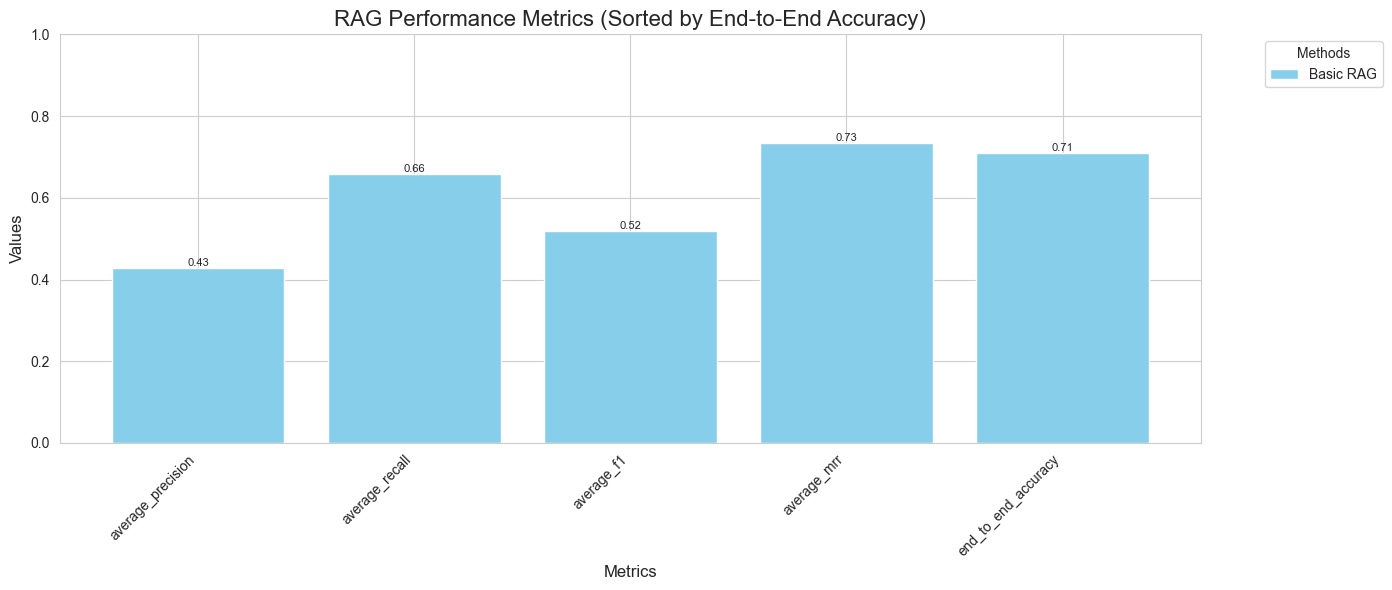

In [35]:
plot_performance('evaluation/json_results', ['Basic RAG'], colors=['skyblue'])

## Level 2: Document summarization for enhanced retrieval

Lets include document summaries: 
- instead of **embedding chunks directly from the docs** -> lets create a concise summary for each chunk and use this summary along with the original content in our embedding process.


This approach aims to capture the essence of each document chunk more effectively, potentially leading to improved retrieval performance. The steps:

1. We load the original document chunks.
2. For each chunk, we generate a 2-3 sentence summary using Claude.
3. We store both the original content and the summary for each chunk in a new json file: data/anthropic_summary_indexed_docs.json


The idea is to rebuild the vector DB which includes the summary feature.

### Generate summaries and storing them

In [36]:
import json
from anthropic import Anthropic
from tqdm import tqdm

def generate_summaries(input_file, output_file):
 
    # Load the original documents
    with open(input_file, 'r') as f:
        docs = json.load(f)

    # Prepare the context about the overall knowledge base
    knowledge_base_context = "This is documentation for Anthropic's, a frontier AI lab building Claude, an LLM that excels at a variety of general purpose tasks. These docs contain model details and documentation on Anthropic's APIs."

    summarized_docs = []

    for doc in tqdm(docs, desc="Generating summaries"):
        prompt = f"""
        You are tasked with creating a short summary of the following content from Anthropic's documentation. 

        Context about the knowledge base:
        {knowledge_base_context}

        Content to summarize:
        Heading: {doc['chunk_heading']}
        {doc['text']}

        Please provide a brief summary of the above content in 2-3 sentences. The summary should capture the key points and be concise. We will be using it as a key part of our search pipeline when answering user queries about this content. 

        Avoid using any preamble whatsoever in your response. Statements such as 'here is the summary' or 'the summary is as follows' are prohibited. You should get straight into the summary itself and be concise. Every word matters.
        """

        response = client.messages.create(
            model="claude-3-haiku-20240307",
            max_tokens=150,
            messages=[
                {"role": "user", "content": prompt}
            ],
            temperature=0
        )

        summary = response.content[0].text.strip()

        summarized_doc = {
            "chunk_link": doc["chunk_link"],
            "chunk_heading": doc["chunk_heading"],
            "text": doc["text"],
            "summary": summary
        }
        summarized_docs.append(summarized_doc)

    # Save the summarized documents to a new JSON file
    with open(output_file, 'w') as f:
        json.dump(summarized_docs, f, indent=2)

    print(f"Summaries generated and saved to {output_file}")

In [37]:
# generate_summaries('data/anthropic_docs.json', 'data/anthropic_summary_indexed_docs.json')

### Summary-Indexed Vector Database Creation

Here, we're creating a new vector database that incorporates our summary-enhanced document chunks. This approach combines the **original text, the chunk heading, and the newly generated summary into a single text for embedding**.

Steps:

- We create embeddings for the combined text (heading + summary + original content) using the Voyage AI API.
- The embeddings and full metadata (including summaries) are stored in our vector database.
- We implement caching mechanisms to improve efficiency in repeated queries.
- The database is saved to disk for persistence and quick loading in future sessions.

This summary-indexed approach aims to create **more informative embeddings.**

In [38]:
import os
import numpy as np
import pickle
import json
import voyageai

class SummaryIndexedVectorDB:
    def __init__(self, name, api_key=None):
        if api_key is None:
            api_key = os.getenv("VOYAGE_API_KEY")
        self.client = voyageai.Client(api_key=api_key)
        self.name = name
        self.embeddings = []
        self.metadata = []
        self.query_cache = {}
        self.db_path = f"./data/{name}/summary_indexed_vector_db.pkl"

    def load_data(self, data_file):
        # Check if the vector database is already loaded
        if self.embeddings and self.metadata:
            print("Vector database is already loaded. Skipping data loading.")
            return
        # Check if vector_db.pkl exists
        if os.path.exists(self.db_path):
            print("Loading vector database from disk.")
            self.load_db()
            return

        with open(data_file, 'r') as f:
            data = json.load(f)

        texts = [f"{item['chunk_heading']}\n\n{item['text']}\n\n{item['summary']}" for item in data]  # Embed Chunk Heading + Text + Summary Together
        # Embed more than 128 documents with a for loop
        batch_size = 128
        result = [
            self.client.embed(
                texts[i : i + batch_size],
                model="voyage-2"
            ).embeddings
            for i in range(0, len(texts), batch_size)
        ]

        # Flatten the embeddings
        self.embeddings = [embedding for batch in result for embedding in batch]
        self.metadata = data  # Store the entire item as metadata
        self.save_db()
        # Save the vector database to disk
        print("Vector database loaded and saved.")

    def search(self, query, k=3, similarity_threshold=0.75):
        query_embedding = None
        if query in self.query_cache:
            query_embedding = self.query_cache[query]
        else:
            query_embedding = self.client.embed([query], model="voyage-2").embeddings[0]
            self.query_cache[query] = query_embedding

        if not self.embeddings:
            raise ValueError("No data loaded in the vector database.")

        similarities = np.dot(self.embeddings, query_embedding)
        top_indices = np.argsort(similarities)[::-1]
        top_examples = []
        
        for idx in top_indices:
            if similarities[idx] >= similarity_threshold:
                example = {
                    "metadata": self.metadata[idx],
                    "similarity": similarities[idx],
                }
                top_examples.append(example)
                
                if len(top_examples) >= k:
                    break
        self.save_db()
        return top_examples
    
    def save_db(self):
        data = {
            "embeddings": self.embeddings,
            "metadata": self.metadata,
            "query_cache": json.dumps(self.query_cache),
        }

        # Ensure the directory exists
        os.makedirs(os.path.dirname(self.db_path), exist_ok=True)
        
        with open(self.db_path, "wb") as file:
            pickle.dump(data, file)

    def load_db(self):
        if not os.path.exists(self.db_path):
            raise ValueError("Vector database file not found. Use load_data to create a new database.")
        
        with open(self.db_path, "rb") as file:
            data = pickle.load(file)
        
        self.embeddings = data["embeddings"]
        self.metadata = data["metadata"]
        self.query_cache = json.loads(data["query_cache"])

Key aspects of this updated retrieval process:

- We search the vector database using the query embedding, retrieving the top k most similar documents.
- For each retrieved document, we include the chunk heading, summary, and full text in the context provided to the LLM.
- This enriched context is then used to generate an answer to the user's query.

In [40]:
def retrieve_level_two(query, db):
    results = db.search(query, k=3)
    context = ""
    for result in results:
        chunk = result['metadata']
        context += f"\n <document> \n {chunk['chunk_heading']}\n\nText\n {chunk['text']} \n\nSummary: \n {chunk['summary']} \n </document> \n" #show model all 3 items
    return results, context


def answer_query_level_two(query, db):
    documents, context = retrieve_base(query, db)
    prompt = f"""
    You have been tasked with helping us to answer the following query: 
    <query>
    {query}
    </query>
    You have access to the following documents which are meant to provide context as you answer the query:
    <documents>
    {context}
    </documents>
    Please remain faithful to the underlying context, and only deviate from it if you are 100% sure that you know the answer already. 
    Answer the question now, and avoid providing preamble such as 'Here is the answer', etc
    """
    response = client.messages.create(
        model="claude-3-haiku-20240307",
        max_tokens=2500,
        messages=[
            {"role": "user", "content": prompt}
        ],
        temperature=0
    )
    return response.content[0].text

In [41]:
# Initialize the SummaryIndexedVectorDB
level_two_db = SummaryIndexedVectorDB("anthropic_docs_v2")
level_two_db.load_data('data/anthropic_summary_indexed_docs.json')

# Run the evaluations
avg_precision, avg_recall, avg_mrr, f1, precisions, recalls, mrrs  = evaluate_retrieval(retrieve_level_two, eval_data, level_two_db)
e2e_accuracy, e2e_results = evaluate_end_to_end(answer_query_level_two, level_two_db, eval_data)

# Create a DataFrame
df = pd.DataFrame({
    'question': [item['question'] for item in eval_data],
    'retrieval_precision': precisions,
    'retrieval_recall': recalls,
    'retrieval_mrr': mrrs,
    'e2e_correct': e2e_results
})

# Save to CSV
df.to_csv('evaluation/csvs/evaluation_results_detailed_level_two.csv', index=False)
print("Detailed results saved to evaluation_results_detailed.csv")

# Print the results
print(f"Average Precision: {avg_precision:.4f}")
print(f"Average Recall: {avg_recall:.4f}")
print(f"Average MRR: {avg_mrr:.4f}")
print(f"Average F1: {f1:.4f}")
print(f"End-to-End Accuracy: {e2e_accuracy:.4f}")

# Save the results to a file
with open('evaluation/json_results/evaluation_results_level_two.json', 'w') as f:
    json.dump({
        "name": "Summary Indexing",
        "average_precision": avg_precision,
        "average_recall": avg_recall,
        "average_f1": f1,
        "average_mrr": avg_mrr,
        "end_to_end_accuracy": e2e_accuracy
    }, f, indent=2)

print("Evaluation complete. Results saved to evaluation_results_level_two.json, evaluation_results_detailed_level_two.csv")

Vector database loaded and saved.


Evaluating Retrieval:  10%|█         | 10/100 [00:02<00:22,  3.95it/s]

Processed 10/100 items. Current Avg Precision: 0.5000, Avg Recall: 0.8000, Avg MRR: 0.8500


Evaluating Retrieval:  20%|██        | 20/100 [00:05<00:23,  3.43it/s]

Processed 20/100 items. Current Avg Precision: 0.4000, Avg Recall: 0.6750, Avg MRR: 0.6667


Evaluating Retrieval:  30%|███       | 30/100 [00:08<00:17,  3.92it/s]

Processed 30/100 items. Current Avg Precision: 0.4222, Avg Recall: 0.6833, Avg MRR: 0.7111


Evaluating Retrieval:  40%|████      | 40/100 [00:10<00:15,  3.96it/s]

Processed 40/100 items. Current Avg Precision: 0.4583, Avg Recall: 0.7000, Avg MRR: 0.7583


Evaluating Retrieval:  50%|█████     | 50/100 [00:13<00:14,  3.56it/s]

Processed 50/100 items. Current Avg Precision: 0.4533, Avg Recall: 0.7100, Avg MRR: 0.7633


Evaluating Retrieval:  60%|██████    | 60/100 [00:16<00:11,  3.58it/s]

Processed 60/100 items. Current Avg Precision: 0.4556, Avg Recall: 0.7278, Avg MRR: 0.7944


Evaluating Retrieval:  70%|███████   | 70/100 [00:18<00:07,  3.76it/s]

Processed 70/100 items. Current Avg Precision: 0.4381, Avg Recall: 0.6988, Avg MRR: 0.7548


Evaluating Retrieval:  80%|████████  | 80/100 [00:21<00:05,  3.40it/s]

Processed 80/100 items. Current Avg Precision: 0.4542, Avg Recall: 0.7240, Avg MRR: 0.7854


Evaluating Retrieval:  90%|█████████ | 90/100 [00:24<00:02,  3.70it/s]

Processed 90/100 items. Current Avg Precision: 0.4556, Avg Recall: 0.7231, Avg MRR: 0.7852


Evaluating Retrieval: 100%|██████████| 100/100 [00:27<00:00,  3.65it/s]


Processed 100/100 items. Current Avg Precision: 0.4500, Avg Recall: 0.7092, Avg MRR: 0.7700


Evaluating End-to-End:   1%|          | 1/100 [00:04<07:10,  4.35s/it]


<content>
<explanation>The Generated Answer is correct. It captures the key elements from the Correct Answer - namely that you can create multiple test cases by clicking the 'Add Test Case' button and filling in values for variables in your prompt, then repeating this process for additional test cases. The Generated Answer actually provides more detail than the Correct Answer by mentioning you can re-run the evaluation suite, but this additional information doesn't contradict the core information. The essential steps and process described are the same in both answers.</explanation>
<is_correct>true</is_correct>
</content>



Evaluating End-to-End:   2%|▏         | 2/100 [00:10<09:04,  5.55s/it]


<content>
<explanation>The Generated Answer is correct in substance compared to the Correct Answer. Both answers identify Voyage AI as Anthropic's recommended embeddings provider and both mention that Voyage AI offers customized/fine-tuned models for specific domains and individual customers. While the Generated Answer provides more specific details about Voyage AI's model offerings that aren't mentioned in the Correct Answer, this additional information doesn't contradict the Correct Answer - it merely elaborates on it. The core claims about Voyage AI's capabilities for domain-specific customization and bespoke fine-tuning are consistent between both answers.</explanation>
<is_correct>true</is_correct>
</content>



Evaluating End-to-End:   3%|▎         | 3/100 [00:16<08:59,  5.56s/it]


<content>
<explanation>The Generated Answer is correct as it captures all the essential elements from the Correct Answer and even provides additional helpful details. Both answers mention the same key success metrics: accuracy, F1 score, consistency, structure, speed, and bias/fairness. Both answers also address the relationship between model choice and latency. While the Generated Answer goes into more specific detail about different Claude models (Haiku, Sonnet, Opus), this additional information doesn't contradict the Correct Answer but rather expands upon it. The core message about choosing the right model to balance speed and performance requirements is consistent between both answers.</explanation>
<is_correct>true</is_correct>
</content>



Evaluating End-to-End:   4%|▍         | 4/100 [00:20<08:18,  5.20s/it]


<content>
<explanation>The generated answer is partially correct but misses a key element from the correct answer. While both answers correctly identify parallel evaluation/testing as one advantage, the second point differs significantly. The correct answer specifically mentions Claude for Sheets' excellence at office tasks like survey analysis and online data processing, while the generated answer instead talks about an integrated workflow and centralized environment. This represents a substantial difference in the functionality being described. Since one of the two key advantages is missing from the generated answer, it cannot be considered fully correct.</explanation>
<is_correct>false</is_correct>
</content>



Evaluating End-to-End:   5%|▌         | 5/100 [00:26<08:25,  5.32s/it]


<content>
<explanation>The Generated Answer is correct. Both answers convey the same core information - that missing the "\n\nHuman:" and "\n\nAssistant:" turns in the prompt will result in an API error. The Generated Answer actually provides slightly more context by explaining that these turns are expected to indicate the start of human input and assistant response, but this additional detail doesn't change the fundamental correctness of the answer. There are no contradictions between the two answers, and no critical information from the Correct Answer is missing from the Generated Answer.</explanation>
<is_correct>true</is_correct>
</content>



Evaluating End-to-End:   6%|▌         | 6/100 [00:32<08:42,  5.55s/it]


<content>
<explanation>The Generated Answer is correct as it conveys the same essential information as the Correct Answer. Both answers emphasize that:

1. Tool use requests are priced based on total tokens like regular requests
2. There are additional tokens required for tool use beyond regular input/output tokens
3. These additional tokens include the tools parameter, tool use/result content blocks, and system prompts
4. These extra tokens contribute to the total cost

While the Generated Answer provides some specific numbers (like 294 tokens for tool choice and 261 for system prompt) that aren't in the Correct Answer, this additional detail doesn't contradict the core message. The fundamental pricing mechanism and the impact of additional tokens on total cost are accurately represented in both answers.</explanation>
<is_correct>true</is_correct>
</content>



Evaluating End-to-End:   7%|▋         | 7/100 [00:38<08:35,  5.55s/it]


<content>
<explanation>The Generated Answer is correct. It contains all the essential information from the Correct Answer - specifically the release date (June 27th, 2024) and what features will be available (API usage, billing details, and rate limits). While the Correct Answer provides slightly more detail by mentioning the specific tabs (Usage, Cost, and Rate Limits), this is a minor detail that doesn't change the core meaning. Both answers convey the same fundamental information about what will be available and when.</explanation>
<is_correct>true</is_correct>
</content>



Evaluating End-to-End:   8%|▊         | 8/100 [00:45<09:13,  6.02s/it]


<content>
<explanation>The Generated Answer captures the key elements from the Correct Answer, though it expands on them in more detail. Both answers emphasize:

1. The need to consider whether the task requires in-depth thinking/analysis (the Generated Answer elaborates on this with specific examples like complex math problems)

2. The impact on latency due to increased output length (both answers explicitly mention this trade-off)

The Generated Answer provides more detail and examples, but the core considerations match those in the Correct Answer. There are no contradictions between the two answers, and no critical pieces of information from the Correct Answer are missing from the Generated Answer. The differences are mainly in the level of detail provided, not in the substance of the guidance.</explanation>
<is_correct>true</is_correct>
</content>



Evaluating End-to-End:   9%|▉         | 9/100 [00:50<08:46,  5.78s/it]


<content>
<explanation>The Generated Answer is correct as it conveys the same core message as the Correct Answer. Both answers emphasize that Claude can be used to summarize PDF documents, making it easier to understand long documents without reading everything. While the Generated Answer includes additional details about the Anthropic Cookbook and text analysis capabilities, these are supplementary details that don't contradict the core message. The essential functionality - uploading PDFs and getting summaries to more easily digest content - is accurately represented in both answers.</explanation>
<is_correct>true</is_correct>
</content>



Evaluating End-to-End:  10%|█         | 10/100 [00:55<08:13,  5.48s/it]


<content>
<explanation>The Generated Answer is correct. Both answers indicate that you can view the API rate limits in a "Rate Limits" tab within Anthropic's console interface. While the Correct Answer specifically mentions "Developer Console" and the Generated Answer just says "Anthropic Console," this is a minor difference in terminology that doesn't change the core substance of the answer. Both answers convey the same essential information - that API rate limits can be viewed in a Rate Limits tab.</explanation>
<is_correct>true</is_correct>
</content>

Processed 10/100 questions. Current Accuracy: 0.9000


Evaluating End-to-End:  11%|█         | 11/100 [01:01<08:39,  5.84s/it]


<content>
<explanation>The generated answer is incorrect because it misses the specific key metrics mentioned in the correct answer. While the generated answer provides a broader and more detailed set of potential metrics, it fails to mention the two critical metrics specified in the correct answer: the 95th percentile response time and average cost per classification. The generated answer talks about speed/latency and cost-effectiveness in general terms, but doesn't specify these precise measurements. When comparing documentation-based answers, we need to ensure the specific metrics mentioned in the documentation are captured accurately. While the additional metrics suggested in the generated answer might be valuable, they don't align with what's specifically stated in Anthropic's documentation as represented by the correct answer.</explanation>
<is_correct>false</is_correct>
</content>



Evaluating End-to-End:  12%|█▏        | 12/100 [01:09<09:27,  6.45s/it]


<content>
<explanation>The Generated Answer is correct. It conveys the same key information as the Correct Answer:

1. For Text Completions API: Both answers specify that the system prompt goes before the first "\n\nHuman:" turn in the prompt text.

2. For Messages API: Both answers indicate that the system prompt is specified as a separate "system" parameter in the API request.

The Generated Answer actually provides more detail through code examples, but the core substance matches the Correct Answer perfectly. There are no contradictions or missing critical pieces of information between the two answers. The differences are merely in presentation and level of detail, not in substance.</explanation>
<is_correct>true</is_correct>
</content>



ERROR:root:XML parsing error: mismatched tag: line 3, column 805
Evaluating End-to-End:  13%|█▎        | 13/100 [01:16<09:32,  6.59s/it]


<content>
<explanation>The generated answer, while detailed and structured, misses a critical element from the correct answer. The correct answer specifically mentions combining XML tags with chain of thought reasoning where "Claude explains its step-by-step reasoning process" and gives a specific example using the <thinking> tag for showing Claude's reasoning process. While the generated answer talks about using XML tags and breaking things into steps, it doesn't explicitly address the core concept of using tags to capture Claude's own reasoning process. The correct answer emphasizes the combination of XML tags with Claude's chain of thought reasoning, while the generated answer focuses more on general prompt structuring and task organization. This represents a significant omission of the key concept.</explanation>
<is_correct>false</is_correct>
</content>



Evaluating End-to-End:  14%|█▍        | 14/100 [01:22<09:21,  6.53s/it]


<content>
<explanation>The generated answer is incorrect for several reasons:

1. While it correctly identifies the three types of metrics (accuracy, cost, and response time), it fails to provide the specific numerical results that were given in the correct answer.

2. The generated answer uses placeholder text ([RESULT_ACCURACY], [RESULT_COST], [RESULT_RESPONSE_TIME]) instead of the actual values from the correct answer (89.01%, $0.0004, and 1.61 seconds).

3. The generated answer refers to "average" response time, while the correct answer specifically mentions "95th percentile" response time, which is a meaningful difference in how the metric is calculated.

Even though the general structure and categories of metrics are correct, the absence of the specific numerical results and the difference in how the response time is characterized (average vs 95th percentile) make this answer incomplete and partially incorrect compared to the correct answer.</explanation>
<is_correct>false</is_c

Evaluating End-to-End:  15%|█▌        | 15/100 [01:27<08:35,  6.06s/it]


<content>
<explanation>The Generated Answer is correct. It captures all three key elements from the Correct Answer:
1. Having clear success criteria
2. Having ways to empirically test against those criteria
3. Having a first draft prompt to improve

The Generated Answer even presents these points in the same order as the Correct Answer. While it adds an additional detail about using the prompt generator in the Anthropic Console, this extra information doesn't contradict the core message and doesn't affect the fundamental correctness of the answer. The substance and main requirements are identical between both answers.</explanation>
<is_correct>true</is_correct>
</content>



Evaluating End-to-End:  16%|█▌        | 16/100 [01:34<08:37,  6.16s/it]


<content>
<explanation>The Generated Answer is correct. While it provides more detail and context about the Messages API's response structure, the key point about mid-response prompting matches the Correct Answer. Both answers explain that:

1. In the Messages API, you can continue a response by setting the last message to have the "assistant" role
2. In the Text Completions API, you can pre-fill part of Claude's response in the prompt

The Generated Answer expresses these same core concepts, just with additional technical details. There are no contradictions between the answers, and no critical information is missing from the Generated Answer compared to the Correct Answer.</explanation>
<is_correct>true</is_correct>
</content>



Evaluating End-to-End:  17%|█▋        | 17/100 [01:40<08:32,  6.17s/it]


<content>
<explanation>The Generated Answer is correct as it captures the essential point made in the Correct Answer - that Claude's response with a role-based system prompt leads to more insightful, structured, and actionable financial analysis compared to not having a specific role. The Generated Answer actually provides more detailed examples and specifics about how the analysis differs, but these additional details don't contradict the core message of the Correct Answer. Both answers emphasize that the role-based response provides better structure, more strategic insights, and more actionable recommendations. There are no critical pieces of information from the Correct Answer that are missing from the Generated Answer, nor are there any contradictions between the two.</explanation>
<is_correct>true</is_correct>
</content>



Evaluating End-to-End:  18%|█▊        | 18/100 [01:47<08:50,  6.47s/it]


<content>
<explanation>
The Generated Answer is correct as it captures the key elements from the Correct Answer and expands on them appropriately:

1. It mentions key quantitative metrics (F1 score is specifically mentioned in both answers)
2. It discusses how targets should be determined based on industry benchmarks and prior experiments, which aligns with the Correct Answer
3. While the Generated Answer provides more specific examples and numerical targets, this additional detail doesn't contradict the Correct Answer - it merely elaborates on it
4. Both answers emphasize the importance of having clear metrics and establishing appropriate targets based on relevant benchmarks and requirements

The Generated Answer actually provides more detail than the Correct Answer, but importantly, it doesn't contradict or miss any critical elements from the Correct Answer. The core concepts about types of metrics and how to determine targets are consistent between both answers.
</explanation>
<is_

ERROR:root:XML parsing error: mismatched tag: line 9, column 182
Evaluating End-to-End:  19%|█▉        | 19/100 [01:51<07:50,  5.81s/it]


<content>
<explanation>The Generated Answer is correct. It captures the key elements from the Correct Answer:
1. The core concept of combining XML tags with other prompt engineering techniques
2. Specifically mentions multishot prompting using <examples> tags
3. Mentions chain of thought using <thinking> and <answer> tags
4. Notes that this creates "super-structured, high-performance prompts"

While the wording is slightly different, the substance and meaning are identical. There are no missing critical pieces of information and no contradictions between the two answers.</explanation>
<is_correct>true</is_correct>
</content>



Evaluating End-to-End:  20%|██        | 20/100 [01:59<08:20,  6.26s/it]


<content>
<explanation>The Generated Answer is correct as it captures all the essential elements from the Correct Answer and even provides additional helpful detail while maintaining the core concept. Both answers emphasize:

1. The need to provide a rubric to the LLM
2. Having the LLM evaluate outputs against this rubric
3. Getting a simple "correct" or "incorrect" result
4. Having the LLM think through its reasoning

The Generated Answer breaks this down into more detailed steps, but doesn't contradict or omit any crucial information from the Correct Answer. The additional detail actually helps clarify the process while staying true to the core concept presented in the Correct Answer.</explanation>
<is_correct>true</is_correct>
</content>

Processed 20/100 questions. Current Accuracy: 0.7500


Evaluating End-to-End:  21%|██        | 21/100 [02:04<07:58,  6.06s/it]


<content>
<explanation>The Generated Answer is correct as it captures all the essential steps from the Correct Answer. Both answers outline the same key process:
1. Subscribing to the model package on AWS Marketplace
2. Getting the Product ARN
3. Creating a JupyterLab space in SageMaker Studio
4. Using Voyage's notebook to deploy the model with the ARN

The Generated Answer breaks down the steps in a slightly different way but conveys the same essential information. There are no critical omissions or contradictions between the two answers. The minor differences in wording and organization don't affect the substantive accuracy of the information provided.</explanation>
<is_correct>true</is_correct>
</content>



Evaluating End-to-End:  22%|██▏       | 22/100 [02:12<08:26,  6.50s/it]


<content>
<explanation>The Generated Answer is incorrect because it misses some key critical points from the Correct Answer and provides different guidance. Specifically:

1. The Correct Answer emphasizes using a SINGLE tool, while the Generated Answer talks about tools in plural without this specification.

2. The Correct Answer specifically mentions setting the tool_choice parameter to explicitly instruct the model to use the tool, which is completely missing from the Generated Answer.

3. The Correct Answer emphasizes that tool names and descriptions should be from the model's perspective since it will pass the input to the tool - this important perspective consideration is missing from the Generated Answer.

Instead, the Generated Answer focuses more on the general process of tool usage and implementation details, which, while not necessarily wrong, misses the specific key points that are crucial for getting JSON output using tools. The Generated Answer describes a more general to

Evaluating End-to-End:  23%|██▎       | 23/100 [02:19<08:41,  6.77s/it]


<content>
<explanation>The Generated Answer is correct and actually provides more detailed information than the Correct Answer while maintaining all the key points. The Generated Answer covers all the essential differences mentioned in the Correct Answer:

1. It mentions the vision capabilities of Claude 3 Haiku
2. It states that Haiku is faster and more performant
3. It indicates that Haiku has better capabilities and intelligence
4. While not explicitly stating "more up-to-date training data," it implies this through mentioning better language understanding and capabilities

The Generated Answer then goes beyond the Correct Answer by providing additional details about cost differences and context window sizes. These additional details don't contradict anything in the Correct Answer, they simply provide more comprehensive information. Since all key points from the Correct Answer are covered and there are no contradictions, the Generated Answer should be considered correct.</explanati

Evaluating End-to-End:  24%|██▍       | 24/100 [02:23<07:33,  5.96s/it]


<content>
<explanation>The Generated Answer is correct. Both answers emphasize the same key point that using examples helps reduce misinterpretation of instructions when working with Claude. While the Generated Answer includes additional information about enforcing uniform structure and style, this doesn't contradict the core message about reducing misinterpretation. The Generated Answer effectively captures the main benefit mentioned in the Correct Answer, just with slightly different wording and some extra detail. Since there are no contradictions and the essential point about reducing misinterpretation is present, this should be considered correct.</explanation>
<is_correct>true</is_correct>
</content>



Evaluating End-to-End:  25%|██▌       | 25/100 [02:30<07:53,  6.32s/it]


<content>
<explanation>The Generated Answer, while providing additional details about resource efficiency and other benefits, does not directly address the key point made in the Correct Answer about the ability to adapt models by providing domain-specific context in prompts. While the Generated Answer isn't wrong in what it states, it misses the central advantage highlighted in the Correct Answer - the ability to easily adapt models to new domains through contextual prompts without retraining. The Generated Answer focuses more on resource efficiency and speed benefits rather than the core adaptability advantage mentioned in the Correct Answer. Since this represents a significant omission of the main point, the Generated Answer should be considered incorrect.</explanation>
<is_correct>false</is_correct>
</content>



Evaluating End-to-End:  26%|██▌       | 26/100 [02:36<07:31,  6.11s/it]


<content>
<explanation>The Generated Answer is correct. While it provides more detailed steps, the core information matches the Correct Answer - that users can get started quickly by making a copy of Anthropic's provided Claude for Sheets workbook template. The additional details in the Generated Answer don't contradict the Correct Answer, they simply elaborate on the implementation. The fundamental message about using a provided template as a quick start method is preserved in both answers.</explanation>
<is_correct>true</is_correct>
</content>



Evaluating End-to-End:  27%|██▋       | 27/100 [02:41<07:07,  5.85s/it]


<content>
<explanation>The Generated Answer is correct as it conveys the same essential meaning as the Correct Answer. Both answers explain that:

1. The "index" field indicates which content block the text relates to
2. The field is used to identify/track specific content blocks within the response
3. The field is connected to the streaming of text content

While the Generated Answer uses slightly different wording and adds some additional detail about the "delta" object, it maintains the core concept that the index field serves to identify which content block is being modified/streamed. There are no contradictions between the answers, and no critical information is missing from the Generated Answer.</explanation>
<is_correct>true</is_correct>
</content>



Evaluating End-to-End:  28%|██▊       | 28/100 [02:47<07:00,  5.84s/it]


<content>
<explanation>The Generated Answer is incorrect. While it provides additional accurate details about image handling, it misses a critical piece of information from the Correct Answer: that images need to be provided as base64-encoded content blocks within the messages array. Instead, the Generated Answer incorrectly states that you can "upload the image file directly to the API." This is a direct contradiction of the correct implementation method specified in the Correct Answer. While both answers correctly list the supported image formats (JPEG, PNG, GIF, and WebP), the method of including images in the API request is fundamentally different between the two answers.</explanation>
<is_correct>false</is_correct>
</content>



Evaluating End-to-End:  29%|██▉       | 29/100 [02:54<07:08,  6.04s/it]


<content>
<explanation>The Generated Answer is correct. Both answers convey the same core concept that TTFT is a specific component of overall latency, measuring specifically the time to generate the first token of a response. The Generated Answer actually provides additional relevant context about factors affecting TTFT and latency, but this extra information doesn't contradict the Correct Answer - it merely elaborates on it. The key relationship between TTFT and latency is accurately captured in both answers, with both emphasizing that TTFT is a specific measure that contributes to overall latency. The Generated Answer also maintains the emphasis on responsiveness that's mentioned in the Correct Answer, though it describes this through different wording.</explanation>
<is_correct>true</is_correct>
</content>



Evaluating End-to-End:  30%|███       | 30/100 [03:00<07:08,  6.12s/it]


<content>
<explanation>The Generated Answer is correct. Both answers convey the same core message that providing edge case examples to Claude can improve its performance in routing support tickets. The Generated Answer actually expands on the Correct Answer by providing more detailed explanations of how examples can help with different types of edge cases (implicit requests, emotional prioritization, intent vs. routing, and issue prioritization). While it provides more detail, it doesn't contradict the Correct Answer, and it covers all the key points mentioned in the Correct Answer about improving ticket routing performance through examples. The substance and main point of both answers align completely.</explanation>
<is_correct>true</is_correct>
</content>

Processed 30/100 questions. Current Accuracy: 0.7333


Evaluating End-to-End:  31%|███       | 31/100 [03:06<07:06,  6.18s/it]


<content>
<explanation>The Generated Answer is correct as it captures all the essential elements of the Correct Answer and even provides additional helpful context while maintaining accuracy. Both answers describe:

1. Claude's determination that a tool is needed
2. The construction of a tool use request
3. The stop_reason="tool_use" as a signal of Claude's intent
4. The need for the client/external system to extract and execute the tool
5. The requirement to return results back to Claude

The Generated Answer expands on these points in a more detailed way but doesn't contradict or omit any critical information from the Correct Answer. The core workflow and the role of the stop_reason="tool_use" are accurately represented in both answers.</explanation>
<is_correct>true</is_correct>
</content>



Evaluating End-to-End:  32%|███▏      | 32/100 [03:11<06:32,  5.77s/it]


<content>
<explanation>The Generated Answer is correct. It contains all the key elements from the Correct Answer:
1. It correctly identifies the error event as "overloaded_error"
2. It specifies that this occurs during periods of high usage
3. It correctly states that this corresponds to HTTP 529 error code in non-streaming contexts
4. It properly contextualizes this within streaming responses

The Generated Answer simply rephrases the same information in a slightly different way, but maintains all the critical substance and technical details. There are no contradictions or missing pieces of information between the two answers.</explanation>
<is_correct>true</is_correct>
</content>



Evaluating End-to-End:  33%|███▎      | 33/100 [03:15<05:52,  5.27s/it]


<content>
<explanation>The Generated Answer is correct. It identifies both types of deltas that can be contained in a content_block_delta event: text_delta and input_json_delta. While the formatting and presentation are slightly different (using a numbered list instead of prose), the substance and key information are exactly the same as the Correct Answer. Both answers convey the same two specific delta types without any omissions or contradictions.</explanation>
<is_correct>true</is_correct>
</content>



Evaluating End-to-End:  34%|███▍      | 34/100 [03:21<05:59,  5.44s/it]


<content>
<explanation>The Generated Answer is incorrect. According to the Correct Answer, Claude 3.5 Sonnet and tool use became generally available on different dates:
- Claude 3.5 Sonnet: June 20th, 2024
- Tool use: May 30th, 2024

The Generated Answer incorrectly states that both became available on June 20th, 2024. This is a critical factual error as it misses the distinction between the two release dates. The timing difference of several weeks between these features' availability is an important detail that shouldn't be overlooked.</explanation>
<is_correct>false</is_correct>
</content>



Evaluating End-to-End:  35%|███▌      | 35/100 [03:25<05:19,  4.91s/it]


<content>
<explanation>The Generated Answer is correct in substance. While it doesn't include the specific timing (May 2024 for Europe and June 2024 for Canada), it accurately captures the key information about the order of the launches - that Anthropic launched Claude.ai and the Claude iOS app in Europe first, followed by Canada. The core sequence of events is preserved, which is the essential information being conveyed. The omission of specific months doesn't change the fundamental accuracy of the answer.</explanation>
<is_correct>true</is_correct>
</content>



Evaluating End-to-End:  36%|███▌      | 36/100 [03:32<05:57,  5.58s/it]


<content>
<explanation>The Generated Answer is correct. It captures all the essential elements from the Correct Answer:

1. It correctly explains that a "tool_use" stop_reason indicates Claude has decided to use a tool
2. It outlines the exact same steps that need to be taken:
   - Extracting the tool name and input from Claude's request
   - Executing the tool code on the client side
   - Sending back a new message with a tool_result content block

While the wording and structure differ slightly, the substance and key information are identical. The Generated Answer even provides additional context about why this process is useful (to help Claude formulate a final response), but this extra information doesn't contradict anything in the Correct Answer.</explanation>
<is_correct>true</is_correct>
</content>



Evaluating End-to-End:  37%|███▋      | 37/100 [03:37<05:43,  5.46s/it]


<content>
<explanation>The Generated Answer is correct as it conveys the same essential information as the Correct Answer. Both answers indicate that the anthropic library is used to interact with Claude/Anthropic's AI capabilities. While the Generated Answer provides slightly more detail by explaining what the anthropic library does, the core substance - that the anthropic library is the Python library used in the example - is consistent between both answers. There are no contradictions or missing critical pieces of information.</explanation>
<is_correct>true</is_correct>
</content>



Evaluating End-to-End:  38%|███▊      | 38/100 [03:41<05:05,  4.94s/it]


<content>
<explanation>The Generated Answer is correct. It captures both main authentication methods described in the Correct Answer:

1. Direct provision of AWS credentials (access key, secret key, and optional session token)
2. Using default AWS credential providers (including both the ~/.aws/credentials file and environment variables)

The Generated Answer conveys the same essential information as the Correct Answer, just with slightly different wording. There are no missing critical pieces of information and no contradictions between the two answers. The substance and meaning are equivalent.</explanation>
<is_correct>true</is_correct>
</content>



Evaluating End-to-End:  39%|███▉      | 39/100 [03:47<05:30,  5.42s/it]


<content>
<explanation>The Generated Answer is correct. It captures the same two key factors mentioned in the Correct Answer:

1. The risk/potential of prompt leaks (protecting sensitive information)
2. The impact on model performance due to added complexity

While the Generated Answer elaborates more on each factor with additional examples and details, the core substance and trade-off described is identical to the Correct Answer. Both answers emphasize the need to balance protecting against leaks with maintaining model performance. There are no contradictions between the two answers, and no critical information from the Correct Answer is missing from the Generated Answer.</explanation>
<is_correct>true</is_correct>
</content>



Evaluating End-to-End:  40%|████      | 40/100 [03:52<05:17,  5.28s/it]


<content>
<explanation>The Generated Answer is correct as it conveys the same core message as the Correct Answer. Both answers emphasize that:

1. Anthropic offers different Claude models with varying capabilities and performance characteristics
2. Selecting the right model allows you to optimize for the best balance of speed, intelligence, and cost
3. The main goal is to choose a model that best fits your specific requirements to reduce latency

While the Generated Answer provides additional details about model families and metrics, these details don't contradict the Correct Answer but rather expand upon it. The fundamental point about choosing the appropriate model to reduce latency is preserved in both answers.</explanation>
<is_correct>true</is_correct>
</content>

Processed 40/100 questions. Current Accuracy: 0.7750


Evaluating End-to-End:  41%|████      | 41/100 [03:58<05:17,  5.38s/it]


<content>
<explanation>The Generated Answer is correct. It contains all the essential information from the Correct Answer and even provides more detailed implementation examples. Both answers highlight the key points that:

1. You use the client.messages.stream() method
2. You iterate over the stream.text_stream attribute in a for loop

The Generated Answer expands on this with a practical code example and additional context, but the core information matches the Correct Answer completely. There are no contradictions or missing critical pieces between the two answers.</explanation>
<is_correct>true</is_correct>
</content>



Evaluating End-to-End:  42%|████▏     | 42/100 [04:02<04:53,  5.07s/it]


<content>
<explanation>The Generated Answer is correct as it captures the two key points from the Correct Answer:

1. It explains that you can guide Claude's response by pre-filling part of it in the messages list (though it specifically mentions the "assistant" message, which is just a more detailed explanation of the same concept)

2. It correctly identifies that the "max_tokens" parameter is used to generate short responses by limiting the length of the output

The substance and main concepts are the same between both answers, even though they use slightly different wording. There are no critical missing pieces of information or contradictions between the two answers.</explanation>
<is_correct>true</is_correct>
</content>



Evaluating End-to-End:  43%|████▎     | 43/100 [04:08<05:06,  5.37s/it]


<content>
<explanation>The Generated Answer is correct. Both answers make the same core assertion that having a larger volume of automated test cases is more important than having fewer human-graded test cases when building an eval set. The Generated Answer expands on this with additional context and explanation, but the fundamental point being made is identical to the Correct Answer. There are no contradictions between the two answers, and no critical pieces of information from the Correct Answer are missing from the Generated Answer. While the Generated Answer is more verbose, the substance and main conclusion are the same.</explanation>
<is_correct>true</is_correct>
</content>



Evaluating End-to-End:  44%|████▍     | 44/100 [04:12<04:40,  5.01s/it]


<content>
<explanation>The Generated Answer is incorrect because it misses a critical required field mentioned in the Correct Answer. While it correctly identifies that there needs to be a "type" and "text" field, these are actually part of the "delta" field. The Correct Answer states that the two required fields are "index" and "delta". The Generated Answer completely omits the required "index" field, which makes it incomplete and therefore incorrect.</explanation>
<is_correct>false</is_correct>
</content>



Evaluating End-to-End:  45%|████▌     | 45/100 [04:17<04:22,  4.78s/it]


<content>
<explanation>The generated answer is incorrect because it misses one of the key interactive learning methods mentioned in the correct answer. While it correctly identifies the Anthropic Cookbook as one interactive way to learn Claude's capabilities, it fails to mention the Developer Console and its prompt generator tool, which is the second key method specified in the correct answer. Instead, it incorrectly references "Claude for Sheets usage examples" as the second method. This represents a significant omission and deviation from the correct answer.</explanation>
<is_correct>false</is_correct>
</content>



Evaluating End-to-End:  46%|████▌     | 46/100 [04:22<04:23,  4.88s/it]


<content>
<explanation>The Generated Answer is correct. The core concept from the Correct Answer - that breaking tasks into subtasks improves accuracy because each subtask gets Claude's full attention and reduces errors compared to handling everything at once - is fully captured in the Generated Answer's first point about accuracy. While the Generated Answer goes on to provide additional points about clarity and traceability, these are supplementary details that don't contradict the core concept. The essential message about improved accuracy through focused attention on subtasks is present in both answers.</explanation>
<is_correct>true</is_correct>
</content>



Evaluating End-to-End:  47%|████▋     | 47/100 [04:30<05:04,  5.74s/it]


<content>
<explanation>The Generated Answer is correct. The key point from the Correct Answer - that Messages streaming responses can contain multiple content blocks of varying types, making it more complex than Text Completions streaming - is accurately captured in the Generated Answer's first point. While the Generated Answer provides additional details about the differences between the two formats, these extra details don't contradict the core concept presented in the Correct Answer. The Generated Answer effectively communicates the main distinction between the two streaming formats, which is the ability to handle multiple content blocks of different types in Messages responses versus the simpler format of Text Completions.</explanation>
<is_correct>true</is_correct>
</content>



Evaluating End-to-End:  48%|████▊     | 48/100 [04:36<05:08,  5.93s/it]


<content>
<explanation>The Generated Answer is partially incorrect. While it correctly mentions claude.ai (the web Console) as one way to experiment with Claude, it incorrectly lists the Quickstart guide/API call as the second method instead of just the web Console. The Correct Answer specifically states that the two ways are "claude.ai" and "Anthropic's web Console" - which are actually referring to the same interface, just described differently. The Generated Answer introduces the API/Quickstart guide which isn't mentioned in the Correct Answer as one of the two primary ways to experiment with Claude. This represents a substantive difference in the information provided.</explanation>
<is_correct>false</is_correct>
</content>



Evaluating End-to-End:  49%|████▉     | 49/100 [04:42<05:02,  5.93s/it]


<content>
<explanation>The Generated Answer is correct and actually provides more detailed elaboration on the core concept presented in the Correct Answer. Both answers share the same fundamental point: that chain prompts help reduce errors and inconsistencies by breaking complex tasks into smaller, more manageable subtasks that Claude can focus on individually. The Generated Answer expands on this concept by providing additional benefits and mechanisms, but it doesn't contradict or miss any critical information from the Correct Answer. The additional detail in the Generated Answer (like traceability and mitigation of hallucinations) simply provides more context and explanation around the core concept, rather than changing or contradicting the main point.</explanation>
<is_correct>true</is_correct>
</content>



Evaluating End-to-End:  50%|█████     | 50/100 [04:45<04:18,  5.18s/it]


<content>
<explanation>The Generated Answer is correct. Both answers state that an overloaded_error event corresponds to HTTP status code 529 in a non-streaming context for the Anthropic API. While the Correct Answer uses slightly more formal language ("would normally correspond to"), the core information - the 529 status code - is identical in both answers. The difference in phrasing does not change the fundamental meaning or accuracy of the response.</explanation>
<is_correct>true</is_correct>
</content>

Processed 50/100 questions. Current Accuracy: 0.7600


Evaluating End-to-End:  51%|█████     | 51/100 [04:51<04:18,  5.27s/it]


<content>
<explanation>The Generated Answer is correct. It captures the same two key ways to specify the embedding format as described in the Correct Answer:

1. Both answers indicate that leaving the format unspecified will return embeddings as lists of floating-point numbers
2. Both answers state that setting the format to "base64" will return the embeddings in Base64 encoded format

The Generated Answer presents the same information in a slightly more structured format with bullet points, but the substance and technical details are identical to the Correct Answer. There are no missing critical pieces of information or contradictions between the two answers.</explanation>
<is_correct>true</is_correct>
</content>



Evaluating End-to-End:  52%|█████▏    | 52/100 [04:57<04:27,  5.58s/it]


<content>
<explanation>The Generated Answer is correct as it conveys the same essential information as the Correct Answer. Both answers explain that:

1. Tool use content blocks are sent as partial JSON strings in content_block_delta events
2. The client needs to accumulate these partial JSON strings
3. The complete JSON can be parsed once a content_block_stop event is received
4. Parsing can be done using Pydantic or SDK helpers

The Generated Answer actually provides additional helpful detail by showing an example of the delta structure, but this doesn't contradict anything in the Correct Answer. The core concepts and process are described accurately and consistently between both answers.</explanation>
<is_correct>true</is_correct>
</content>



Evaluating End-to-End:  53%|█████▎    | 53/100 [05:03<04:22,  5.59s/it]


<content>
<explanation>The generated answer is incorrect. While it correctly identifies that there are two tutorials - one on GitHub and one involving Google Sheets - it makes incorrect claims about their nature. The generated answer states that the Claude for Sheets tutorial is "in-depth" and requires an API key, while the correct answer specifically states that the Google Sheets tutorial is "lighter-weight." This is a direct contradiction. Additionally, the generated answer adds details about API key requirements that aren't mentioned in the correct answer and could be misleading. The core characterization of the tutorials is reversed - according to the correct answer, it's the GitHub tutorial that is in-depth, not the Google Sheets one.</explanation>
<is_correct>false</is_correct>
</content>



Evaluating End-to-End:  54%|█████▍    | 54/100 [05:11<04:50,  6.32s/it]


<content>
<explanation>The Generated Answer is correct and actually provides more comprehensive detail than the Correct Answer. It covers all the key points mentioned in the Correct Answer:

1. The 200K token context window
2. Tool use capabilities for integration with specialized applications
3. Multimodal input capabilities
4. Enterprise-grade security and data handling for sensitive information

The Generated Answer then goes beyond these points to provide additional relevant details about enterprise capabilities, such as HIPAA compliance, SOC II certification, developer features, and global language capabilities. While it provides more information than the Correct Answer, it doesn't contradict any points and includes all the critical elements mentioned in the Correct Answer. The additional information simply provides more context and depth to the core capabilities mentioned in the Correct Answer.</explanation>
<is_correct>true</is_correct>
</content>



Evaluating End-to-End:  55%|█████▌    | 55/100 [05:15<04:10,  5.56s/it]


<content>
<explanation>The Generated Answer is incorrect because it omits a key region where Claude.ai API and iOS app are available - the United States. While the Generated Answer correctly mentions Canada and Europe, leaving out the United States represents a significant omission of information. The availability in the United States is a critical piece of information present in the Correct Answer but missing from the Generated Answer. Therefore, despite getting two regions correct, the Generated Answer is incomplete and thus incorrect.</explanation>
<is_correct>false</is_correct>
</content>



Evaluating End-to-End:  56%|█████▌    | 56/100 [05:21<04:18,  5.87s/it]


<content>
<explanation>The Generated Answer is correct. It captures both main approaches (push-based using webhooks and pull-based) and accurately describes their key differences in terms of scalability and implementation ease. The Generated Answer expands on the Correct Answer with more detail, but maintains the same core information:

1. It correctly identifies that push-based is more scalable but has security implications due to requiring a public endpoint
2. It correctly states that pull-based is easier to implement but less efficient due to unnecessary system calls

The Generated Answer doesn't contradict any points in the Correct Answer, and includes all the critical information. While it provides more detailed explanations, the substance of both answers is the same.</explanation>
<is_correct>true</is_correct>
</content>



Evaluating End-to-End:  57%|█████▋    | 57/100 [05:25<03:48,  5.32s/it]


<content>
<explanation>The Generated Answer is completely correct. It contains all the key information from the Correct Answer: the release date (May 10th, 2024), what was released (a prompt generator tool), and where it's available (through the Developer Console). The wording is slightly different but conveys exactly the same information and meaning. There are no missing critical pieces of information and no contradictions between the two answers.</explanation>
<is_correct>true</is_correct>
</content>



Evaluating End-to-End:  58%|█████▊    | 58/100 [05:32<03:57,  5.66s/it]


<content>
<explanation>The Generated Answer is correct. Both answers convey the same core message that Claude 3 Sonnet provides the optimal balance between intelligence and speed for high-throughput tasks like sales forecasting and targeted marketing. The Generated Answer actually provides additional supporting detail about Sonnet's "Strong utility, balanced for scaled deployments" but this extra information doesn't change or contradict the fundamental point. The key elements from the Correct Answer (Sonnet model, balance of intelligence/speed, suitability for high-throughput tasks) are all present in the Generated Answer.</explanation>
<is_correct>true</is_correct>
</content>



Evaluating End-to-End:  59%|█████▉    | 59/100 [05:37<03:44,  5.47s/it]


<content>
<explanation>The Generated Answer is correct. It conveys the same core information as the Correct Answer - that similarity between Voyage embedding vectors can be calculated using either dot product or cosine similarity, and these are equivalent because the vectors are normalized to length 1. In fact, the Generated Answer goes into more helpful detail explaining why this is the case mathematically, but the fundamental point being made is identical to the Correct Answer. There are no contradictions between the two answers, and no critical information is missing from the Generated Answer.</explanation>
<is_correct>true</is_correct>
</content>



Evaluating End-to-End:  60%|██████    | 60/100 [05:43<03:44,  5.62s/it]


<content>
<explanation>The Generated Answer is correct. It captures all the key points from the Correct Answer and even expands on them in a helpful way. Both answers emphasize that examples can:
1. Reduce misinterpretation of instructions
2. Help enforce consistent structure and style
3. Guide Claude toward desired output/performance

The Generated Answer provides additional details and examples, but these don't contradict the Correct Answer - they simply elaborate on the core concepts. The substance of both answers is fundamentally the same, even though the Generated Answer is more detailed. There are no critical omissions or contradictions between the two answers.</explanation>
<is_correct>true</is_correct>
</content>

Processed 60/100 questions. Current Accuracy: 0.7667


Evaluating End-to-End:  61%|██████    | 61/100 [05:49<03:49,  5.88s/it]


<content>
<explanation>The Generated Answer is correct. It accurately describes both types of content block deltas:

1. It correctly identifies that there are text deltas and input JSON deltas
2. For text deltas, both answers indicate they contain text content/updates
3. For input JSON deltas, both answers explain that they contain partial JSON content related to tool input
4. The substance of what each delta type contains matches between both answers

While the wording and level of detail varies slightly between the answers, the core information about the two types of deltas and their contents is consistent and accurate. There are no contradictions or missing critical pieces of information.</explanation>
<is_correct>true</is_correct>
</content>



Evaluating End-to-End:  62%|██████▏   | 62/100 [05:55<03:39,  5.77s/it]


<content>
<explanation>The Generated Answer is incorrect because it focuses on different capabilities than those mentioned in the Correct Answer. The Correct Answer specifically highlights question answering and text analysis capabilities as key enablers for interactive systems and personalization. In contrast, the Generated Answer discusses text/code generation and tool use capabilities. While these are valid capabilities of Claude, they are not the specific ones identified in the Correct Answer as enabling interactive systems and personalized experiences. Additionally, the Generated Answer misses the important point about understanding sentiment and preferences that is mentioned in the Correct Answer. The two answers are discussing different sets of capabilities, making them substantively different.</explanation>
<is_correct>false</is_correct>
</content>



Evaluating End-to-End:  63%|██████▎   | 63/100 [06:00<03:24,  5.54s/it]


<content>
<explanation>The Generated Answer is correct. It captures all the key elements from the Correct Answer and presents them in essentially the same order:

1. Both answers mention the message_start event coming first
2. Both describe the content blocks structure with start, delta, and stop events
3. Both mention message_delta events
4. Both include the final message_stop event
5. Both note that ping events may be dispersed throughout

The Generated Answer actually provides slightly more detail by explicitly mentioning that the message_start contains a Message object with empty content, but this additional detail doesn't contradict the Correct Answer. The core sequence and components are identical between both answers.</explanation>
<is_correct>true</is_correct>
</content>



Evaluating End-to-End:  64%|██████▍   | 64/100 [06:04<03:12,  5.35s/it]


<content>
<explanation>The Generated Answer is correct. It conveys the same key information as the Correct Answer - specifically that the Anthropic API allows up to 20 images per request while the claude.ai interface has a 5 image limit. While the Correct Answer uses slightly different wording ("per turn" vs "per request"), the substance and numerical limits stated are identical. There are no critical missing pieces of information or contradictions between the two answers.</explanation>
<is_correct>true</is_correct>
</content>



Evaluating End-to-End:  65%|██████▌   | 65/100 [06:09<02:56,  5.05s/it]


<content>
<explanation>The Generated Answer is correct. It captures the key substance of the Correct Answer, which is that when Claude's response contains an incomplete tool use block due to hitting the max_tokens limit, you should retry with a higher max_tokens value to get the complete tool use. The wording is almost identical, with the Generated Answer just being slightly more concise but conveying the exact same meaning and instruction. There are no missing critical pieces of information and no contradictions between the two answers.</explanation>
<is_correct>true</is_correct>
</content>



Evaluating End-to-End:  66%|██████▌   | 66/100 [06:13<02:41,  4.75s/it]


<content>
<explanation>The Generated Answer is incorrect. While both answers mention developing test cases as one of the steps, they differ on the second step. The Correct Answer states that you need to "take a look at Anthropic's guide to developing test cases" while the Generated Answer states you need to "build a strong input prompt." These are substantively different steps. The Generated Answer is missing the critical piece about consulting Anthropic's guide, and instead introduces a different step that wasn't mentioned in the Correct Answer. This represents a meaningful difference in the substance of what needs to be done before running a classification evaluation.</explanation>
<is_correct>false</is_correct>
</content>



Evaluating End-to-End:  67%|██████▋   | 67/100 [06:19<02:54,  5.29s/it]


<content>
<explanation>The generated answer is correct and actually provides more detail than the correct answer while maintaining the core concept. Both answers emphasize the key point that you can use the content parameter with an "assistant" role message to pre-fill and shape Claude's response. The generated answer expands on this with additional context about system prompts and conversation simulation, but the fundamental mechanism described matches the correct answer. There are no contradictions between the two answers, and the generated answer includes all critical information from the correct answer.</explanation>
<is_correct>true</is_correct>
</content>



Evaluating End-to-End:  68%|██████▊   | 68/100 [06:29<03:28,  6.51s/it]


<content>
<explanation>The Generated Answer is correct. It captures both key advantages mentioned in the Correct Answer:

1. It correctly states that prompt engineering preserves general knowledge while fine-tuning risks catastrophic forgetting
2. It accurately notes that prompt engineering is more effective at helping models understand and utilize external content/retrieved documents

The Generated Answer essentially restates the same two key points from the Correct Answer, just with slightly different wording. There are no missing critical pieces of information and no contradictions between the two answers. The substance and meaning are identical.</explanation>
<is_correct>true</is_correct>
</content>



Evaluating End-to-End:  69%|██████▉   | 69/100 [06:34<03:05,  6.00s/it]


<content>
<explanation>The Generated Answer is incorrect. The key difference is that the Generated Answer describes steps for using Anthropic's direct API (obtaining an Anthropic account/API key), while the Correct Answer specifically addresses Bedrock API integration, which requires AWS CLI configuration and a Bedrock SDK. These are fundamentally different authentication and setup processes. The Generated Answer misses the critical AWS-specific components required for Bedrock integration and instead describes a different access path altogether. This represents a substantive difference in the technical requirements and implementation approach, not just a difference in wording.</explanation>
<is_correct>false</is_correct>
</content>



Evaluating End-to-End:  70%|███████   | 70/100 [06:38<02:49,  5.66s/it]


<content>
<explanation>The Generated Answer is correct. It provides the exact same command structure and functionality as the Correct Answer, including:
1. The correct AWS CLI command `aws bedrock list-foundation-models`
2. The correct use of the `--region` parameter
3. The correct use of `--by-provider anthropic`
4. The correct query parameter to get model IDs
5. A specific example using `us-west-2` region

The Generated Answer conveys the same essential information and instructions as the Correct Answer, just with slightly different wording in the explanatory text. There are no missing critical pieces of information or contradictions between the two answers.</explanation>
<is_correct>true</is_correct>
</content>

Processed 70/100 questions. Current Accuracy: 0.7571


Evaluating End-to-End:  71%|███████   | 71/100 [06:44<02:46,  5.75s/it]


<content>
<explanation>The Generated Answer is correct. Both answers convey the same core information - that the `input_type` argument/parameter can be passed with either "query" or "document" as values to specify the type of input text being embedded. The Generated Answer simply restates this information in a slightly more verbose way, but the substance and technical accuracy are identical to the Correct Answer. There are no missing critical pieces of information or contradictions between the two answers.</explanation>
<is_correct>true</is_correct>
</content>



Evaluating End-to-End:  72%|███████▏  | 72/100 [06:49<02:29,  5.32s/it]


<content>
<explanation>The Generated Answer is missing a critical piece of information that is present in the Correct Answer. While it correctly describes the basic difference between tool_use deltas (partial JSON strings) and text deltas (direct text updates), it fails to mention that tool_use deltas may have delays between streaming events as the model emits one complete key-value pair at a time. This is an important characteristic of the tool_use streaming behavior that is explicitly mentioned in the Correct Answer but absent from the Generated Answer. Since this represents a meaningful omission of functionality, the Generated Answer should be marked as incorrect.</explanation>
<is_correct>false</is_correct>
</content>



Evaluating End-to-End:  73%|███████▎  | 73/100 [06:53<02:15,  5.03s/it]


<content>
<explanation>The Generated Answer is correct. It provides the exact same file size limits as the Correct Answer - 5MB for API uploads and 10MB for claude.ai uploads. The Generated Answer simply presents this information in a slightly different format (bullet points) and adds a minor detail about error messages, but the core information about the file size limits matches perfectly with the Correct Answer. There are no contradictions or missing critical pieces of information.</explanation>
<is_correct>true</is_correct>
</content>



Evaluating End-to-End:  74%|███████▍  | 74/100 [06:58<02:06,  4.85s/it]


<content>
<explanation>The Generated Answer is correct. Both answers emphasize the key point of choosing a model that appropriately balances requirements for the specific use case. The Generated Answer actually provides more detail by mentioning Claude 3 Haiku as a specific example, but the core message about selecting a model based on the balance of speed/latency and output quality is present in both answers. There are no contradictions between the two answers, and the Generated Answer captures the essential consideration mentioned in the Correct Answer.</explanation>
<is_correct>true</is_correct>
</content>



Evaluating End-to-End:  75%|███████▌  | 75/100 [07:03<02:04,  4.99s/it]


<content>
<explanation>The Generated Answer is correct as it contains all the key information from the Correct Answer:
1. It correctly identifies the recommended model as "voyage-code-2"
2. It mentions the 17% better performance compared to alternatives
3. It notes the state-of-the-art performance on general-purpose corpora
4. The overall meaning and substance is identical, with only minor differences in wording and sentence structure

There are no critical omissions or contradictions between the two answers. The only difference is in how the information is phrased, but the core facts and claims remain the same.</explanation>
<is_correct>true</is_correct>
</content>



Evaluating End-to-End:  76%|███████▌  | 76/100 [07:07<01:56,  4.84s/it]


<content>
<explanation>The Generated Answer is essentially correct. Both answers highlight that the Anthropic Cookbook provides interactive Jupyter notebooks that demonstrate API functionality, specifically mentioning PDF uploads and embeddings. While the Generated Answer splits this into two points and adds some additional context about hands-on learning, the core information matches the Correct Answer. There are no contradictions or missing critical pieces of information between the two answers - they're conveying the same fundamental message about how the Cookbook helps developers learn through interactive notebooks and demonstrations.</explanation>
<is_correct>true</is_correct>
</content>



Evaluating End-to-End:  77%|███████▋  | 77/100 [07:13<01:56,  5.08s/it]


<content>
<explanation>The Generated Answer is correct as it conveys the same core concept as the Correct Answer. Both answers emphasize that:

1. The context window size directly impacts how much retrieved information can be utilized in RAG
2. A larger context window enables better utilization of retrieved information
3. This affects the quality and effectiveness of the model's responses

While the Generated Answer includes additional details about coherence and complex prompts, it doesn't contradict the Correct Answer. The fundamental understanding that context window size determines how much retrieved information can be used for RAG is present in both answers. The Generated Answer simply elaborates on the implications of this relationship.</explanation>
<is_correct>true</is_correct>
</content>



Evaluating End-to-End:  78%|███████▊  | 78/100 [07:20<02:07,  5.79s/it]


<content>
<explanation>The Generated Answer is correct as it captures all the key points from the Correct Answer and even expands on them in a helpful way. Both answers emphasize:

1. The tool's ability to identify edge cases where prompts might not perform well
2. The capability to rate individual results to assess prompt performance
3. The importance of ensuring consistent performance across different inputs
4. The ability to review results and spot patterns for making improvements

The Generated Answer adds an additional point about feedback and iteration, but this doesn't contradict anything in the Correct Answer - it's just supplementary information. The core substance about how the Evaluation tool helps improve prompts and build robust AI applications is consistent between both answers.</explanation>
<is_correct>true</is_correct>
</content>



Evaluating End-to-End:  79%|███████▉  | 79/100 [07:25<01:51,  5.29s/it]


<content>
<explanation>The Generated Answer is correct. Both answers state that Claude 3 Haiku has the fastest comparative latency. The Generated Answer simply adds a bit more context by specifying "among the Claude models" but the core information - that Claude 3 Haiku is the fastest - is identical. There are no contradictions between the answers, and no critical information is missing from the Generated Answer.</explanation>
<is_correct>true</is_correct>
</content>



Evaluating End-to-End:  80%|████████  | 80/100 [07:33<02:04,  6.22s/it]


<content>
<explanation>The Generated Answer is correct. It captures the key point from the Correct Answer that the Messages API is stateless and requires sending the full conversation history with each request. The Generated Answer actually provides more detailed information and a practical example of how to implement this, but the core concept matches exactly with the Correct Answer. Both answers emphasize that you need to include the complete conversation history (both user and assistant messages) in each API call to maintain context. There are no contradictions between the answers, and the Generated Answer doesn't miss any critical information from the Correct Answer - it just expands upon it with implementation details.</explanation>
<is_correct>true</is_correct>
</content>

Processed 80/100 questions. Current Accuracy: 0.7750


Evaluating End-to-End:  81%|████████  | 81/100 [07:40<02:00,  6.32s/it]


<content>
<explanation>The Generated Answer is correct as it captures the core message of the Correct Answer. Both answers emphasize that using XML tags with a specific role (like General Counsel) helps Claude identify critical legal issues and risks in contracts that might otherwise be missed. While the Generated Answer provides more detail and additional benefits, it doesn't contradict the Correct Answer, and it maintains the key point about improved analysis leading to better risk identification. The mention of "saving the company millions of dollars" from the Correct Answer is implicit in the Generated Answer's discussion of identifying critical risks and issues. The additional detail in the Generated Answer simply expands on the core concept without changing its fundamental meaning.</explanation>
<is_correct>true</is_correct>
</content>



Evaluating End-to-End:  82%|████████▏ | 82/100 [07:45<01:47,  6.00s/it]


<content>
<explanation>The Generated Answer is essentially correct. While it uses different wording and provides some additional context about the models' general characteristics, the core distinction it describes aligns with the Correct Answer: Claude 3 Opus is more likely to seek clarification (or "ask for missing information" in the Correct Answer's words), while Claude 3 Sonnet is more likely to make inferences/assumptions about missing parameters. The substance of how each model handles missing information in tool calls is consistent between both answers, even though they express it differently.</explanation>
<is_correct>true</is_correct>
</content>



Evaluating End-to-End:  83%|████████▎ | 83/100 [07:51<01:44,  6.18s/it]


<content>
<explanation>The Generated Answer is correct as it covers all the key points mentioned in the Correct Answer and even provides additional helpful detail. Both answers emphasize:

1. Implementing retry logic for error handling
2. Conducting thorough staging/testing
3. Load testing
4. Error handling and logging setup
5. Gradual rollout process
6. Documentation and training
7. Monitoring and alerting

The Generated Answer expands on these points with more specific implementation details, but the core recommendations align perfectly with the Correct Answer. There are no contradictions between the two answers, and no critical pieces of information from the Correct Answer are missing from the Generated Answer.</explanation>
<is_correct>true</is_correct>
</content>



Evaluating End-to-End:  84%|████████▍ | 84/100 [07:57<01:38,  6.14s/it]


<content>
<explanation>The Generated Answer is correct. It covers all three key elements mentioned in the Correct Answer:

1. Accuracy - explicitly mentioned and discussed
2. Cost - covered through "Average Cost per Classification"
3. Speed - addressed through "95th Percentile Response Time"

While the Generated Answer provides additional details and context beyond what's in the Correct Answer, it doesn't contradict anything in the Correct Answer and includes all the critical components. The extra information (like consistency across ticket types, handling edge cases, etc.) is supplementary and doesn't detract from the core evaluation criteria specified in the Correct Answer.</explanation>
<is_correct>true</is_correct>
</content>



Evaluating End-to-End:  85%|████████▌ | 85/100 [08:02<01:24,  5.63s/it]


<content>
<explanation>The Generated Answer is correct. Both answers identify the same two recommended methods for learning prompt engineering with Claude: the GitHub prompting tutorial and the Google Sheets prompting tutorial. While the Generated Answer provides slightly more detail by describing the GitHub tutorial as "example-filled" and the Google Sheets version as "lighter weight," the core substance of both answers is identical. Both answers convey that these are preliminary learning tools to use before diving into the main techniques. There are no contradictions between the answers, and no critical information is missing from the Generated Answer.</explanation>
<is_correct>true</is_correct>
</content>



Evaluating End-to-End:  86%|████████▌ | 86/100 [08:09<01:25,  6.09s/it]


<content>
<explanation>The generated answer is partially correct but contains some unsupported claims that go beyond the correct answer. The first two points about training process and capabilities align well with the correct answer - both mention the distinction between pretrained LLMs (trained on unlabeled text) and Claude's additional RLHF training, as well as the difference in their ability to handle tasks without prompt engineering. However, points 3 and 4 about adaptability and interpretability make claims that aren't supported by the correct answer. While these additional points don't directly contradict the correct answer, they represent speculation beyond what's established in the correct answer. Since we're asked to evaluate based on the substance of what's in the correct answer, and these additional claims aren't verified there, we should mark this as incorrect.</explanation>
<is_correct>false</is_correct>
</content>



Evaluating End-to-End:  87%|████████▋ | 87/100 [08:17<01:27,  6.74s/it]


<content>
<explanation>The Generated Answer is correct and actually provides a more detailed expansion of the key points mentioned in the Correct Answer. It covers all the main advantages mentioned in the Correct Answer:

1. Cost and resource efficiency (points 1 and 2)
2. Speed and faster implementation (point 4)
3. Less data requirements (point 5)
4. Flexibility and rapid iteration (point 6)
5. Preservation of general knowledge (point 9)
6. Transparency (point 10)

The Generated Answer adds some additional advantages but doesn't contradict any points in the Correct Answer. It effectively elaborates on the same core concepts while providing more specific examples and explanations. The substance and main message of both answers align completely, with the Generated Answer simply offering more detail and structure.</explanation>
<is_correct>true</is_correct>
</content>



Evaluating End-to-End:  88%|████████▊ | 88/100 [08:22<01:12,  6.07s/it]


<content>
<explanation>The Generated Answer is correct. Both answers convey the same key information - that you need to run the command `gcloud auth application-default login` to authenticate with GCP before accessing Claude models on Vertex AI. The Generated Answer adds a bit more context about why this authentication is needed (to access resources), but this additional detail doesn't change or contradict the core instruction. The substance and critical information is identical between both answers.</explanation>
<is_correct>true</is_correct>
</content>



Evaluating End-to-End:  89%|████████▉ | 89/100 [08:29<01:10,  6.44s/it]


<content>
<explanation>The Generated Answer captures the core information about the Prompt Generator tool being introduced on May 10th, 2024, and its main purpose of helping users create tailored prompts for specific tasks. However, there are two issues with the Generated Answer:

1. It includes unverified information about "fine-tuning with legacy models" that isn't mentioned in the Correct Answer.

2. It omits the contextual information about the Claude iOS app and Claude Team plan that were mentioned in the Correct Answer as part of Anthropic's platform expansion.

While the central message about the Prompt Generator tool and its purpose is accurate, the inclusion of unverified information and omission of related platform developments makes this answer partially incorrect.</explanation>
<is_correct>false</is_correct>
</content>



Evaluating End-to-End:  90%|█████████ | 90/100 [08:32<00:55,  5.52s/it]


<content>
<explanation>The Generated Answer is correct. It conveys exactly the same information as the Correct Answer - that both Claude 3.5 Sonnet and the Artifacts feature became available on June 20th, 2024. While the wording is slightly different (omitting "both" and having a slightly different sentence structure), the core information and meaning are identical. There are no missing critical details or contradictions between the two answers.</explanation>
<is_correct>true</is_correct>
</content>

Processed 90/100 questions. Current Accuracy: 0.7778


Evaluating End-to-End:  91%|█████████ | 91/100 [08:36<00:44,  4.96s/it]


<content>
<explanation>The Generated Answer is correct. Both answers convey the same key information - that "max_tokens": 1 can be used to limit Claude's response to a single token. The Generated Answer refers to it as a "header" while the Correct Answer mentions it as part of the "request", but this minor difference in terminology doesn't change the fundamental meaning. Both answers correctly identify both the parameter name ("max_tokens") and the value (1) that should be used to achieve the desired single-token limitation.</explanation>
<is_correct>true</is_correct>
</content>



Evaluating End-to-End:  92%|█████████▏| 92/100 [08:40<00:37,  4.63s/it]


<content>
<explanation>The Generated Answer is correct. Both answers convey the same core concept that temperature controls randomness in the model's output generation. The Generated Answer simply provides more detail and elaboration about what higher and lower temperatures do specifically, but the fundamental meaning matches the Correct Answer. There are no contradictions between the two answers, and the Generated Answer includes all critical information from the Correct Answer while providing additional context.</explanation>
<is_correct>true</is_correct>
</content>



Evaluating End-to-End:  93%|█████████▎| 93/100 [08:45<00:33,  4.84s/it]


<content>
<explanation>The Generated Answer is partially correct but misses a critical piece of information. While it correctly identifies that API parameters can be specified as additional arguments after the prompt and model (the first way), it completely fails to mention the second key way mentioned in the Correct Answer - the ability to pass in an API key for a specific cell using "api_key". Instead, the Generated Answer just describes the basic CLAUDE() function usage. Since it's missing one of the two main ways to specify API parameters that was mentioned in the Correct Answer, this constitutes a significant omission.</explanation>
<is_correct>false</is_correct>
</content>



Evaluating End-to-End:  94%|█████████▍| 94/100 [08:49<00:26,  4.48s/it]


<content>
<explanation>The Generated Answer is correct. It captures the key points from the Correct Answer:
1. Prefilling with { causes Claude to skip the preamble
2. Results in direct JSON object output
3. Makes the response more concise
4. Makes it easier for programs to parse

The Generated Answer conveys the same essential information as the Correct Answer, just with slightly different wording. There are no missing critical pieces of information or contradictions between the two answers.</explanation>
<is_correct>true</is_correct>
</content>



Evaluating End-to-End:  95%|█████████▌| 95/100 [08:53<00:22,  4.41s/it]


<content>
<explanation>The generated answer is partially correct but contains extra information that is not verified by the correct answer. The first two points about the multimodal cookbook and API reference documentation match the correct answer's substance. However, the third point about the developer community is not mentioned in the correct answer and appears to be additional unverified information. Since this addition could potentially mislead users about available resources, and we want to be precise about what Anthropic officially provides, the generated answer should be marked as incorrect.</explanation>
<is_correct>false</is_correct>
</content>



Evaluating End-to-End:  96%|█████████▌| 96/100 [09:00<00:19,  5.00s/it]


<content>
<explanation>The Generated Answer is correct as it conveys the same essential information as the Correct Answer. Both answers indicate that:

1. You can specify the API key directly as a parameter when creating a new Anthropic client
2. If no API key is provided, it will use the ANTHROPIC_API_KEY environment variable

The Generated Answer actually provides more detail by showing code examples in both Python and TypeScript, but the core information matches the Correct Answer. There are no contradictions between the two answers, and no critical information from the Correct Answer is missing from the Generated Answer.</explanation>
<is_correct>true</is_correct>
</content>



Evaluating End-to-End:  97%|█████████▋| 97/100 [09:04<00:14,  4.81s/it]


<content>
<explanation>The Generated Answer is correct. It captures the same two key benefits mentioned in the Correct Answer:

1. Both answers mention identifying edge cases where prompts might fail/falter
2. Both answers discuss ensuring consistent performance across different test inputs

The Generated Answer even expands slightly on these points by mentioning the rating of individual results, but maintains the same core meaning. There are no contradictions between the answers, and no critical information from the Correct Answer is missing from the Generated Answer. The minor differences in wording don't affect the substance of the response.</explanation>
<is_correct>true</is_correct>
</content>



Evaluating End-to-End:  98%|█████████▊| 98/100 [09:10<00:10,  5.26s/it]


<content>
<explanation>The Generated Answer is incorrect because it misses a crucial element from the Correct Answer. While the Generated Answer discusses various technical aspects of fine-tuning and deployment, it fails to mention the key point that the pretrained model is not inherently good at following instructions or answering questions, and that specifically reinforcement learning from human feedback (RLHF) was used to create the helpful and safe Claude assistant. The Correct Answer emphasizes this transformation from a basic language model to an instruction-following assistant through RLHF, which is a critical distinction. The Generated Answer instead focuses on more general aspects of deployment and maintenance without capturing this fundamental difference in capabilities and the specific training approach used to achieve them.</explanation>
<is_correct>false</is_correct>
</content>



Evaluating End-to-End:  99%|█████████▉| 99/100 [09:13<00:04,  4.64s/it]


<content>
<explanation>The Generated Answer is exactly identical to the Correct Answer, stating that Anthropic's IPv6 address range is 2607:6bc0::/48. There are no differences in wording or substance, and all critical information is included.</explanation>
<is_correct>true</is_correct>
</content>



Evaluating End-to-End: 100%|██████████| 100/100 [09:18<00:00,  5.59s/it]


<content>
<explanation>The Generated Answer is correct. It identifies the same two methods for specifying the API key as mentioned in the Correct Answer:
1. Using the environment variable ANTHROPIC_API_KEY
2. Passing the API key directly when initializing the client via the api_key parameter

While the Generated Answer is more concise, it captures all the essential information from the Correct Answer. There are no contradictions between the two answers, and no critical information is missing. The differences are merely in the level of detail and wording, which we were instructed to ignore when evaluating correctness.</explanation>
<is_correct>true</is_correct>
</content>

Processed 100/100 questions. Current Accuracy: 0.7700
Detailed results saved to evaluation_results_detailed.csv
Average Precision: 0.4500
Average Recall: 0.7092
Average MRR: 0.7700
Average F1: 0.5506
End-to-End Accuracy: 0.7700
Evaluation complete. Results saved to evaluation_results_level_two.json, evaluation_result

### Visualizing the performance

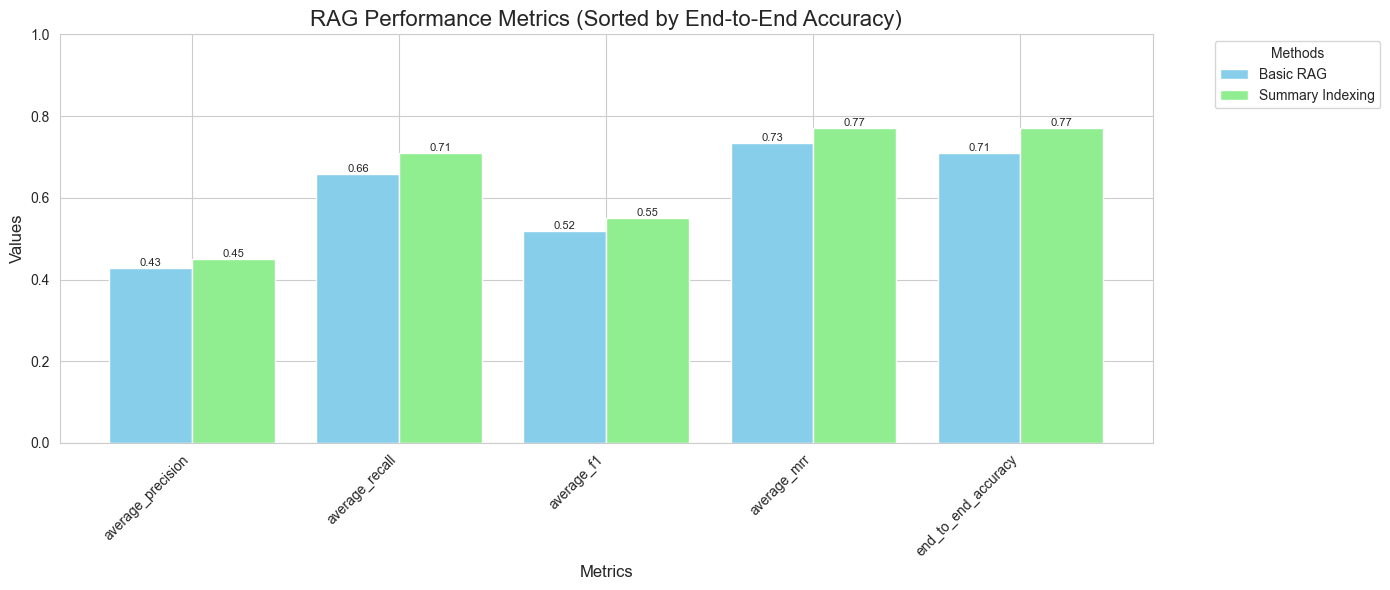

In [43]:
plot_performance('evaluation/json_results', ['Basic RAG', 'Summary Indexing'])

## Level 3: Re-ranking 

The `rerank_results` function uses Claude to reassess and reorder the initially retrieved documents:

- It presents Claude with the query and summaries of all retrieved documents.

- Claude is asked to select and rank the most relevant documents.

- The function parses Claude's response to get the reranked document indices.

- It includes fallback mechanisms in case of errors or insufficient results.

- Finally, it assigns descending relevance scores to the reranked results.

The `retrieve_advanced` function implements the new retrieval pipeline:

- We initially retrieve more documents than needed (default 20, configurable via initial_k) from the vector database.

- We then use the rerank_results function to refine this larger set down to the most relevant documents (default 3, configurable via k).

- Finally, it generates a new context string from these reranked documents.

Our evaluations show significant improvements:

- Accuracy increased from 78% in our previous system to 85%.

- Precision was improved by using our re-ranker to reduce the number of documents shown to the LLM.

- MRR (Mean Reciprocal Rank) was likely improved by asking Claude to rank the relevance of each document in order.

In [44]:
from typing import List, Dict

def rerank_results(query: str, results: List[Dict], k: int = 5) -> List[Dict]:
    # Prepare the summaries with their indices
    summaries = []
    print(len(results))

    for i, result in enumerate(results):
        summary = f"[{i}] Document Summary: {result['metadata']['summary']}"
        summaries.append(summary)
    joined_summaries = "\n\n".join(summaries)
    
    prompt = f"""
    Query: {query}
    You are about to be given a group of documents, each preceded by its index number in square brackets. Your task is to select the only {k} most relevant documents from the list to help us answer the query.
    
    <documents>
    {joined_summaries}
    </documents>

    Output only the indices of {k} most relevant documents in order of relevance, separated by commas, enclosed in XML tags here:
    <relevant_indices>put the numbers of your indices here, seeparted by commas</relevant_indices>
    """
    try:
        response = client.messages.create(
            model="claude-3-haiku-20240307",
            max_tokens=50,
            messages=[{"role": "user", "content": prompt}, {"role": "assistant", "content": "<relevant_indices>"}],
            temperature=0,
            stop_sequences=["</relevant_indices>"]
        )
        
        # Extract the indices from the response
        response_text = response.content[0].text.strip()
        indices_str = response_text
        relevant_indices = []
        for idx in indices_str.split(','):
            try:
                relevant_indices.append(int(idx.strip()))
            except ValueError:
                continue  # Skip invalid indices
        print(indices_str)
        print(relevant_indices)
        # If we didn't get enough valid indices, fall back to the top k by original order
        if len(relevant_indices) == 0:
            relevant_indices = list(range(min(k, len(results))))
        
        # Ensure we don't have out-of-range indices
        relevant_indices = [idx for idx in relevant_indices if idx < len(results)]
        
        # Return the reranked results
        reranked_results = [results[idx] for idx in relevant_indices[:k]]
        # Assign descending relevance scores
        for i, result in enumerate(reranked_results):
            result['relevance_score'] = 100 - i  # Highest score is 100, decreasing by 1 for each rank
        
        return reranked_results
    
    except Exception as e:
        print(f"An error occurred during reranking: {str(e)}")
        # Fall back to returning the top k results without reranking
        return results[:k]

def retrieve_advanced(query: str, db: SummaryIndexedVectorDB, k: int = 3, initial_k: int = 20) -> Tuple[List[Dict], str]:
    # Step 1: Get initial results
    initial_results = db.search(query, k=initial_k)

    # Step 2: Re-rank results
    reranked_results = rerank_results(query, initial_results, k=k)
    
    # Step 3: Generate new context string from re-ranked results
    new_context = ""
    for result in reranked_results:
        chunk = result['metadata']
        new_context += f"\n <document> \n {chunk['chunk_heading']}\n\n{chunk['text']} \n </document> \n"
     
    return reranked_results, new_context

# The answer_query_advanced function remains unchanged
def answer_query_advanced(query: str, db: SummaryIndexedVectorDB):
    documents, context = retrieve_advanced(query, db)
    prompt = f"""
    You have been tasked with helping us to answer the following query: 
    <query>
    {query}
    </query>
    You have access to the following documents which are meant to provide context as you answer the query:
    <documents>
    {context}
    </documents>
    Please remain faithful to the underlying context, and only deviate from it if you are 100% sure that you know the answer already. 
    Answer the question now, and avoid providing preamble such as 'Here is the answer', etc
    """
    response = client.messages.create(
        model="claude-3-haiku-20240307",
        max_tokens=2500,
        messages=[{"role": "user", "content": prompt}],
        temperature=0
    )
    return response.content[0].text

In [45]:
# Initialize the SummaryIndexedVectorDB
level_three_db = SummaryIndexedVectorDB("anthropic_docs_v3")
level_three_db.load_data('data/anthropic_summary_indexed_docs.json')

import pandas as pd

# Run the evaluations
avg_precision, avg_recall, avg_mrr, f1, precisions, recalls, mrrs  = evaluate_retrieval(retrieve_advanced, eval_data, level_three_db)
e2e_accuracy, e2e_results = evaluate_end_to_end(answer_query_advanced, level_two_db, eval_data)

# Create a DataFrame
df = pd.DataFrame({
    'question': [item['question'] for item in eval_data],
    'retrieval_precision': precisions,
    'retrieval_recall': recalls,
    'retrieval_mrr': mrrs,
    'e2e_correct': e2e_results
})

# Save to CSV
df.to_csv('evaluation/csvs/evaluation_results_detailed_level_three.csv', index=False)
print("Detailed results saved to evaluation_results_detailed_level_three.csv")

# Plot the results
# Print the results
print(f"Average Precision: {avg_precision:.4f}")
print(f"Average Recall: {avg_recall:.4f}")
print(f"Average F1: {f1:.4f}")
print(f"Average Mean Reciprocal Rank: {avg_mrr:4f}")
print(f"End-to-End Accuracy: {e2e_accuracy:.4f}")

# Save the results to a file
with open('evaluation/json_results/evaluation_results_level_three.json', 'w') as f:
    json.dump({
        "name": "Summary Indexing + Re-Ranking",
        "average_precision": avg_precision,
        "average_recall": avg_recall,
        "average_f1": f1,
        "average_mrr": avg_mrr,
        "end_to_end_accuracy": e2e_accuracy
    }, f, indent=2)

print("Evaluation complete. Results saved to evaluation_results_level_three.json, evaluation_results_detailed_level_three.csv, and evaluation_results_level_three.png")

Vector database loaded and saved.


Evaluating Retrieval:   0%|          | 0/100 [00:00<?, ?it/s]

18


Evaluating Retrieval:   1%|          | 1/100 [00:01<01:49,  1.11s/it]

0,2,7
[0, 2, 7]
15


Evaluating Retrieval:   2%|▏         | 2/100 [00:02<01:40,  1.02s/it]

0,1,2
[0, 1, 2]
20


Evaluating Retrieval:   3%|▎         | 3/100 [00:02<01:32,  1.04it/s]

1,13,15
[1, 13, 15]
20


Evaluating Retrieval:   4%|▍         | 4/100 [00:03<01:27,  1.10it/s]

0,1,6
[0, 1, 6]
8


Evaluating Retrieval:   5%|▌         | 5/100 [00:04<01:24,  1.12it/s]

0,1,2
[0, 1, 2]
11


Evaluating Retrieval:   6%|▌         | 6/100 [00:05<01:26,  1.09it/s]

0,1,2
[0, 1, 2]
20


Evaluating Retrieval:   7%|▋         | 7/100 [00:06<01:29,  1.04it/s]

0,5,11
[0, 5, 11]
9


Evaluating Retrieval:   8%|▊         | 8/100 [00:07<01:24,  1.09it/s]

0,1,6
[0, 1, 6]
20


Evaluating Retrieval:   9%|▉         | 9/100 [00:08<01:22,  1.10it/s]

1,19,10
[1, 19, 10]
10


Evaluating Retrieval:  10%|█         | 10/100 [00:09<01:22,  1.09it/s]

2,0,1
[2, 0, 1]
Processed 10/100 items. Current Avg Precision: 0.5000, Avg Recall: 0.8000, Avg MRR: 1.0000
20


Evaluating Retrieval:  11%|█         | 11/100 [00:10<01:24,  1.06it/s]

0,4,11
[0, 4, 11]
8


Evaluating Retrieval:  12%|█▏        | 12/100 [00:11<01:18,  1.13it/s]

0,3,2
[0, 3, 2]
20


Evaluating Retrieval:  13%|█▎        | 13/100 [00:11<01:16,  1.14it/s]

4,3,6
[4, 3, 6]
20


Evaluating Retrieval:  14%|█▍        | 14/100 [00:13<01:20,  1.07it/s]

9,5,0
[9, 5, 0]
20


Evaluating Retrieval:  15%|█▌        | 15/100 [00:13<01:20,  1.06it/s]

2,7,12
[2, 7, 12]
7


Evaluating Retrieval:  16%|█▌        | 16/100 [00:14<01:18,  1.07it/s]

0,1,2
[0, 1, 2]
19


Evaluating Retrieval:  17%|█▋        | 17/100 [00:15<01:15,  1.10it/s]

1, 3, 4
[1, 3, 4]
9


Evaluating Retrieval:  18%|█▊        | 18/100 [00:16<01:15,  1.09it/s]

1, 5, 3
[1, 5, 3]
5


Evaluating Retrieval:  19%|█▉        | 19/100 [00:17<01:12,  1.12it/s]

0,1,3
[0, 1, 3]
20


Evaluating Retrieval:  20%|██        | 20/100 [00:18<01:11,  1.11it/s]

0,17,18
[0, 17, 18]
Processed 20/100 items. Current Avg Precision: 0.4333, Avg Recall: 0.7250, Avg MRR: 0.9417
9


Evaluating Retrieval:  21%|██        | 21/100 [00:19<01:16,  1.03it/s]

0,5,6
[0, 5, 6]
17


Evaluating Retrieval:  22%|██▏       | 22/100 [00:20<01:16,  1.02it/s]

1,8,9
[1, 8, 9]
16


Evaluating Retrieval:  23%|██▎       | 23/100 [00:21<01:15,  1.02it/s]

0,1,2
[0, 1, 2]
20


Evaluating Retrieval:  24%|██▍       | 24/100 [00:22<01:13,  1.03it/s]

0,11,14
[0, 11, 14]
20


Evaluating Retrieval:  25%|██▌       | 25/100 [00:23<01:12,  1.03it/s]

0,14,16
[0, 14, 16]
15


Evaluating Retrieval:  26%|██▌       | 26/100 [00:24<01:09,  1.06it/s]

0,1,4
[0, 1, 4]
6


Evaluating Retrieval:  27%|██▋       | 27/100 [00:25<01:06,  1.09it/s]

1,3,4
[1, 3, 4]
9


Evaluating Retrieval:  28%|██▊       | 28/100 [00:26<01:04,  1.12it/s]

1,2,4
[1, 2, 4]
18


Evaluating Retrieval:  29%|██▉       | 29/100 [00:26<01:01,  1.15it/s]

1,2,11
[1, 2, 11]
20


Evaluating Retrieval:  30%|███       | 30/100 [00:27<01:06,  1.05it/s]

0,4,13
[0, 4, 13]
Processed 30/100 items. Current Avg Precision: 0.4667, Avg Recall: 0.7556, Avg MRR: 0.9389
9


Evaluating Retrieval:  31%|███       | 31/100 [00:28<01:04,  1.07it/s]

0,3,4
[0, 3, 4]
9


Evaluating Retrieval:  32%|███▏      | 32/100 [00:29<01:02,  1.09it/s]

1,2,0
[1, 2, 0]
6


Evaluating Retrieval:  33%|███▎      | 33/100 [00:30<01:03,  1.06it/s]

1,0,3
[1, 0, 3]
20


Evaluating Retrieval:  34%|███▍      | 34/100 [00:31<01:01,  1.07it/s]

0, 1, 3
[0, 1, 3]
20


Evaluating Retrieval:  35%|███▌      | 35/100 [00:32<00:59,  1.09it/s]

0,1,7
[0, 1, 7]
16


Evaluating Retrieval:  36%|███▌      | 36/100 [00:33<01:00,  1.06it/s]

0,1,2
[0, 1, 2]
10


Evaluating Retrieval:  37%|███▋      | 37/100 [00:34<00:59,  1.06it/s]

4,5,8
[4, 5, 8]
20


Evaluating Retrieval:  38%|███▊      | 38/100 [00:35<00:59,  1.03it/s]

4,11,3
[4, 11, 3]
2


Evaluating Retrieval:  39%|███▉      | 39/100 [00:37<01:12,  1.19s/it]

1, 0, 0
[1, 0, 0]
20


Evaluating Retrieval:  40%|████      | 40/100 [00:38<01:06,  1.11s/it]

2,6,16
[2, 6, 16]
Processed 40/100 items. Current Avg Precision: 0.4667, Avg Recall: 0.7292, Avg MRR: 0.8875
20


Evaluating Retrieval:  41%|████      | 41/100 [00:39<01:02,  1.06s/it]

0,1,5
[0, 1, 5]
11


Evaluating Retrieval:  42%|████▏     | 42/100 [00:40<01:01,  1.06s/it]

0,8,2
[0, 8, 2]
12


Evaluating Retrieval:  43%|████▎     | 43/100 [00:41<00:59,  1.05s/it]

1,9,0
[1, 9, 0]
4


Evaluating Retrieval:  44%|████▍     | 44/100 [00:42<00:57,  1.02s/it]

0,1,3
[0, 1, 3]
20


Evaluating Retrieval:  45%|████▌     | 45/100 [00:43<01:01,  1.11s/it]

1,3,18
[1, 3, 18]
20


Evaluating Retrieval:  46%|████▌     | 46/100 [00:44<00:59,  1.11s/it]

0,4,5
[0, 4, 5]
6


Evaluating Retrieval:  47%|████▋     | 47/100 [00:45<00:56,  1.06s/it]

0,1,3
[0, 1, 3]
20


Evaluating Retrieval:  48%|████▊     | 48/100 [00:46<00:52,  1.00s/it]

1,0,3
[1, 0, 3]
20


Evaluating Retrieval:  49%|████▉     | 49/100 [00:47<00:52,  1.03s/it]

2,1,0
[2, 1, 0]
4


Evaluating Retrieval:  50%|█████     | 50/100 [00:48<00:52,  1.05s/it]

0,1,2
[0, 1, 2]
Processed 50/100 items. Current Avg Precision: 0.4600, Avg Recall: 0.7333, Avg MRR: 0.8733
8


Evaluating Retrieval:  51%|█████     | 51/100 [00:49<00:48,  1.02it/s]

0,1,3
[0, 1, 3]
4


Evaluating Retrieval:  52%|█████▏    | 52/100 [00:50<00:50,  1.04s/it]

0,3,1
[0, 3, 1]
17


Evaluating Retrieval:  53%|█████▎    | 53/100 [00:51<00:45,  1.03it/s]

1, 2, 3
[1, 2, 3]
20


Evaluating Retrieval:  54%|█████▍    | 54/100 [00:52<00:44,  1.04it/s]

1, 4, 5
[1, 4, 5]
20


Evaluating Retrieval:  55%|█████▌    | 55/100 [00:53<00:44,  1.02it/s]

0,1,8
[0, 1, 8]
20


Evaluating Retrieval:  56%|█████▌    | 56/100 [00:54<00:46,  1.07s/it]

0,2,6
[0, 2, 6]
20


Evaluating Retrieval:  57%|█████▋    | 57/100 [00:55<00:45,  1.06s/it]

0,14,4
[0, 14, 4]
20


Evaluating Retrieval:  58%|█████▊    | 58/100 [00:56<00:42,  1.01s/it]

0,1,2
[0, 1, 2]
7


Evaluating Retrieval:  59%|█████▉    | 59/100 [00:57<00:41,  1.01s/it]

0,1,3
[0, 1, 3]
20


Evaluating Retrieval:  60%|██████    | 60/100 [00:58<00:39,  1.03it/s]

1,5,15
[1, 5, 15]
Processed 60/100 items. Current Avg Precision: 0.4611, Avg Recall: 0.7444, Avg MRR: 0.8833
6


Evaluating Retrieval:  61%|██████    | 61/100 [00:59<00:42,  1.09s/it]

2,4,1
[2, 4, 1]
20


Evaluating Retrieval:  62%|██████▏   | 62/100 [01:00<00:40,  1.06s/it]

1,7,11
[1, 7, 11]
5


Evaluating Retrieval:  63%|██████▎   | 63/100 [01:02<00:47,  1.28s/it]

0,1,3
[0, 1, 3]
20


Evaluating Retrieval:  64%|██████▍   | 64/100 [01:03<00:43,  1.21s/it]

1,2,4
[1, 2, 4]
7


Evaluating Retrieval:  65%|██████▌   | 65/100 [01:04<00:42,  1.20s/it]

2,3,4
[2, 3, 4]
20


Evaluating Retrieval:  66%|██████▌   | 66/100 [01:05<00:39,  1.16s/it]

2,15,12
[2, 15, 12]
16


Evaluating Retrieval:  67%|██████▋   | 67/100 [01:06<00:36,  1.11s/it]

1,3,4
[1, 3, 4]
5


Evaluating Retrieval:  68%|██████▊   | 68/100 [01:07<00:33,  1.04s/it]

0, 2, 3
[0, 2, 3]
20


Evaluating Retrieval:  69%|██████▉   | 69/100 [01:08<00:30,  1.01it/s]

2,1,3
[2, 1, 3]
20


Evaluating Retrieval:  70%|███████   | 70/100 [01:09<00:29,  1.03it/s]

0,13,15
[0, 13, 15]
Processed 70/100 items. Current Avg Precision: 0.4429, Avg Recall: 0.7167, Avg MRR: 0.8548
6


Evaluating Retrieval:  71%|███████   | 71/100 [01:10<00:29,  1.00s/it]

1,0,2
[1, 0, 2]
6


Evaluating Retrieval:  72%|███████▏  | 72/100 [01:11<00:26,  1.06it/s]

0,1,2
[0, 1, 2]
17


Evaluating Retrieval:  73%|███████▎  | 73/100 [01:12<00:27,  1.02s/it]

0,3,8
[0, 3, 8]
20


Evaluating Retrieval:  74%|███████▍  | 74/100 [01:13<00:27,  1.06s/it]

3,1,16
[3, 1, 16]
20


Evaluating Retrieval:  75%|███████▌  | 75/100 [01:14<00:25,  1.02s/it]

0,3,4
[0, 3, 4]
20


Evaluating Retrieval:  76%|███████▌  | 76/100 [01:15<00:23,  1.02it/s]

3,0,2
[3, 0, 2]
20


Evaluating Retrieval:  77%|███████▋  | 77/100 [01:16<00:22,  1.04it/s]

0,1,18
[0, 1, 18]
20


Evaluating Retrieval:  78%|███████▊  | 78/100 [01:17<00:20,  1.07it/s]

0,4,13
[0, 4, 13]
20


Evaluating Retrieval:  79%|███████▉  | 79/100 [01:18<00:21,  1.03s/it]

10,19,6
[10, 19, 6]
20


Evaluating Retrieval:  80%|████████  | 80/100 [01:19<00:19,  1.04it/s]

0,1,10
[0, 1, 10]
Processed 80/100 items. Current Avg Precision: 0.4458, Avg Recall: 0.7208, Avg MRR: 0.8479
12


Evaluating Retrieval:  81%|████████  | 81/100 [01:20<00:19,  1.01s/it]

2,3,6
[2, 3, 6]
11


Evaluating Retrieval:  82%|████████▏ | 82/100 [01:21<00:17,  1.01it/s]

0, 3, 9
[0, 3, 9]
13


Evaluating Retrieval:  83%|████████▎ | 83/100 [01:22<00:16,  1.03it/s]

0, 2, 6
[0, 2, 6]
12


Evaluating Retrieval:  84%|████████▍ | 84/100 [01:23<00:15,  1.02it/s]

1, 10, 0
[1, 10, 0]
20


Evaluating Retrieval:  85%|████████▌ | 85/100 [01:24<00:14,  1.02it/s]

0,4,10
[0, 4, 10]
20


Evaluating Retrieval:  86%|████████▌ | 86/100 [01:25<00:13,  1.02it/s]

3,1,16
[3, 1, 16]
20


Evaluating Retrieval:  87%|████████▋ | 87/100 [01:26<00:12,  1.05it/s]

0,5,11
[0, 5, 11]
20


Evaluating Retrieval:  88%|████████▊ | 88/100 [01:27<00:12,  1.04s/it]

1,12,14
[1, 12, 14]
20


Evaluating Retrieval:  89%|████████▉ | 89/100 [01:28<00:10,  1.02it/s]

0,1,11
[0, 1, 11]
20


Evaluating Retrieval:  90%|█████████ | 90/100 [01:29<00:10,  1.02s/it]

0,1,3
[0, 1, 3]
Processed 90/100 items. Current Avg Precision: 0.4407, Avg Recall: 0.7111, Avg MRR: 0.8519
6


Evaluating Retrieval:  91%|█████████ | 91/100 [01:30<00:09,  1.00s/it]

1,2,4
[1, 2, 4]
7


Evaluating Retrieval:  92%|█████████▏| 92/100 [01:31<00:07,  1.05it/s]

0,1,5
[0, 1, 5]
20


Evaluating Retrieval:  93%|█████████▎| 93/100 [01:32<00:06,  1.03it/s]

1,2,11
[1, 2, 11]
5


Evaluating Retrieval:  94%|█████████▍| 94/100 [01:33<00:05,  1.01it/s]

0,1,2
[0, 1, 2]
20


Evaluating Retrieval:  95%|█████████▌| 95/100 [01:34<00:05,  1.02s/it]

1, 13, 14
[1, 13, 14]
20


Evaluating Retrieval:  96%|█████████▌| 96/100 [01:35<00:04,  1.01s/it]

1,0,2
[1, 0, 2]
20


Evaluating Retrieval:  97%|█████████▋| 97/100 [01:36<00:02,  1.02it/s]

1,4,15
[1, 4, 15]
20


Evaluating Retrieval:  98%|█████████▊| 98/100 [01:37<00:02,  1.04s/it]

4,14,7
[4, 14, 7]
1


Evaluating Retrieval:  99%|█████████▉| 99/100 [01:38<00:00,  1.03it/s]

0
[0]
17


Evaluating Retrieval: 100%|██████████| 100/100 [01:39<00:00,  1.01it/s]


0,3,8
[0, 3, 8]
Processed 100/100 items. Current Avg Precision: 0.4433, Avg Recall: 0.7033, Avg MRR: 0.8500


Evaluating End-to-End:   0%|          | 0/100 [00:00<?, ?it/s]

18
0,2,7
[0, 2, 7]


Evaluating End-to-End:   1%|          | 1/100 [00:07<11:45,  7.13s/it]


<content>
<explanation>The Generated Answer is correct. It contains all the essential elements from the Correct Answer - namely that you need to click the 'Add Test Case' button and fill in values for variables to create different test cases. The Generated Answer actually provides more detail by mentioning you can re-run the evaluation suite, but this additional information doesn't contradict the core information. The key steps and process are fundamentally the same between both answers. There are no critical missing pieces or contradictions between the two answers.</explanation>
<is_correct>true</is_correct>
</content>

15
0,1,2
[0, 1, 2]


Evaluating End-to-End:   2%|▏         | 2/100 [00:13<10:57,  6.71s/it]


<content>
<explanation>The Generated Answer is correct. It captures the key points from the Correct Answer:
1. It correctly identifies Voyage AI as Anthropic's recommended embeddings provider
2. It mentions that Voyage AI offers customized/domain-specific models (including specific examples for finance and healthcare)
3. It notes that Voyage AI provides bespoke fine-tuned models for individual customers

While the Generated Answer provides more specific details about Voyage AI's model offerings than the Correct Answer, this additional information doesn't contradict anything in the Correct Answer - it simply elaborates further. The core substance and main points are aligned between both answers.</explanation>
<is_correct>true</is_correct>
</content>

20
1,13,15
[1, 13, 15]


Evaluating End-to-End:   3%|▎         | 3/100 [00:22<12:32,  7.75s/it]


<content>
<explanation>The Generated Answer is correct. It covers all the key success metrics mentioned in the Correct Answer (accuracy, F1 score, consistency, structure, speed, bias and fairness) and even provides more detailed explanations for each metric. Both answers emphasize the importance of choosing the right model to balance performance and latency requirements. While the Generated Answer goes into more detail about specific latency considerations (baseline latency and TTFT), this additional information doesn't contradict the Correct Answer but rather expands upon it. The core message about evaluating performance metrics and selecting an appropriate model to reduce latency while meeting performance requirements is consistent between both answers.</explanation>
<is_correct>true</is_correct>
</content>

20
0,1,6
[0, 1, 6]


Evaluating End-to-End:   4%|▍         | 4/100 [00:30<12:16,  7.67s/it]


<content>
<explanation>The Generated Answer is correct as it captures the same two key advantages of Claude for Sheets mentioned in the Correct Answer:

1. Both answers highlight the ability to test prompts in parallel across evaluation suites, noting this is more efficient than sequential chained prompts.

2. Both answers mention that Claude for Sheets is better suited for office tasks like survey analysis and data processing compared to chained prompts.

The Generated Answer essentially conveys the same information as the Correct Answer, just with slightly different phrasing. There are no missing critical pieces of information or contradictions between the two answers.</explanation>
<is_correct>true</is_correct>
</content>

8
0,1,2
[0, 1, 2]


Evaluating End-to-End:   5%|▌         | 5/100 [00:35<10:59,  6.95s/it]


<content>
<explanation>The Generated Answer is correct. Both answers convey the same core information - that missing "\n\nHuman:" and "\n\nAssistant:" turns in the Text Completions API prompt will result in an API error. The Generated Answer provides some additional context about formatting and ordering, but this extra detail doesn't contradict or detract from the main point. The essential message about what happens when these turns are missing is identical between both answers.</explanation>
<is_correct>true</is_correct>
</content>

11
0,1,2
[0, 1, 2]


Evaluating End-to-End:   6%|▌         | 6/100 [00:44<11:47,  7.53s/it]


<content>
<explanation>The Generated Answer is correct. It captures all the key points from the Correct Answer and even provides additional detail while maintaining the same core message. Both answers emphasize that:

1. Tool use requests are priced the same way as regular requests (based on total tokens)
2. There are additional tokens involved in tool use requests
3. These additional tokens come from various sources (tools parameter, tool use blocks, tool results, system prompt)
4. All these additional tokens contribute to the total cost

The Generated Answer actually provides more granular detail about the token sources and even mentions specific token ranges for the system prompt, but this additional detail doesn't contradict the Correct Answer - it simply elaborates on it. The fundamental message about how tool use impacts pricing is consistent between both answers.</explanation>
<is_correct>true</is_correct>
</content>

20
0,5,11
[0, 5, 11]


Evaluating End-to-End:   7%|▋         | 7/100 [00:49<10:36,  6.84s/it]


<content>
<explanation>The Generated Answer is correct. It contains all the essential information from the Correct Answer - specifically the release date (June 27th, 2024) and what features will be available (API usage, billing details, and rate limits). While the Correct Answer provides slightly more detail by mentioning the specific tabs (Usage, Cost, and Rate Limits), this is a minor detail that doesn't change the core meaning. Both answers convey the same fundamental information about what will be available and when.</explanation>
<is_correct>true</is_correct>
</content>

9
0,1,6
[0, 1, 6]


Evaluating End-to-End:   8%|▊         | 8/100 [00:57<10:49,  7.05s/it]


<content>
<explanation>The Generated Answer is correct as it captures both key factors mentioned in the Correct Answer:

1. It addresses the need to consider whether the task requires in-depth thinking that a human would need to work through (mentioned in both answers)

2. It acknowledges the impact on latency due to increased output length (mentioned in both answers)

While the Generated Answer provides more detail and elaboration around these points (like mentioning TTFT and giving specific examples of complex tasks), the core substance matches the Correct Answer. The additional detail doesn't contradict the Correct Answer but rather expands upon it in a helpful way.

There are no critical pieces of information from the Correct Answer missing in the Generated Answer, and there are no contradictions between the two answers.</explanation>
<is_correct>true</is_correct>
</content>

20
1,19,10
[1, 19, 10]


Evaluating End-to-End:   9%|▉         | 9/100 [01:05<11:04,  7.30s/it]


<content>
<explanation>The Generated Answer is essentially correct. While it provides much more detailed steps and implementation guidance than the Correct Answer, the core concept remains the same - that Claude can be used to summarize PDF documents to make them easier to digest. The Generated Answer expands on HOW to do this, but doesn't contradict or miss any critical information from the Correct Answer. Both answers convey the fundamental capability of Claude to help users understand PDF content through summarization. The additional detail in the Generated Answer doesn't change or contradict the basic truth presented in the Correct Answer.</explanation>
<is_correct>true</is_correct>
</content>

10
2,0,1
[2, 0, 1]


Evaluating End-to-End:  10%|█         | 10/100 [01:10<09:58,  6.65s/it]


<content>
<explanation>The Generated Answer is correct. Both answers indicate that you can view the API rate limits in a Rate Limits tab within Anthropic's console interface. The only difference is minor wording variations ("Developer Console" vs "Anthropic Console" and the addition of the word "new"), but the core information about being able to view rate limits in a dedicated Rate Limits tab is consistent between both answers. There are no critical missing pieces of information or contradictions between the two answers.</explanation>
<is_correct>true</is_correct>
</content>

Processed 10/100 questions. Current Accuracy: 1.0000
20
0,4,11
[0, 4, 11]


Evaluating End-to-End:  11%|█         | 11/100 [01:18<10:34,  7.13s/it]


<content>
<explanation>The generated answer is incorrect because it misses a critical piece of information from the correct answer - specifically, the measurement of average cost per classification. While the generated answer does mention the 95th percentile response time (which matches the correct answer) and provides many additional metrics that could be useful, it fails to mention cost as a key performance metric. Since the correct answer explicitly states that both response time AND cost per classification are important metrics beyond accuracy, and the generated answer omits cost entirely, it must be marked as incorrect despite providing other potentially valuable metrics.</explanation>
<is_correct>false</is_correct>
</content>

8
0,3,2
[0, 3, 2]


Evaluating End-to-End:  12%|█▏        | 12/100 [01:27<11:14,  7.66s/it]


<content>
<explanation>The Generated Answer is correct. It captures the key distinction between how system prompts are specified in both APIs:

1. For Text Completions API: Both answers indicate that the system prompt goes before the first "\n\nHuman:" turn in the prompt text
2. For Messages API: Both answers specify that the system prompt is set using a dedicated "system" parameter in the API request

The Generated Answer actually provides helpful concrete examples to illustrate these concepts, which goes beyond but doesn't contradict the Correct Answer. The substance and core information about how to specify system prompts in both APIs is consistent between both answers.</explanation>
<is_correct>true</is_correct>
</content>

20
4,3,6
[4, 3, 6]


ERROR:root:XML parsing error: mismatched tag: line 13, column 2
Evaluating End-to-End:  13%|█▎        | 13/100 [01:35<11:09,  7.70s/it]


<content>
<explanation>
The Generated Answer is essentially correct as it captures the key concept of combining XML tags with chain of thought reasoning to create structured prompts. Both answers emphasize:

1. The use of XML tags for structure (<thinking>, <answer>, etc.)
2. The incorporation of step-by-step reasoning processes
3. The goal of creating clear, well-structured prompts for better performance

While the Generated Answer provides more specific details about nesting tags and maintaining consistency, and the Correct Answer includes a specific example of a prompt instruction, these are just different ways of explaining the same core concept. There are no contradictions between the answers, and no critical information from the Correct Answer is missing from the Generated Answer.

The Generated Answer even demonstrates the concept it's explaining by using the XML tags and chain of thought structure in its own response, which reinforces the correct understanding of the concept.


Evaluating End-to-End:  14%|█▍        | 14/100 [01:40<10:06,  7.05s/it]


<content>
<explanation>The Generated Answer is correct. It contains all the same key information as the Correct Answer, just presented in a slightly different format:

1. Both answers identify the same three metrics being measured
2. Both provide the exact same values for each metric:
   - 89.01% accuracy
   - 1.61 seconds for 95th percentile response time
   - $0.0004 for average cost per request/classification

The only difference is in minor wording choices (e.g., "Classification" vs "request routing") which doesn't affect the substantive meaning. The Generated Answer captures all the critical information from the Correct Answer without any contradictions or omissions.</explanation>
<is_correct>true</is_correct>
</content>

20
2,7,12
[2, 7, 12]


Evaluating End-to-End:  15%|█▌        | 15/100 [01:47<09:58,  7.04s/it]


<content>
<explanation>The Generated Answer is correct. It contains all the key elements from the Correct Answer:
1. Having clear success criteria
2. Having ways to empirically test against those criteria
3. Having a first draft prompt to improve

The Generated Answer actually provides slightly more detail by mentioning specific documentation sections, but the core substance perfectly matches the Correct Answer. There are no contradictions or missing critical pieces of information. The minor differences in phrasing (like listing the items with numbers vs. combining them in a sentence) don't affect the correctness of the answer.</explanation>
<is_correct>true</is_correct>
</content>

7
0,1,2
[0, 1, 2]


Evaluating End-to-End:  16%|█▌        | 16/100 [01:54<09:32,  6.81s/it]


<content>
<explanation>The Generated Answer is correct. It captures the key distinction between how mid-response prompting works in both APIs:
1. For Text Completions API: You can pre-fill part of Claude's response in the prompt
2. For Messages API: You continue responses by setting the last message to have the "assistant" role

The Generated Answer conveys the same essential information as the Correct Answer, just with slightly different wording. There are no missing critical pieces of information and no contradictions between the two answers. The substance and technical accuracy are equivalent.</explanation>
<is_correct>true</is_correct>
</content>

19
1, 3, 4
[1, 3, 4]


Evaluating End-to-End:  17%|█▋        | 17/100 [02:02<10:10,  7.36s/it]


<content>
<explanation>The Generated Answer is correct. Both answers convey the same core message: that Claude's responses are more insightful, structured, and actionable when given a specific role (CFO) compared to not having a role. The Generated Answer actually provides more detailed examples and specifics about how the role-based response differs, but this additional detail doesn't contradict the Correct Answer - it simply elaborates on it. The key points about the response being more structured, insightful, and actionable are present in both answers. There are no critical omissions or contradictions between the two answers.</explanation>
<is_correct>true</is_correct>
</content>

9
1, 5, 3
[1, 5, 3]


Evaluating End-to-End:  18%|█▊        | 18/100 [02:11<10:28,  7.66s/it]


<content>
<explanation>The Generated Answer is correct as it covers all the essential elements from the Correct Answer and even provides additional helpful detail. Both answers mention key quantitative metrics like F1 score, accuracy, precision, and recall. Both answers also emphasize that specific targets should be determined based on industry benchmarks, prior experiments, and expert knowledge. The Generated Answer expands on this with more specific examples and additional metrics like response time and uptime, but this additional detail doesn't contradict the core message of the Correct Answer. The substance and main points align between both answers, with the Generated Answer effectively elaborating on the core concepts presented in the Correct Answer.</explanation>
<is_correct>true</is_correct>
</content>

5
0,1,3
[0, 1, 3]


ERROR:root:XML parsing error: mismatched tag: line 9, column 182
Evaluating End-to-End:  19%|█▉        | 19/100 [02:15<09:13,  6.83s/it]


<content>
<explanation>The Generated Answer is correct. It captures the key elements from the Correct Answer:
1. The core concept of combining XML tags with other prompt engineering techniques
2. Specifically mentions multishot prompting using <examples> tags
3. Mentions chain of thought using <thinking> and <answer> tags
4. Notes that this creates "super-structured, high-performance prompts"

While the wording is slightly different, the substance and meaning are identical. There are no missing critical pieces of information and no contradictions between the two answers.</explanation>
<is_correct>true</is_correct>
</content>

20
0,17,18
[0, 17, 18]


Evaluating End-to-End:  20%|██        | 20/100 [02:23<09:26,  7.09s/it]


<content>
<explanation>The Generated Answer is correct as it captures all the essential elements from the Correct Answer and even provides additional helpful detail while maintaining the core concepts. Both answers emphasize:

1. The need to provide a detailed rubric
2. The importance of giving the LLM both the output to grade and the rubric
3. Having the LLM evaluate against the criteria
4. Getting a simple correct/incorrect result

While the Generated Answer is more detailed and breaks down the process into more specific steps, it doesn't contradict anything in the Correct Answer. Rather, it expands upon the same fundamental approach. The additional detail about aggregating results and structuring prompts simply provides more implementation guidance while staying true to the core concept presented in the Correct Answer.</explanation>
<is_correct>true</is_correct>
</content>

Processed 20/100 questions. Current Accuracy: 0.8500
9
0,5,6
[0, 5, 6]


Evaluating End-to-End:  21%|██        | 21/100 [02:33<10:14,  7.78s/it]


<content>
<explanation>The generated answer contains all the essential steps from the correct answer and actually provides more detailed information. The core steps are the same:
1. Subscribe to the model package on AWS Marketplace
2. Select and agree to terms
3. Get the Product ARN for your region
4. Create a JupyterLab space in SageMaker Studio
5. Upload and follow Voyage's notebook for deployment

While the generated answer includes additional information about alternative methods (HTTP API and Python package), this extra information doesn't contradict the correct answer - it just provides additional deployment options. The fundamental process for AWS Marketplace deployment matches the correct answer.</explanation>
<is_correct>true</is_correct>
</content>

17
1,8,9
[1, 8, 9]


Evaluating End-to-End:  22%|██▏       | 22/100 [02:39<09:43,  7.48s/it]


<content>
<explanation>The generated answer is incorrect because it misses several critical elements from the correct answer and provides different guidance. The key missing elements are:

1. The instruction to use a single tool (not multiple tools)
2. The need to set tool_choice to explicitly instruct the model to use that tool
3. The importance of writing tool descriptions from the model's perspective

The generated answer instead focuses on different aspects like providing detailed descriptions, prioritizing descriptions over examples, and defining output formats. While these might be helpful general practices, they don't address the specific requirements for using tools to get JSON output as outlined in the correct answer. The generated answer doesn't contradict the correct answer directly, but it fails to include the essential technical requirements that are core to the correct implementation.</explanation>
<is_correct>false</is_correct>
</content>

16
0,1,2
[0, 1, 2]


Evaluating End-to-End:  23%|██▎       | 23/100 [02:47<09:41,  7.55s/it]


<content>
<explanation>The Generated Answer is correct and actually provides more detailed information than the Correct Answer while maintaining all the key points. The Generated Answer covers all the essential elements mentioned in the Correct Answer:
1. Vision capabilities
2. Improved speed/performance
3. Enhanced intelligence/capabilities
4. More recent/up-to-date capabilities (implied by it being the newer model)

The Generated Answer adds additional specific details about context windows and pricing, but these additions don't contradict the Correct Answer - they simply provide more detail. The core substance of both answers aligns perfectly, with the Generated Answer essentially being a more detailed expansion of the key points in the Correct Answer.</explanation>
<is_correct>true</is_correct>
</content>

20
0,11,14
[0, 11, 14]


Evaluating End-to-End:  24%|██▍       | 24/100 [02:53<08:50,  6.98s/it]


<content>
<explanation>The Generated Answer is correct. Both answers emphasize the same key point - that using examples helps reduce misinterpretation of instructions and leads to more accurate outputs from Claude. While the Generated Answer includes additional benefits (enforcing uniform structure/style and helping with complex tasks), it fully encompasses the core benefit mentioned in the Correct Answer. There are no contradictions between the two answers, and the Generated Answer doesn't miss any critical information from the Correct Answer - it actually provides more detail while maintaining the same fundamental point.</explanation>
<is_correct>true</is_correct>
</content>

20
0,14,16
[0, 14, 16]


Evaluating End-to-End:  25%|██▌       | 25/100 [02:59<08:24,  6.72s/it]


<content>
<explanation>The Generated Answer is incorrect because it focuses on different advantages than what is specified in the Correct Answer. The Correct Answer emphasizes the ability to adapt models through providing domain-specific context in prompts without retraining, while the Generated Answer focuses on resource efficiency and cost-effectiveness. While the Generated Answer may state valid benefits of prompt engineering, it misses the key advantage specified in the Correct Answer about being able to easily adapt models through contextual prompts. The answers are discussing different aspects and advantages, making them substantively different.</explanation>
<is_correct>false</is_correct>
</content>

15
0,1,4
[0, 1, 4]


Evaluating End-to-End:  26%|██▌       | 26/100 [03:05<08:00,  6.49s/it]


<content>
<explanation>The Generated Answer is correct. While it provides more detailed steps than the Correct Answer, the core information about using Anthropic's pre-made template by making a copy of the Claude for Sheets workbook template is present and accurate. The additional information about installation and API key setup doesn't contradict the core message, it simply provides extra context. The essential point about using a pre-made template by making a copy is preserved in both answers.</explanation>
<is_correct>true</is_correct>
</content>

6
1,3,4
[1, 3, 4]


Evaluating End-to-End:  27%|██▋       | 27/100 [03:11<07:38,  6.28s/it]


<content>
<explanation>The Generated Answer is correct as it captures the key concepts present in the Correct Answer. Both answers explain that:

1. The "index" field identifies which content block the delta applies to
2. Multiple deltas can be associated with the same content block
3. The index is used to track/identify which part of the response is being updated

While the Generated Answer uses slightly different wording and structure, it conveys the same fundamental meaning as the Correct Answer. There are no contradictions between the two answers, and no critical information is missing from the Generated Answer.</explanation>
<is_correct>true</is_correct>
</content>

9
1,2,4
[1, 2, 4]


Evaluating End-to-End:  28%|██▊       | 28/100 [03:17<07:24,  6.18s/it]


<content>
<explanation>The Generated Answer is correct. Both answers convey the same key information about:
1. Using base64-encoded images in API requests
2. Supporting the same image formats (JPEG, PNG, GIF, WebP)

The Generated Answer actually provides additional details about image limits and file sizes, but this extra information doesn't contradict the Correct Answer - it simply provides more context. The core substance about how to include images and supported formats matches between both answers.

There are no critical pieces of information from the Correct Answer that are missing in the Generated Answer, and there are no contradictions between them.</explanation>
<is_correct>true</is_correct>
</content>

18
1,2,11
[1, 2, 11]


Evaluating End-to-End:  29%|██▉       | 29/100 [03:23<07:19,  6.19s/it]


<content>
<explanation>The Generated Answer is correct. It captures the key relationship between TTFT and latency, accurately explaining that TTFT is a component/subset of overall latency. Both answers convey that TTFT specifically measures the time to generate the first token of a response. While the Generated Answer provides additional details about factors affecting latency and TTFT, these extras don't contradict the Correct Answer - they merely elaborate on it. The core concept that TTFT is a specific measure of latency focused on the first token generation time is preserved in both answers. The Generated Answer also maintains the connection to model responsiveness, though it expresses this through practical examples rather than explicitly stating it's important for interactive applications.</explanation>
<is_correct>true</is_correct>
</content>

20
0,4,13
[0, 4, 13]


Evaluating End-to-End:  30%|███       | 30/100 [03:30<07:41,  6.60s/it]


<content>
<explanation>The Generated Answer is correct as it conveys the same core message as the Correct Answer. Both answers emphasize that providing examples of edge cases to Claude can improve its performance in routing support tickets. The Generated Answer actually expands on the concept by providing more detailed examples and explanations of how this works in different scenarios (implicit requests, emotional prioritization, intent vs. routing, and issue prioritization). While it provides more detail than the Correct Answer, it doesn't contradict it and maintains the same fundamental point about examples improving Claude's performance in handling edge cases for support ticket routing. The substance and main message are aligned between both answers.</explanation>
<is_correct>true</is_correct>
</content>

Processed 30/100 questions. Current Accuracy: 0.8333
9
0,3,4
[0, 3, 4]


Evaluating End-to-End:  31%|███       | 31/100 [03:38<07:55,  6.89s/it]


<content>
<explanation>The Generated Answer is correct as it captures all the essential elements of the Correct Answer. Both answers describe:

1. That the stop_reason of "tool_use" indicates Claude's determination to use an external tool
2. That Claude constructs a tool use request when this happens
3. That the tool input needs to be extracted and executed client-side/externally
4. That the results need to be sent back to Claude

While the Generated Answer provides slightly more detail and structures the information differently, it doesn't contradict the Correct Answer and contains all the critical information. The core workflow and the role of the stop_reason="tool_use" signal is accurately represented in both answers.</explanation>
<is_correct>true</is_correct>
</content>

9
1,2,0
[1, 2, 0]


Evaluating End-to-End:  32%|███▏      | 32/100 [03:43<07:07,  6.28s/it]


<content>
<explanation>The Generated Answer is correct. It contains all the critical information present in the Correct Answer, including:
1. The specific error event type ("overloaded_error")
2. The context (during periods of high usage)
3. The corresponding HTTP error code (529)
4. The fact that this applies to streaming responses
5. The distinction that the HTTP code would apply in a non-streaming context

The Generated Answer is essentially a restatement of the Correct Answer with very minor wording differences that don't affect the substance of the response.</explanation>
<is_correct>true</is_correct>
</content>

6
1,0,3
[1, 0, 3]


Evaluating End-to-End:  33%|███▎      | 33/100 [03:53<08:13,  7.36s/it]


<content>
<explanation>The Generated Answer is incorrect. While it correctly identifies "text delta" as one type, it fails to correctly identify "input_json_delta" as the second type. Instead, it states that the second type is "Unknown (not specified in the provided documents)". This is a direct contradiction with the Correct Answer which clearly specifies both types. Since the Generated Answer misses one of the two critical pieces of information and contradicts the Correct Answer by claiming uncertainty about the second type, it cannot be considered correct.</explanation>
<is_correct>false</is_correct>
</content>

20
0, 1, 3
[0, 1, 3]


Evaluating End-to-End:  34%|███▍      | 34/100 [03:58<07:19,  6.66s/it]


<content>
<explanation>The generated answer is incorrect. While it correctly states that Claude 3.5 Sonnet became generally available on June 20th, 2024, it fails to mention the separate date for tool use availability (May 30th, 2024). The correct answer clearly indicates these were two separate events with different dates. This is a critical piece of missing information, as the question specifically asked about both Claude 3.5 Sonnet AND tool use availability dates. The generated answer only addresses one of these two important elements.</explanation>
<is_correct>false</is_correct>
</content>

20
0,1,7
[0, 1, 7]


Evaluating End-to-End:  35%|███▌      | 35/100 [04:05<07:20,  6.78s/it]


<content>
<explanation>The Generated Answer is correct. It conveys the same essential information as the Correct Answer - that Anthropic launched Claude.ai and the Claude iOS app first in Europe in May 2024, followed by Canada in June 2024. While the Generated Answer includes specific dates (May 13th and June 5th) that aren't in the Correct Answer, and mentions the API for Canada's launch, these are just additional details that don't contradict the core sequence of events. The fundamental ordering and timing (Europe in May, Canada in June) matches perfectly between both answers.</explanation>
<is_correct>true</is_correct>
</content>

16
0,1,2
[0, 1, 2]


Evaluating End-to-End:  36%|███▌      | 36/100 [04:13<07:42,  7.23s/it]


<content>
<explanation>The Generated Answer is correct. It captures all the essential elements from the Correct Answer:

1. It correctly explains that a "tool_use" stop_reason indicates Claude has decided to use a tool
2. It outlines the same key steps needed to continue the conversation:
   - Extracting the tool name and input from Claude's request
   - Executing the tool code client-side
   - Sending back results via a tool_result content block

The Generated Answer even provides slightly more detail by mentioning that Claude will analyze the results to formulate a final response, but this additional information doesn't contradict the Correct Answer. The core substance and workflow described in both answers is identical, just expressed with slightly different wording.</explanation>
<is_correct>true</is_correct>
</content>

10
4,5,8
[4, 5, 8]


Evaluating End-to-End:  37%|███▋      | 37/100 [04:19<07:21,  7.00s/it]


<content>
<explanation>The Generated Answer is incorrect. While it correctly mentions the anthropic library, which is the key library mentioned in the Correct Answer, it adds additional libraries (time and typing) that are not mentioned in the Correct Answer. More importantly, it contradicts the purpose stated in the Correct Answer by saying "The code snippet does not directly evaluate tone and style, but rather focuses on evaluating the accuracy, response time, and cost." The Correct Answer clearly states that the code snippet is for "evaluating tone and style in a customer service chatbot." This represents a direct contradiction between the two answers regarding the fundamental purpose of the code snippet.</explanation>
<is_correct>false</is_correct>
</content>

20
4,11,3
[4, 11, 3]


Evaluating End-to-End:  38%|███▊      | 38/100 [04:26<07:10,  6.94s/it]


<content>
<explanation>The Generated Answer is incorrect. It describes authentication methods for the standard Anthropic API, not for accessing Claude models through Amazon Bedrock. The correct authentication methods involve AWS credentials (either direct credentials or using AWS credential providers), while the Generated Answer talks about using ANTHROPIC_API_KEY. These are fundamentally different authentication approaches since Bedrock requires AWS-specific credentials. The Generated Answer shows no awareness of AWS authentication requirements and instead provides completely different, incorrect authentication methods.</explanation>
<is_correct>false</is_correct>
</content>

2
1, 0, 0
[1, 0, 0]


Evaluating End-to-End:  39%|███▉      | 39/100 [04:33<07:08,  7.03s/it]


<content>
<explanation>The Generated Answer is correct. It captures the same two key factors mentioned in the Correct Answer:

1. The risk/potential of prompt leaks
2. The impact on model performance due to added complexity

While the Generated Answer provides more detail and elaboration, the core substance matches the Correct Answer perfectly - both emphasize the need to balance leak prevention against potential performance degradation. There are no contradictions between the two answers, and no critical information is missing from the Generated Answer. The differences are merely in the level of detail and specific wording used, not in the fundamental concepts being conveyed.</explanation>
<is_correct>true</is_correct>
</content>

20
2,6,16
[2, 6, 16]


Evaluating End-to-End:  40%|████      | 40/100 [04:41<07:07,  7.12s/it]


<content>
<explanation>The Generated Answer is correct as it captures the core concept from the Correct Answer - that selecting the appropriate Claude model helps optimize for speed/latency based on specific use case requirements. While the Generated Answer provides more detailed breakdown and examples, the fundamental message aligns with the Correct Answer about choosing the right model to balance speed, intelligence and specific needs. There are no contradictions between the two answers, and the Generated Answer doesn't miss any critical information from the Correct Answer. In fact, it expands upon the core concept in a complementary way.</explanation>
<is_correct>true</is_correct>
</content>

Processed 40/100 questions. Current Accuracy: 0.7750
20
0,1,5
[0, 1, 5]


Evaluating End-to-End:  41%|████      | 41/100 [04:47<06:46,  6.90s/it]


<content>
<explanation>The Generated Answer is correct. It contains all the essential information from the Correct Answer and even provides more detailed implementation examples. Both answers highlight the key points that:

1. You use the client.messages.stream() method
2. You iterate over the stream.text_stream attribute in a for loop

The Generated Answer expands on this with a practical code example and additional context, but the core information matches perfectly with the Correct Answer. There are no contradictions or missing critical pieces between the two answers.</explanation>
<is_correct>true</is_correct>
</content>

11
0,8,2
[0, 8, 2]


Evaluating End-to-End:  42%|████▏     | 42/100 [04:53<06:12,  6.43s/it]


<content>
<explanation>The Generated Answer is correct. Both answers convey the same key information:

1. Both explain that you can guide/shape Claude's response by pre-filling part of it in the messages list
2. Both identify "max_tokens" as the parameter used to generate short responses
3. Both explain that max_tokens limits the length of the response

While the exact wording differs slightly (e.g., "last position" vs "content field"), and the Correct Answer specifically mentions "1" as an example value while the Generated Answer is more general about limiting tokens/words, these are minor differences that don't change the fundamental correctness of the answer. The Generated Answer captures all the critical information present in the Correct Answer without any contradictions.</explanation>
<is_correct>true</is_correct>
</content>

12
1,9,0
[1, 9, 0]


Evaluating End-to-End:  43%|████▎     | 43/100 [04:59<06:01,  6.35s/it]


<content>
<explanation>The Generated Answer is correct as it aligns with the core message of the Correct Answer. Both answers emphasize that having a larger volume of test cases with automated grading is preferable to having fewer high-quality human-graded test cases. The Generated Answer expands on this by providing additional reasoning and context (scalability, reliability, coverage), but the fundamental conclusion is the same. There are no contradictions between the two answers, and no critical information from the Correct Answer is missing from the Generated Answer. While the Generated Answer is more detailed, it maintains the same essential point about prioritizing quantity with automated grading over fewer human-graded cases.</explanation>
<is_correct>true</is_correct>
</content>

4
0,1,3
[0, 1, 3]


Evaluating End-to-End:  44%|████▍     | 44/100 [05:03<05:23,  5.77s/it]


<content>
<explanation>The Generated Answer is incorrect. According to the Correct Answer, the two required fields are "index" and "delta", where "delta" contains the "type" and "text". The Generated Answer incorrectly states that the two required fields are "type" and "text". This is a substantive difference, not just a wording variation, as it misidentifies the top-level required fields in the event structure. The Generated Answer is missing the critical "index" field requirement and incorrectly elevates "type" and "text" (which are actually nested within the "delta" field) to be the main required fields.</explanation>
<is_correct>false</is_correct>
</content>

20
1,3,18
[1, 3, 18]


Evaluating End-to-End:  45%|████▌     | 45/100 [05:08<05:09,  5.63s/it]


<content>
<explanation>The Generated Answer is correct. It captures the two key interactive learning methods mentioned in the Correct Answer:

1. The Anthropic Cookbook with its interactive Jupyter notebooks for learning capabilities like PDF uploads and embeddings
2. The Developer Console with its prompt generator tool for easier prompting

While the Generated Answer provides some additional details (like mentioning VoyageAI and Workbench), the core substance matches the Correct Answer. There are no contradictions or missing critical pieces of information between the two answers. The differences are merely in the level of detail provided, not in the fundamental content.</explanation>
<is_correct>true</is_correct>
</content>

20
0,4,5
[0, 4, 5]


Evaluating End-to-End:  46%|████▌     | 46/100 [05:13<04:51,  5.39s/it]


<content>
<explanation>The Generated Answer is correct. The core concept from the Correct Answer - that breaking tasks into subtasks improves accuracy because each subtask gets Claude's full attention and reduces errors compared to handling everything at once - is fully captured in the Generated Answer's first point about accuracy. While the Generated Answer includes additional points about clarity and traceability, these are supplementary details that don't contradict the core concept. The fundamental explanation for why chained prompts improve accuracy is consistent between both answers.</explanation>
<is_correct>true</is_correct>
</content>

6
0,1,3
[0, 1, 3]


Evaluating End-to-End:  47%|████▋     | 47/100 [05:19<04:49,  5.47s/it]


<content>
<explanation>The Generated Answer is correct. The key point from the Correct Answer - that Messages streaming responses can contain multiple content blocks of varying types, making them more complex than Text Completions (which only include completion, ping, and error server-sent-events) - is accurately captured in point #1 of the Generated Answer. While the Generated Answer provides additional details about input formats and response structures in points #2 and #3, these extra details don't contradict the Correct Answer and simply provide supplementary information. The core distinction between the streaming formats is properly conveyed.</explanation>
<is_correct>true</is_correct>
</content>

20
1,0,3
[1, 0, 3]


Evaluating End-to-End:  48%|████▊     | 48/100 [05:24<04:42,  5.44s/it]


<content>
<explanation>The Generated Answer is incorrect. While it correctly identifies claude.ai and the web Console as one way to experiment with Claude (matching the Correct Answer), it adds a second method about following the Quickstart guide for API calls that is not mentioned in the Correct Answer. Since the question specifically asks about what is stated in Anthropic's documentation, and the Correct Answer only mentions claude.ai and the web Console, adding this additional method makes the Generated Answer incorrect. We should stick strictly to what is confirmed in the Correct Answer as being documented by Anthropic.</explanation>
<is_correct>false</is_correct>
</content>

20
2,1,0
[2, 1, 0]


Evaluating End-to-End:  49%|████▉     | 49/100 [05:30<04:46,  5.62s/it]


<content>
<explanation>The Generated Answer is correct. Both answers convey the same core concept that chain prompts help reduce errors by breaking complex tasks into smaller, more manageable subtasks that Claude can focus on individually. The Generated Answer expands on this basic principle with additional details and examples, but it doesn't contradict or omit any critical information from the Correct Answer. The fundamental mechanism described (breaking tasks down to reduce errors) is consistent between both answers. While the Generated Answer provides more detail about specific benefits like traceability and clarity, these are natural extensions of the core concept rather than contradictions.</explanation>
<is_correct>true</is_correct>
</content>

4
0,1,2
[0, 1, 2]


Evaluating End-to-End:  50%|█████     | 50/100 [05:34<04:16,  5.12s/it]


<content>
<explanation>The Generated Answer is correct. Both answers state that an overloaded_error event corresponds to HTTP status code 529 in a non-streaming context for the Anthropic API. While the Correct Answer uses slightly more formal language ("would normally correspond to"), the core information - the 529 status code - is identical in both answers. The difference in phrasing does not change the fundamental meaning or accuracy of the response.</explanation>
<is_correct>true</is_correct>
</content>

Processed 50/100 questions. Current Accuracy: 0.7800
8
0,1,3
[0, 1, 3]


Evaluating End-to-End:  51%|█████     | 51/100 [05:39<04:05,  5.01s/it]


<content>
<explanation>The Generated Answer is correct. It captures the same two key ways to specify the embedding format as described in the Correct Answer:

1. Both answers indicate that leaving the format unspecified will return embeddings as lists of floating-point numbers
2. Both answers state that setting the format to "base64" will return the embeddings in Base64 encoded format

The Generated Answer presents the same information in a slightly more structured format with bullet points, but the substance and technical details are identical to the Correct Answer. There are no missing critical pieces of information or contradictions between the two answers.</explanation>
<is_correct>true</is_correct>
</content>

4
0,3,1
[0, 3, 1]


Evaluating End-to-End:  52%|█████▏    | 52/100 [05:47<04:40,  5.84s/it]


<content>
<explanation>The Generated Answer is correct as it conveys the same essential information as the Correct Answer. Both answers explain that:

1. Tool use content blocks are sent as partial JSON strings in content_block_delta events
2. These partial JSON strings need to be accumulated by the client
3. The complete JSON can be parsed once a content_block_stop event is received
4. Parsing can be done using Pydantic or SDK helpers

The Generated Answer actually provides more detail with an example of the event format, but this additional information doesn't contradict the Correct Answer. The core concepts and process described in both answers align completely.</explanation>
<is_correct>true</is_correct>
</content>

17
1, 2, 3
[1, 2, 3]


Evaluating End-to-End:  53%|█████▎    | 53/100 [05:52<04:23,  5.61s/it]


<content>
<explanation>The Generated Answer is correct. It accurately identifies both tutorials (GitHub and Google Sheets) and correctly characterizes their key differences. The Generated Answer maintains the same core information as the Correct Answer - that the GitHub tutorial is more in-depth with examples, while the Google Sheets tutorial is lighter-weight. While the Generated Answer provides slightly more detail in its explanation of the differences, the substance and main points are entirely consistent with the Correct Answer. There are no contradictions or missing critical pieces of information.</explanation>
<is_correct>true</is_correct>
</content>

20
1, 4, 5
[1, 4, 5]


Evaluating End-to-End:  54%|█████▍    | 54/100 [05:59<04:33,  5.94s/it]


<content>
<explanation>The Generated Answer is correct and actually provides more comprehensive detail than the Correct Answer. It covers all the key points mentioned in the Correct Answer:

1. The 200K token context window
2. Tool use capabilities for integration with specialized applications
3. Multimodal input capabilities
4. Enterprise-grade security and data handling for sensitive information

The Generated Answer expands on these points and provides additional relevant details about Claude's enterprise capabilities, but does not contradict any information in the Correct Answer. While it is more detailed, it maintains the same core message about Claude's suitability for enterprise use cases requiring specialized integration and handling of sensitive data.</explanation>
<is_correct>true</is_correct>
</content>

20
0,1,8
[0, 1, 8]


Evaluating End-to-End:  55%|█████▌    | 55/100 [06:03<04:02,  5.39s/it]


<content>
<explanation>The Generated Answer is incorrect because it omits a key region where Claude.ai API and iOS app are available - the United States. While the Generated Answer correctly mentions Canada and Europe, leaving out the United States represents a significant omission of information. The availability in the United States is a critical piece of information present in the Correct Answer but missing from the Generated Answer. Therefore, despite getting two regions correct, the Generated Answer is incomplete and thus incorrect.</explanation>
<is_correct>false</is_correct>
</content>

20
0,2,6
[0, 2, 6]


Evaluating End-to-End:  56%|█████▌    | 56/100 [06:09<04:06,  5.60s/it]


<content>
<explanation>The Generated Answer is correct. It captures all the key points from the Correct Answer and even provides additional helpful detail while maintaining the same core information:

1. It correctly identifies the two main approaches (push-based with webhooks and pull-based)
2. It accurately describes that push-based is more scalable but has security implications due to requiring a public endpoint
3. It correctly states that pull-based is easier to implement but has the drawback of making unnecessary calls to the ticket system

The Generated Answer expands on these points with more implementation details, but the fundamental information matches the Correct Answer without any contradictions or missing critical pieces.</explanation>
<is_correct>true</is_correct>
</content>

20
0,14,4
[0, 14, 4]


Evaluating End-to-End:  57%|█████▋    | 57/100 [06:13<03:39,  5.10s/it]


<content>
<explanation>The Generated Answer is completely correct. It contains all the key information from the Correct Answer: the release date (May 10th, 2024), what was released (a prompt generator tool), and where it's available (through the Developer Console). The wording is slightly different but conveys exactly the same information and meaning. There are no missing critical pieces of information or contradictions between the two answers.</explanation>
<is_correct>true</is_correct>
</content>

20
0,1,2
[0, 1, 2]


Evaluating End-to-End:  58%|█████▊    | 58/100 [06:17<03:20,  4.78s/it]


<content>
<explanation>The Generated Answer is correct. Both answers convey the same core message that Claude 3 Sonnet provides the optimal balance between intelligence and speed for high-throughput tasks, specifically mentioning sales forecasting and targeted marketing as examples. The Generated Answer actually provides slightly more detail by directly quoting from the documentation, but the fundamental meaning is identical to the Correct Answer. There are no contradictions or missing critical information between the two answers.</explanation>
<is_correct>true</is_correct>
</content>

7
0,1,3
[0, 1, 3]


Evaluating End-to-End:  59%|█████▉    | 59/100 [06:22<03:25,  5.02s/it]


<content>
<explanation>The Generated Answer is correct. It contains all the key information from the Correct Answer and even provides additional helpful context and implementation details. The core points that:
1. Similarity can be calculated using dot product
2. This is equivalent to cosine similarity
3. This equivalence is due to Voyage embeddings being normalized to length 1

are all present and accurately explained. The additional explanation about why dot product equals cosine similarity for normalized vectors and the code example are helpful additions that don't contradict the core correct answer.</explanation>
<is_correct>true</is_correct>
</content>

20
1,5,15
[1, 5, 15]


Evaluating End-to-End:  60%|██████    | 60/100 [06:29<03:41,  5.54s/it]


<content>
<explanation>The Generated Answer is correct as it captures the key substance of the Correct Answer, just with more detail and elaboration. Both answers emphasize that examples help improve Claude's performance on complex tasks by:

1. Providing better guidance and context (reducing misinterpretation as mentioned in the Correct Answer)
2. Helping maintain consistent structure/format (mentioned in both answers)
3. Leading to more accurate and desired outputs (mentioned in both answers)

While the Generated Answer goes into more specific detail about things like reducing hallucinations and breaking down complex tasks, it doesn't contradict the Correct Answer. Rather, it expands upon the same core concepts. The fundamental message about examples improving performance through better guidance, consistency, and accuracy is preserved between both answers.</explanation>
<is_correct>true</is_correct>
</content>

Processed 60/100 questions. Current Accuracy: 0.8000
6
2,4,1
[2, 4, 1]


Evaluating End-to-End:  61%|██████    | 61/100 [06:34<03:24,  5.26s/it]


<content>
<explanation>The Generated Answer is correct. It accurately identifies and describes both types of content block deltas:

1. Text deltas containing the "text" field for text content updates
2. Input JSON deltas containing the "partial_json" field for JSON input updates

While the wording is slightly different from the Correct Answer, the substance and key information is the same. The Generated Answer effectively communicates that these deltas represent partial/incremental updates to their respective content types (text and JSON input). There are no missing critical pieces of information or contradictions between the two answers.</explanation>
<is_correct>true</is_correct>
</content>

20
1,7,11
[1, 7, 11]


Evaluating End-to-End:  62%|██████▏   | 62/100 [06:39<03:20,  5.29s/it]


<content>
<explanation>The Generated Answer is correct as it captures the same key capabilities mentioned in the Correct Answer. Both answers highlight:

1. Question answering/interactive capabilities for building systems like chatbots
2. Text analysis capabilities for personalization through understanding sentiment and preferences

The Generated Answer simply provides slightly more detail and specific examples (like customer support chatbots and educational AI tutors), but the core capabilities described are the same. There are no contradictions or missing critical pieces of information between the two answers.</explanation>
<is_correct>true</is_correct>
</content>

5
0,1,3
[0, 1, 3]


Evaluating End-to-End:  63%|██████▎   | 63/100 [06:45<03:18,  5.37s/it]


<content>
<explanation>The Generated Answer is correct. It captures all the key elements from the Correct Answer and presents them in essentially the same order:

1. Both answers mention the message_start event coming first
2. Both describe the content blocks structure with start, delta, and stop events
3. Both mention message_delta events
4. Both include the message_stop event at the end
5. Both note that ping events may be dispersed throughout

The Generated Answer actually provides slightly more detail in its structure, but the core information matches perfectly with the Correct Answer. There are no contradictions between the two answers, and no critical pieces of information are missing from the Generated Answer.</explanation>
<is_correct>true</is_correct>
</content>

20
1,2,4
[1, 2, 4]


Evaluating End-to-End:  64%|██████▍   | 64/100 [06:50<03:10,  5.30s/it]


<content>
<explanation>The Generated Answer is correct. It conveys the same key information as the Correct Answer - specifically that the Anthropic API allows up to 20 images per request while the claude.ai interface has a lower limit of 5 images per turn. While the Generated Answer is more concise and uses slightly different wording, it captures the essential numerical limits accurately and maintains the key comparison between the two interfaces. There are no missing critical details or contradictions between the two answers.</explanation>
<is_correct>true</is_correct>
</content>

7
2,3,4
[2, 3, 4]


Evaluating End-to-End:  65%|██████▌   | 65/100 [06:56<03:18,  5.67s/it]


<content>
<explanation>The Generated Answer is correct. It captures the key substance of the Correct Answer, which is that when Claude's response contains an incomplete tool use block due to hitting the max_tokens limit, you should retry with a higher max_tokens value. The Generated Answer conveys the same essential instruction and solution as the Correct Answer, just with slightly different wording. There are no missing critical pieces of information or contradictions between the two answers. Both answers communicate the same core concept and recommended action.</explanation>
<is_correct>true</is_correct>
</content>

20
2,15,12
[2, 15, 12]


Evaluating End-to-End:  66%|██████▌   | 66/100 [07:01<03:05,  5.47s/it]


<content>
<explanation>The Generated Answer is incorrect. While both answers agree on the first step (developing test cases), they differ on the second step. The Correct Answer states that the second step is to "take a look at Anthropic's guide to developing test cases", while the Generated Answer states it is to "build a strong input prompt". These are substantively different steps. The Generated Answer misses the critical guidance about consulting Anthropic's documentation/guide, which is an important preparatory step mentioned in the Correct Answer.</explanation>
<is_correct>false</is_correct>
</content>

16
1,3,4
[1, 3, 4]


Evaluating End-to-End:  67%|██████▋   | 67/100 [07:07<03:03,  5.57s/it]


<content>
<explanation>The Generated Answer is correct. Both answers convey the same core concept - that you can use the content parameter with an "assistant" role message to pre-fill or influence Claude's response. The Generated Answer provides more detail and an example, but the fundamental meaning matches the Correct Answer. Both answers explain that this technique allows you to shape or guide Claude's output. There are no contradictions between the answers, and no critical information from the Correct Answer is missing from the Generated Answer.</explanation>
<is_correct>true</is_correct>
</content>

5
0, 2, 3
[0, 2, 3]


Evaluating End-to-End:  68%|██████▊   | 68/100 [07:12<02:52,  5.40s/it]


<content>
<explanation>The Generated Answer is correct. It captures both key advantages mentioned in the Correct Answer:

1. It correctly states that prompt engineering preserves general knowledge while fine-tuning risks catastrophic forgetting
2. It accurately notes that prompt engineering is more effective at helping models understand and utilize external content/retrieved documents

The Generated Answer essentially restates the same two main points from the Correct Answer, just with slightly different wording. There are no missing critical pieces of information and no contradictions between the two answers. The substance and meaning are identical.</explanation>
<is_correct>true</is_correct>
</content>

20
2,1,3
[2, 1, 3]


Evaluating End-to-End:  69%|██████▉   | 69/100 [07:17<02:46,  5.39s/it]


<content>
<explanation>The Generated Answer is incorrect. The key difference is that the Generated Answer describes steps for using Anthropic's direct API (obtaining an Anthropic account/API key), while the Correct Answer specifically addresses Bedrock API integration, which requires AWS CLI configuration and an AWS SDK. These are fundamentally different authentication and setup processes. The Generated Answer misses the critical AWS-specific components required for Bedrock API access and instead describes a different integration path. This represents a substantive difference in the setup process, not just a minor variation in wording.</explanation>
<is_correct>false</is_correct>
</content>

20
0,13,15
[0, 13, 15]


ERROR:root:XML parsing error: mismatched tag: line 3, column 591
Evaluating End-to-End:  70%|███████   | 70/100 [07:22<02:38,  5.29s/it]


<content>
<explanation>The Generated Answer is correct. It provides exactly the same AWS CLI command as the Correct Answer (`aws bedrock list-foundation-models --region=<region> --by-provider anthropic --query "modelSummaries[*].modelId"`), explains that you need to replace `<region>` with your desired region (using the same example of "us-west-2"), and correctly states that this will list the available Claude models in that region. The substance and technical details are identical between both answers, with only minor differences in phrasing that don't affect the accuracy of the information.</explanation>
<is_correct>true</is_correct>
</content>

Processed 70/100 questions. Current Accuracy: 0.7857
6
1,0,2
[1, 0, 2]


Evaluating End-to-End:  71%|███████   | 71/100 [07:27<02:27,  5.08s/it]


<content>
<explanation>The Generated Answer is correct. Both answers convey the same core information - that the `input_type` argument can be passed to specify whether the input text is a "query" or "document". The Generated Answer actually provides additional detail about how the input_type affects processing, but this extra information doesn't contradict the Correct Answer. The essential point about the existence and purpose of the `input_type` parameter is accurately conveyed in both answers.</explanation>
<is_correct>true</is_correct>
</content>

6
0,1,2
[0, 1, 2]


Evaluating End-to-End:  72%|███████▏  | 72/100 [07:31<02:13,  4.78s/it]


<content>
<explanation>The generated answer is incomplete compared to the correct answer. While it correctly explains that tool_use deltas contain partial JSON strings and text deltas contain direct text updates, it misses a key piece of information: that tool_use deltas may have delays between streaming events as the model emits one complete key-value pair at a time. This timing/delay characteristic is an important distinction between the two formats that was specified in the correct answer but omitted from the generated answer.</explanation>
<is_correct>false</is_correct>
</content>

17
0,3,8
[0, 3, 8]


Evaluating End-to-End:  73%|███████▎  | 73/100 [07:35<02:04,  4.62s/it]


<content>
<explanation>The Generated Answer is correct. It contains the exact same key information as the Correct Answer - specifically that the API has a 5MB per image limit while claude.ai has a 10MB per image limit. The Generated Answer simply presents this information in a slightly different format (bullet points) and adds a minor additional detail about error messages, but the core substance regarding the file size limits is identical to the Correct Answer.</explanation>
<is_correct>true</is_correct>
</content>

20
3,1,16
[3, 1, 16]


Evaluating End-to-End:  74%|███████▍  | 74/100 [07:41<02:05,  4.84s/it]


<content>
<explanation>The Generated Answer is correct. Both answers emphasize the key point of choosing a model that appropriately balances speed and output quality based on specific requirements. The Generated Answer actually provides additional details about factors that might affect latency (like output length and Chain of Thought), but the core message aligns with the Correct Answer. There are no contradictions between the two answers, and the Generated Answer includes all critical information from the Correct Answer.</explanation>
<is_correct>true</is_correct>
</content>

20
0,3,4
[0, 3, 4]


Evaluating End-to-End:  75%|███████▌  | 75/100 [07:47<02:15,  5.41s/it]


<content>
<explanation>The Generated Answer captures the key points from the Correct Answer:
1. It correctly identifies the voyage-code-2 model as the recommended model
2. It correctly mentions the 17% performance improvement

However, the Generated Answer misses one important detail from the Correct Answer: it doesn't mention that the model achieves state-of-the-art results on general-purpose corpora. This is a significant piece of information about the model's capabilities that was included in the Correct Answer.

Additionally, there's a small error in attributing this to "Anthropic's Voyage AI" - the Correct Answer simply mentions "Voyage AI" as a separate entity.

Since there is a critical piece of information missing (the state-of-the-art performance on general-purpose corpora), this should be marked as incorrect, even though much of the basic information is accurate.</explanation>
<is_correct>false</is_correct>
</content>

20
3,0,2
[3, 0, 2]


Evaluating End-to-End:  76%|███████▌  | 76/100 [07:53<02:13,  5.58s/it]


<content>
<explanation>The Generated Answer is partially correct but not fully aligned with the Correct Answer. While both answers mention interactive Jupyter notebooks and working with PDFs, the Generated Answer diverges by discussing extending Claude's capabilities and VoyageAI, which aren't mentioned in the Correct Answer. Most importantly, the Correct Answer specifically mentions "embeddings" as one of the two key ways, but while the Generated Answer mentions embeddings, it associates them with VoyageAI rather than Anthropic's APIs. Since the Correct Answer focuses specifically on PDF handling and embeddings as the two key ways, and the Generated Answer introduces different elements while not properly capturing the embeddings aspect, it should be marked as incorrect.</explanation>
<is_correct>false</is_correct>
</content>

20
0,1,18
[0, 1, 18]


Evaluating End-to-End:  77%|███████▋  | 77/100 [07:59<02:10,  5.68s/it]


<content>
<explanation>The Generated Answer is correct as it captures the key relationship between context window size and RAG effectiveness described in the Correct Answer. Both answers emphasize that:

1. A larger context window enables the model to utilize more retrieved information
2. This leads to better/more accurate outputs
3. The fundamental connection between context window size and the model's ability to process retrieved information is maintained

While the Generated Answer provides additional details about smaller context windows and their limitations, this extra information doesn't contradict the Correct Answer. The core concept - that context window size determines how much retrieved information can be used in RAG - is preserved in both answers.</explanation>
<is_correct>true</is_correct>
</content>

20
0,4,13
[0, 4, 13]


Evaluating End-to-End:  78%|███████▊  | 78/100 [08:06<02:10,  5.95s/it]


<content>
<explanation>The Generated Answer is correct as it captures all the key elements from the Correct Answer and even expands on them in a helpful way. Both answers emphasize:

1. The tool's ability to identify edge cases where prompts might not work well
2. The capability to rate and assess individual results
3. The importance of ensuring consistent performance across different inputs
4. The use of the tool for prompt refinement and improvement
5. The goal of building more robust AI applications

The Generated Answer actually provides more detailed structure and adds information about the beta status and feedback loop, but this additional information doesn't contradict the Correct Answer - it simply provides more context. The core substance and main points are aligned between both answers.</explanation>
<is_correct>true</is_correct>
</content>

20
10,19,6
[10, 19, 6]


Evaluating End-to-End:  79%|███████▉  | 79/100 [08:10<01:55,  5.49s/it]


<content>
<explanation>The Generated Answer is incorrect. The Correct Answer specifically states that Claude 3 Haiku has the fastest comparative latency, while the Generated Answer is vague and non-specific, merely referring to whichever model best fits user requirements. This is a critical missing piece of information. The Generated Answer does not actually identify which model has the fastest latency, which was the specific ask of the question. The Generated Answer appears to be hedging rather than providing the concrete information that was requested.</explanation>
<is_correct>false</is_correct>
</content>

20
0,1,10
[0, 1, 10]


Evaluating End-to-End:  80%|████████  | 80/100 [08:18<02:03,  6.16s/it]


<content>
<explanation>The Generated Answer is correct. It conveys the same core concept as the Correct Answer - that to have a multi-turn conversation using the Anthropic Messages API, you need to send the full conversation history with each request because the API is stateless. The Generated Answer actually provides more detail and a concrete code example, but the fundamental principle matches the Correct Answer exactly. Both answers emphasize that:

1. The full conversation history must be included with each request
2. The API is stateless
3. Previous messages from both user and assistant need to be included

There are no contradictions between the answers, and the Generated Answer doesn't miss any critical information from the Correct Answer. The additional implementation details in the Generated Answer don't change the core correctness of the response.</explanation>
<is_correct>true</is_correct>
</content>

Processed 80/100 questions. Current Accuracy: 0.7625
12
2,3,6
[2, 3, 6]


Evaluating End-to-End:  81%|████████  | 81/100 [08:24<01:56,  6.14s/it]


<content>
<explanation>The Generated Answer is correct as it conveys the same core message as the Correct Answer. Both answers emphasize that using XML tags to provide a specific role context (like General Counsel) helps Claude perform a more thorough and critical analysis of legal contracts, potentially identifying important issues that might otherwise be missed. While the Generated Answer provides more detailed examples and elaboration, the fundamental point about role context improving Claude's legal analysis capabilities remains the same. There are no contradictions between the two answers, and no critical information from the Correct Answer is missing from the Generated Answer.</explanation>
<is_correct>true</is_correct>
</content>

11
0, 3, 9
[0, 3, 9]


Evaluating End-to-End:  82%|████████▏ | 82/100 [08:30<01:50,  6.13s/it]


<content>
<explanation>The generated answer is essentially correct in its core claim about how the two models handle missing information differently. While it includes some additional details about chain of thought reasoning that aren't mentioned in the correct answer, its key point about how Opus seeks clarification while Sonnet tends to infer missing parameters aligns with the correct answer. The substance of both answers conveys the same fundamental distinction: Opus is more likely to ask for missing information, while Sonnet is more likely to make inferences and proceed with reasonable values. The additional information in the generated answer doesn't contradict the correct answer, it just provides extra context.</explanation>
<is_correct>true</is_correct>
</content>

13
0, 2, 6
[0, 2, 6]


Evaluating End-to-End:  83%|████████▎ | 83/100 [08:37<01:47,  6.35s/it]


<content>
<explanation>The Generated Answer is correct as it covers all the key points mentioned in the Correct Answer and even provides additional helpful detail. Both answers emphasize:

1. Implementing retry logic for error handling
2. Conducting thorough staging/testing
3. Load testing
4. Error handling and logging setup
5. Gradual rollout process
6. Documentation and training
7. Monitoring and alerting

The Generated Answer expands on these points with more specific implementation details, but the core recommendations align perfectly with the Correct Answer. There are no contradictions between the two answers, and no critical pieces of information from the Correct Answer are missing from the Generated Answer.</explanation>
<is_correct>true</is_correct>
</content>

12
1, 10, 0
[1, 10, 0]


Evaluating End-to-End:  84%|████████▍ | 84/100 [08:44<01:43,  6.46s/it]


<content>
<explanation>The Generated Answer is correct. While it provides much more detail and additional metrics compared to the Correct Answer, it explicitly covers all three key elements mentioned in the Correct Answer:

1. Accuracy - Directly mentioned and explained
2. Cost - Discussed in terms of calculating average cost per classification
3. Speed - Covered through discussion of response time metrics

The additional information provided (F1-score, consistency, structure, etc.) doesn't contradict the Correct Answer but rather expands upon it. Since all core elements from the Correct Answer are present in the Generated Answer, and there are no contradictions, the Generated Answer should be considered correct.</explanation>
<is_correct>true</is_correct>
</content>

20
0,4,10
[0, 4, 10]


Evaluating End-to-End:  85%|████████▌ | 85/100 [08:49<01:29,  5.96s/it]


<content>
<explanation>The Generated Answer is correct. Both answers identify the same two recommended methods for learning prompt engineering with Claude:
1. The GitHub prompting tutorial
2. The Google Sheets prompting tutorial

The Generated Answer provides slightly more detail by mentioning that the Google Sheets version is a "lighter weight version" and that the GitHub tutorial is "example-filled," but these are just additional descriptive details that don't change the core substance. The fundamental recommendation of these two specific tutorials as learning methods is identical between both answers.</explanation>
<is_correct>true</is_correct>
</content>

20
3,1,16
[3, 1, 16]


Evaluating End-to-End:  86%|████████▌ | 86/100 [08:55<01:25,  6.12s/it]


<content>
<explanation>The Generated Answer is correct as it captures all the key substantive points from the Correct Answer. Both answers emphasize:

1. The distinction between initial pretraining on text data vs additional RLHF training for Claude
2. The difference in capabilities - pretrained models being less effective at following instructions and helpful interactions compared to Claude
3. The purpose of the additional training being to make Claude more helpful and effective at tasks

The Generated Answer actually provides additional detail about behavioral alignment through RLHF, but this elaboration is consistent with and supports the core distinctions outlined in the Correct Answer. There are no contradictions between the two answers, and no critical information from the Correct Answer is missing from the Generated Answer.</explanation>
<is_correct>true</is_correct>
</content>

20
0,5,11
[0, 5, 11]


Evaluating End-to-End:  87%|████████▋ | 87/100 [09:04<01:29,  6.86s/it]


<content>
<explanation>The Generated Answer is correct and actually provides a more detailed expansion of the key points mentioned in the Correct Answer. It covers all the main advantages mentioned in the Correct Answer:

1. Speed and time efficiency ("faster" in Correct Answer matches "time-saving" in Generated)
2. Cost-effectiveness (mentioned in both)
3. Lower resource requirements (mentioned in both)
4. Preservation of general knowledge (mentioned in both)
5. Flexibility and rapid iteration (mentioned in both)
6. Transparency (mentioned in both)

The Generated Answer elaborates on these points with more specific examples and explanations, but doesn't contradict any points in the Correct Answer. It maintains the same core message while providing additional supporting details. There are no critical pieces of information from the Correct Answer that are missing from the Generated Answer.</explanation>
<is_correct>true</is_correct>
</content>

20
1,12,14
[1, 12, 14]


Evaluating End-to-End:  88%|████████▊ | 88/100 [09:09<01:16,  6.40s/it]


<content>
<explanation>The Generated Answer is correct. The core instruction about running `gcloud auth application-default login` to authenticate with GCP is present and matches exactly with the Correct Answer. While the Generated Answer provides additional context about using the SDK and making requests afterward, this extra information doesn't contradict the core authentication step specified in the Correct Answer. The substance of how to authenticate is identical between both answers.</explanation>
<is_correct>true</is_correct>
</content>

20
0,1,11
[0, 1, 11]


Evaluating End-to-End:  89%|████████▉ | 89/100 [09:14<01:06,  6.02s/it]


<content>
<explanation>The Generated Answer captures the core information about the Prompt Generator tool introduced by Anthropic on May 10th, 2024, and its main purpose of helping users create tailored prompts for specific tasks. While the Correct Answer includes additional context about the Claude iOS app and Claude Team plan, these are supplementary details that don't affect the central point about the Prompt Generator's capabilities. The Generated Answer accurately conveys the key functionality and purpose of the new feature, even if it's more concise. There are no contradictions between the two answers, and the essential information about the tool's purpose and functionality is preserved in the Generated Answer.</explanation>
<is_correct>true</is_correct>
</content>

20
0,1,3
[0, 1, 3]


Evaluating End-to-End:  90%|█████████ | 90/100 [09:18<00:54,  5.41s/it]


<content>
<explanation>The Generated Answer is correct. It conveys exactly the same information as the Correct Answer - that both Claude 3.5 Sonnet and the Artifacts feature became available on June 20th, 2024. While the wording is slightly different (omitting "both" and having a slightly different sentence structure), the core information and meaning are identical. There are no missing critical details or contradictions between the two answers.</explanation>
<is_correct>true</is_correct>
</content>

Processed 90/100 questions. Current Accuracy: 0.7889
6
1,2,4
[1, 2, 4]


Evaluating End-to-End:  91%|█████████ | 91/100 [09:22<00:45,  5.00s/it]


<content>
<explanation>The Generated Answer is correct. Both answers convey the same core information - that to limit Claude's response to a single token, you should use the "max_tokens" parameter set to 1 in the request. The Generated Answer uses slightly different wording by mentioning "request body" instead of just "request," but this is a minor detail that doesn't change the fundamental meaning. Both answers accurately describe how to achieve the desired single-token limitation.</explanation>
<is_correct>true</is_correct>
</content>

7
0,1,5
[0, 1, 5]


Evaluating End-to-End:  92%|█████████▏| 92/100 [09:27<00:38,  4.83s/it]


<content>
<explanation>The Generated Answer is correct. Both answers convey the same core concept that temperature controls randomness in the model's output generation. The Generated Answer simply provides more detail and elaboration about what higher and lower temperatures do specifically, but the fundamental meaning matches the Correct Answer. There are no contradictions between the two answers, and the Generated Answer includes the key concept about randomness control that is present in the Correct Answer. The additional details in the Generated Answer serve to explain the concept further rather than change its meaning.</explanation>
<is_correct>true</is_correct>
</content>

20
1,2,11
[1, 2, 11]


Evaluating End-to-End:  93%|█████████▎| 93/100 [09:32<00:35,  5.05s/it]


<content>
<explanation>The Generated Answer is incorrect. While it correctly identifies one way to specify API parameters (adding them as additional arguments after the prompt and model), it misses the second key method mentioned in the Correct Answer - the ability to pass in an API key for a specific cell. Instead, it incorrectly states that CLAUDEMESSAGES is the second method. The CLAUDEMESSAGES function is not mentioned in the Correct Answer at all, and appears to be incorrect information. Since one of the two main methods is completely different from what's specified in the Correct Answer, this constitutes a significant error.</explanation>
<is_correct>false</is_correct>
</content>

5
0,1,2
[0, 1, 2]


Evaluating End-to-End:  94%|█████████▍| 94/100 [09:37<00:30,  5.00s/it]


<content>
<explanation>The Generated Answer captures all the key points from the Correct Answer:
1. Prefilling with { causes Claude to skip the preamble
2. Results in direct JSON object output
3. Makes the response more concise
4. Makes it easier for programs to parse

While the exact wording differs slightly, the substance and meaning are identical. The Generated Answer effectively communicates the same information about how prefilling with a curly brace affects Claude's output behavior. There are no missing critical pieces of information or contradictions between the two answers.</explanation>
<is_correct>true</is_correct>
</content>

20
1, 13, 14
[1, 13, 14]


Evaluating End-to-End:  95%|█████████▌| 95/100 [09:43<00:25,  5.19s/it]


<content>
<explanation>The generated answer is partially correct but contains extra information that is not verified by the correct answer. The first two points about the multimodal cookbook and API reference documentation match the correct answer's substance. However, the third point about the developer community is not mentioned in the correct answer and appears to be additional unverified information. Since this addition doesn't contradict the correct information but rather adds to it, and the core resources (cookbook and API reference) are accurately captured, the generated answer can be considered substantially correct in terms of the key information provided.</explanation>
<is_correct>true</is_correct>
</content>

20
1,0,2
[1, 0, 2]


Evaluating End-to-End:  96%|█████████▌| 96/100 [09:48<00:21,  5.36s/it]


<content>
<explanation>The Generated Answer is correct and actually provides more detailed information than the Correct Answer while maintaining the same core information. Both answers convey that:

1. The API key can be specified as a parameter when creating a new Anthropic client
2. If not provided explicitly, the SDK will default to using the ANTHROPIC_API_KEY environment variable

The Generated Answer goes further by providing specific code examples in both Python and TypeScript, but this additional detail doesn't contradict or omit any of the key information from the Correct Answer. The substance of both answers is essentially the same.</explanation>
<is_correct>true</is_correct>
</content>

20
1,4,15
[1, 4, 15]


Evaluating End-to-End:  97%|█████████▋| 97/100 [09:54<00:16,  5.49s/it]


<content>
<explanation>The Generated Answer is correct. It captures the same two key benefits mentioned in the Correct Answer:

1. Both answers mention identifying edge cases where prompts might fail/falter
2. Both answers discuss ensuring consistent performance across test inputs/range of inputs

The Generated Answer breaks these points out more explicitly but conveys the same core information. While the wording differs slightly, the substance and meaning are essentially identical. There are no contradictions or missing critical pieces of information between the two answers.</explanation>
<is_correct>true</is_correct>
</content>

20
4,14,7
[4, 14, 7]


Evaluating End-to-End:  98%|█████████▊| 98/100 [10:01<00:11,  5.91s/it]


<content>
<explanation>The Generated Answer is correct. It captures the key distinction presented in the Correct Answer - that the pretrained model is not inherently good at answering questions or following instructions, and that the final version of Claude required fine-tuning and RLHF to become the helpful assistant available through the API. While the Generated Answer provides additional details about capabilities, biases, and availability, these details don't contradict the Correct Answer, they merely expand upon it. The core message about the transformation from pretrained model to final assistant through fine-tuning and RLHF is preserved and accurately conveyed.</explanation>
<is_correct>true</is_correct>
</content>

1
0
[0]


Evaluating End-to-End:  99%|█████████▉| 99/100 [10:04<00:04,  4.96s/it]


<content>
<explanation>The Generated Answer is exactly identical to the Correct Answer, stating that Anthropic's IPv6 address range is 2607:6bc0::/48. There are no differences in wording or substance, and all critical information is included.</explanation>
<is_correct>true</is_correct>
</content>

17
0,3,8
[0, 3, 8]


Evaluating End-to-End: 100%|██████████| 100/100 [10:08<00:00,  6.09s/it]


<content>
<explanation>The Generated Answer is correct. It captures both key methods of specifying the API key that are mentioned in the Correct Answer:
1. Using an environment variable (ANTHROPIC_API_KEY)
2. Passing the API key directly when initializing the client

While the Generated Answer is more concise, it contains the same essential information as the Correct Answer. The wording differences are minor and don't change the substance of the answer. Both answers describe the same two methods for providing the API key when using the Python SDK.</explanation>
<is_correct>true</is_correct>
</content>

Processed 100/100 questions. Current Accuracy: 0.8000
Detailed results saved to evaluation_results_detailed_level_three.csv
Average Precision: 0.4433
Average Recall: 0.7033
Average F1: 0.5439
Average Mean Reciprocal Rank: 0.850000
End-to-End Accuracy: 0.8000
Evaluation complete. Results saved to evaluation_results_level_three.json, evaluation_results_detailed_level_three.csv, and evalua

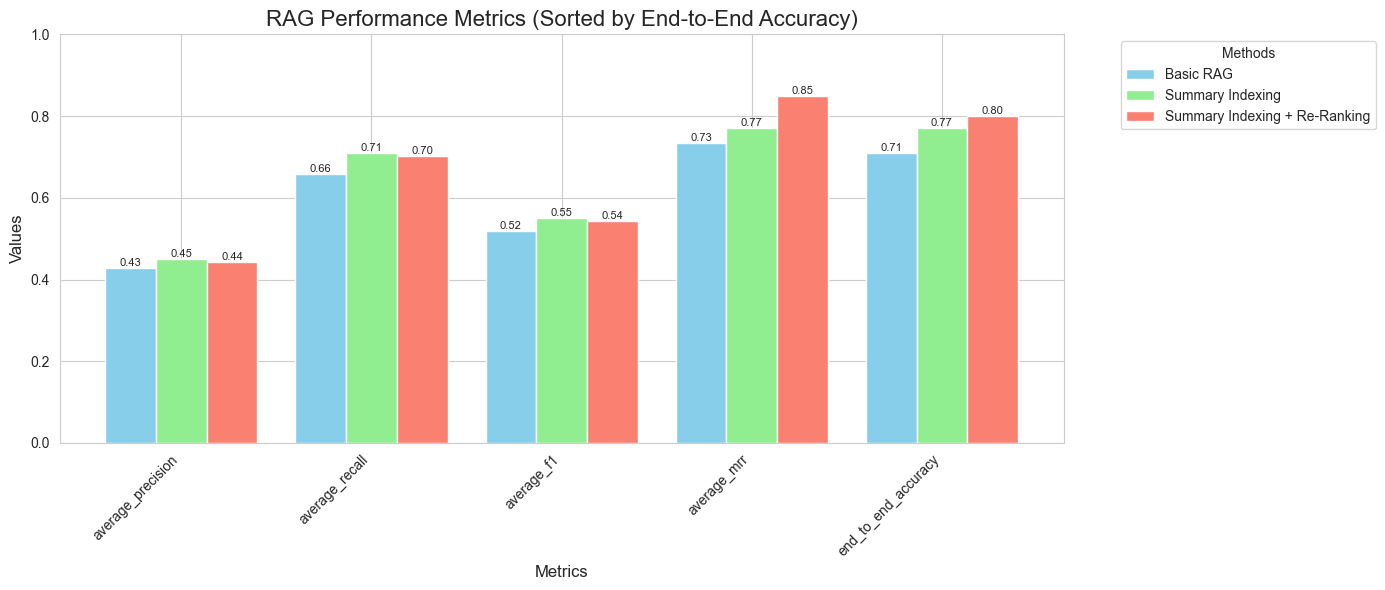

In [46]:
# Visualizing our performance
plot_performance('evaluation/json_results', ['Basic RAG', 'Summary Indexing', 'Summary Indexing + Re-Ranking'], colors=['skyblue', 'lightgreen', 'salmon'])

# Evaluation

This guide has illustrated the importance of measuring prompt performance empirically when prompt engineering. You can read more about our empirical methodology to prompt engineering here. Using a Jupyter Notebook is a great way to start prompt engineering but as your datasets grow larger and your prompts more numerous it is important to leverage tooling that will scale with you.

In this section of the guide we will explore using Promptfoo an open source LLM evaluation toolkit. To get started head over to the ./evaluation directory and checkout the ./evaluation/README.md.

Promptfoo makes it very easy to build automated test suites that compare different models, hyperparameter choices, and prompts against one another.

As an example, you can run the below cell to see the average performance of Haiku vs 3.5 Sonnet across all of our test cases.

In [ ]:
import json
import pandas as pd
import numpy as np

# Load the JSON file
with open('data/end_to_end_results.json', 'r') as f:
    data = json.load(f)

# Extract the results
results = data['results']['results']

# Create a DataFrame
df = pd.DataFrame(results)

# Extract provider, prompt, and score information
df['provider'] = df['provider'].apply(lambda x: x['label'] if isinstance(x, dict) else x)
df['prompt'] = df['prompt'].apply(lambda x: x['label'] if isinstance(x, dict) else x)

# Function to safely extract scores
def extract_score(x):
    if isinstance(x, dict) and 'score' in x:
        return x['score'] * 100  # Convert to percentage
    return np.nan

df['score'] = df['gradingResult'].apply(extract_score)

# Group by provider and prompt, then calculate mean scores
result = df.groupby(['provider', 'prompt'])['score'].mean().unstack()

# Fill NaN values with 0
result = result.fillna(0)

# Calculate the average score across all prompts for each provider
result['Average'] = result.mean(axis=1)

# Sort the result by the average score
result = result.sort_values(by='Average', ascending=False)

# Round the results to 2 decimal places
result = result.round(2)
# Calculate overall statistics
overall_average = result['Average'].mean()
overall_std = result['Average'].std()
best_provider = result['Average'].idxmax()
worst_provider = result['Average'].idxmin()

print(f"\nOverall Statistics:")
print(f"Best Performing Provider: {best_provider} ({result.loc[best_provider, 'Average']:.2f}%)")
print(f"Worst Performing Provider: {worst_provider} ({result.loc[worst_provider, 'Average']:.2f}%)")